# Expand reader group coverage
In prior analysis, we have seen that some reader groups have poor coverage, specifically expertise and demographics.

Let's use the prior author data to expand this coverage.

### Load data

In [1]:
import pandas as pd
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import load_all_author_data
author_data_dir = '../../data/reddit_data/author_data/'
usecols = ['author', 'subreddit', 'created_utc', 'id']
author_data = load_all_author_data(author_data_dir, usecols=usecols)
print(author_data.loc[:, 'author'].nunique())

  3%|▎         | 7043/204619 [03:55<41:21, 79.64it/s]   

skipping file ../../data/reddit_data/author_data/OJnToothpaste_comments.gz because error Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.



 13%|█▎        | 26710/204619 [23:49<1:04:26, 46.02it/s] 

skipping file ../../data/reddit_data/author_data/papercut_eyelid_comments.gz because error Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.



 17%|█▋        | 34126/204619 [30:48<3:44:05, 12.68it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 28%|██▊       | 56942/204619 [52:19<4:53:10,  8.40it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 42%|████▏     | 86740/204619 [1:13:33<1:11:55, 27.31it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable


In [2]:
## limit to actual question askers
question_comment_data = pd.read_csv('../../data/reddit_data/advice_subreddit_no_filter_comment_question_data.gz', sep='\t', compression='gzip', usecols=['author', 'parent_id', 'subreddit', 'created_utc'])

In [22]:
## get date info
from datetime import datetime, timedelta
from monthdelta import monthdelta
import re
# num_matcher = re.compile('\d+\.\d')
# author_data = author_data.assign(**{
#     'date' : author_data.loc[:, 'created_utc'].apply(lambda x: datetime.fromtimestamp(int(float(x))) if (type(x) is str and num_matcher.match(x) is not None) else x),
# })
# question_comment_data = question_comment_data.assign(**{
#     'date' : question_comment_data.loc[:, 'created_utc'].apply(lambda x: datetime.fromtimestamp(int(float(x)))),
# })
## convert to date-day bins
from math import ceil
import numpy as np
start_year, end_year = 2018, 2019
start_month, end_month = 1, 12
bin_month_width = 6
months_per_year = 12
date_bin_count = int(ceil(((end_year - start_year + 1) * months_per_year) / bin_month_width))
start_date = datetime(year=start_year, month=1, day=1)
date_bins = [start_date + monthdelta(bin_month_width*i) for i in range(date_bin_count)]
date_bins = np.array(list(map(lambda x: x.timestamp(), date_bins)))
from data_helpers import assign_date_bin
author_data = author_data.assign(**{
    'date_day_bin' : author_data.loc[:, 'date'].apply(lambda x: assign_date_bin(x, date_bins) if (type(x) is float and not np.isnan(x)) else None),
})
question_comment_data = question_comment_data.assign(**{
    'date_day_bin' : question_comment_data.loc[:, 'date'].apply(lambda x: assign_date_bin(x.timestamp(), date_bins))
})

In [23]:
author_data.loc[:, 'date_day_bin'].unique()

array([datetime.datetime(2019, 7, 1, 0, 0),
       datetime.datetime(2019, 1, 1, 0, 0),
       datetime.datetime(2018, 7, 1, 0, 0),
       datetime.datetime(2018, 1, 1, 0, 0), -1, None], dtype=object)

## Expand expertise
Let's expand the definition of "expert" by counting the prior posts in topic-relevant subreddits.

Author $a$ posts a question in subreddit $s$.
1. $a$ is an "expert" if at least 90% of their prior posts are in subreddit $s$.
2. $a$ is an "expert" if at least 90% of their prior posts are in subreddits $\mathcal{S}_{t}$, i.e. $s$ or one of its top-k neighbors at time $t$.

In [53]:
## connect authors with original question time + subreddit info
question_comment_data.rename(columns={'subreddit' : 'question_subreddit', 'date_day_bin' : 'question_date_day_bin'}, inplace=True)
author_question_data = pd.merge(author_data, question_comment_data.loc[:, ['author', 'question_subreddit', 'question_date_day_bin']], on='author', how='right')
# fix data type
author_question_data = author_question_data.assign(**{
    'question_date_day_bin' : pd.Series(author_question_data.loc[:, 'question_date_day_bin'].values, dtype='object')
})
# remove null data
author_question_data = author_question_data[author_question_data.loc[:, 'date_day_bin'].apply(lambda x: type(x) is datetime)]

In [39]:
print(author_question_data.shape[0])
display(author_question_data.head())

69616031


,author,subreddit,created_utc,id,date,date_day_bin,question_subreddit,question_date_day_bin
0,DaveAlot,ultrawidemasterrace,1617058469.0,gsqofc7,1617058469.0,2019-07-01 00:00:00,personalfinance,2018-01-01 00:00:00
1,DaveAlot,ultrawidemasterrace,1615528553.0,gqnvkp0,1615528553.0,2019-07-01 00:00:00,personalfinance,2018-01-01 00:00:00
2,DaveAlot,ultrawidemasterrace,1614292110.0,gorg61l,1614292110.0,2019-07-01 00:00:00,personalfinance,2018-01-01 00:00:00
3,DaveAlot,ultrawidemasterrace,1614219096.0,gonosj2,1614219096.0,2019-07-01 00:00:00,personalfinance,2018-01-01 00:00:00
4,DaveAlot,tax,1612253656.0,glpizlx,1612253656.0,2019-07-01 00:00:00,personalfinance,2018-01-01 00:00:00


In [112]:
## get "expert" distribution
# get all posts written before question date
# compute % posted in question subreddit UGH
from tqdm import tqdm
tqdm.pandas()
def get_subreddit_pct_per_author_per_date(data, start_date):
#     print(f'data = \n{data.head()}')
#     print(f'N = {data.shape[0]}')
#     print(f'subreddit counts {data.loc[:, "subreddit"].value_counts()}')
    data.drop_duplicates('id', inplace=True)
    valid_data = data[data.loc[:, 'date_day_bin'] <= start_date]
    subreddit = data.loc[:, 'question_subreddit'].iloc[0]
    subreddit_pct = (data.loc[:, 'subreddit']==subreddit).sum() / data.shape[0]
    return subreddit_pct

In [133]:
from tqdm import tqdm
author_subreddit_counts = []
for subreddit_i, data_i in author_question_data.groupby(['question_subreddit']):
    print(f'**** processing data from subreddit={subreddit_i} ****')
    author_subreddit_counts_i = []
    for (author_j, date_j), data_j in tqdm(data_i.groupby(['author', 'question_date_day_bin'])):
        author_subreddit_counts_j = get_subreddit_pct_per_author_per_date(data_j, data_j.loc[:, 'question_date_day_bin'].iloc[0])
        author_subreddit_counts_i.append([author_j, date_j, author_subreddit_counts_j])
    author_subreddit_counts_i = pd.DataFrame(author_subreddit_counts_i, columns=['author', 'date', 'subreddit_pct'])
    author_subreddit_counts_i = author_subreddit_counts_i.assign(**{'subreddit' : subreddit_i})
    author_subreddit_counts.append(author_subreddit_counts_i)
author_subreddit_counts = pd.concat(author_subreddit_counts, axis=0)

**** processing data from subreddit=Advice ****


100%|██████████| 27868/27868 [01:26<00:00, 321.49it/s]


**** processing data from subreddit=AmItheAsshole ****


100%|██████████| 62629/62629 [03:15<00:00, 320.11it/s]


**** processing data from subreddit=legaladvice ****


100%|██████████| 22512/22512 [01:10<00:00, 320.58it/s]


**** processing data from subreddit=pcmasterrace ****


100%|██████████| 17462/17462 [00:53<00:00, 324.49it/s]


**** processing data from subreddit=personalfinance ****


100%|██████████| 37266/37266 [01:56<00:00, 319.06it/s]


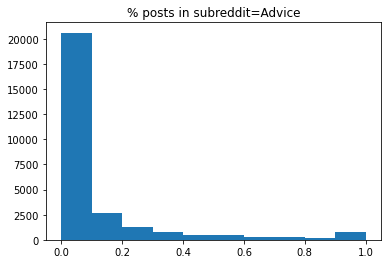

subreddit=Advice
value counts = 
0.0    20600
0.1     2688
0.2     1273
0.3      765
0.4      526
0.5      502
0.6      301
0.7      245
0.8      226
0.9      742
dtype: int64
value cutoff = 0.103; percentiles =
0    20888
1     6980
dtype: int64


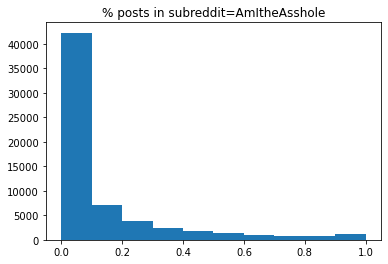

subreddit=AmItheAsshole
value counts = 
0.0    42257
0.1     7190
0.2     3876
0.3     2345
0.4     1752
0.5     1441
0.6      974
0.7      788
0.8      731
0.9     1275
dtype: int64
value cutoff = 0.155; percentiles =
0    46952
1    15677
dtype: int64


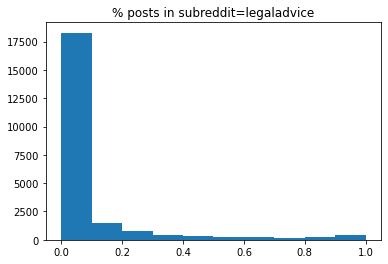

subreddit=legaladvice
value counts = 
0.0    18286
0.1     1441
0.2      733
0.3      432
0.4      293
0.5      269
0.6      206
0.7      202
0.8      210
0.9      440
dtype: int64
value cutoff = 0.052; percentiles =
0    16871
1     5641
dtype: int64


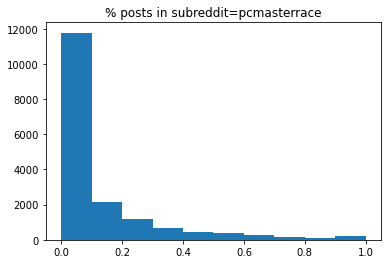

subreddit=pcmasterrace
value counts = 
0.0    11770
0.1     2173
0.2     1199
0.3      672
0.4      471
0.5      394
0.6      266
0.7      180
0.8      127
0.9      210
dtype: int64
value cutoff = 0.150; percentiles =
0    13023
1     4439
dtype: int64


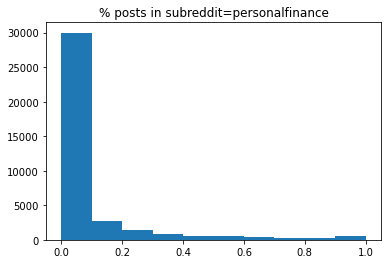

subreddit=personalfinance
value counts = 
0.0    29992
0.1     2769
0.2     1349
0.3      774
0.4      506
0.5      494
0.6      358
0.7      246
0.8      220
0.9      558
dtype: int64
value cutoff = 0.062; percentiles =
0    27947
1     9319
dtype: int64


In [148]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
bins = 10
percentile_cutoff = 75
for subreddit_i, data_i in author_subreddit_counts.groupby('subreddit'):
    plt.hist(data_i.loc[:, 'subreddit_pct'].values)
    plt.title(f'% posts in subreddit={subreddit_i}')
    plt.show()
    # also show counts
    print(f'subreddit={subreddit_i}')
    subreddit_pct_counts = np.histogram(data_i.loc[:, 'subreddit_pct'].values, bins=bins)
    subreddit_pct_counts = pd.Series(subreddit_pct_counts[0], index=subreddit_pct_counts[1][:-1])
    print(f'value counts = \n{subreddit_pct_counts}')
    # compute percentiles
    subreddit_cutoff_pct = np.percentile(data_i.loc[:, 'subreddit_pct'].values, percentile_cutoff)
    subreddit_cutoff_pct_val_counts = pd.Series(np.digitize(data_i.loc[:, 'subreddit_pct'].values, [subreddit_cutoff_pct])).value_counts()
    print(f'value cutoff = {"{:.3f}".format(subreddit_cutoff_pct)}; percentiles =\n{subreddit_cutoff_pct_val_counts}')

We see that the "expert" category is very sparse; can we expand this with nearest-neighbor subreddits?

In [100]:
import re
import os
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
embed_data_dir = '../../data/reddit_data/author_data/'
subreddit_embed_file_matcher = re.compile('subreddit_embeddings_.*gz')
subreddit_embed_files = list(filter(lambda x: subreddit_embed_file_matcher.match(x) is not None, os.listdir(embed_data_dir)))
subreddit_embed_files = list(map(lambda x: os.path.join(embed_data_dir, x), subreddit_embed_files))
subreddit_nearest_neighbors = []
subreddits_to_query = author_question_data.loc[:, 'question_subreddit'].unique()
top_k = 10
date_fmt = '%Y-%m-%d'
for subreddit_embed_file_i in subreddit_embed_files:
    subreddit_embed_date_i = os.path.basename(subreddit_embed_file_i).split('.')[0].split('_')[-1]
    subreddit_embed_date_i = datetime.strptime(subreddit_embed_date_i, date_fmt)
    subreddit_embed_i = pd.read_csv(subreddit_embed_file_i, sep='\t', compression='gzip', index_col=0)
    for subreddit_j in subreddits_to_query:
        # find nearest neighbors
        if(subreddit_j in subreddit_embed_i.index):
            embed_sim_j = cosine_similarity(subreddit_embed_i.loc[[subreddit_j], :].values,
                                            Y=subreddit_embed_i.values)[0, :]
            embed_sim_j = pd.Series(embed_sim_j, index=subreddit_embed_i.index).sort_values(ascending=False, inplace=False)
            top_k_neighbors_j = embed_sim_j.index.tolist()[1:(top_k+1)]
            subreddit_nearest_neighbors.append([subreddit_j, subreddit_embed_date_i, top_k_neighbors_j])
subreddit_nearest_neighbors = pd.DataFrame(subreddit_nearest_neighbors, columns=['subreddit', 'date', 'neighbors'])

In [101]:
pd.set_option('display.max_colwidth', 500)
subreddit_nearest_neighbors.sort_values('subreddit', inplace=True)
display(subreddit_nearest_neighbors)

,subreddit,date,neighbors
3,Advice,2019-01-01,"[Needafriend, Psychic, needadvice, SuicideWatch, mentalhealth, getdisciplined, Rateme, amiugly, Anxiety, rant]"
8,Advice,2018-01-01,"[dating_advice, socialskills, NoFap, AskDocs, Aquariums, SuicideWatch, Austin, confession, runescape, tipofmytongue]"
17,Advice,2019-07-01,"[answers, Needafriend, MakeNewFriendsHere, lawofattraction, Instagram, NoFap, amiugly, SuicideWatch, medical, ask]"
12,Advice,2018-07-01,"[MakeNewFriendsHere, SuicideWatch, rant, socialskills, Marriage, ApplyingToCollege, amiugly, Anxiety, solotravel, stopdrinking]"
18,AmItheAsshole,2019-07-01,"[PurplePillDebate, survivor, 6thForm, EntitledBitch, kpop, discgolf, pettyrevenge, BravoRealHousewives, notliketheothergirls, blackladies]"
4,AmItheAsshole,2019-01-01,"[IsItBullshit, asktransgender, ftm, bisexual, newzealand, pettyrevenge, LetsNotMeet, melbourne, astrology, britishproblems]"
13,AmItheAsshole,2018-07-01,"[unpopularopinion, TooAfraidToAsk, TrueOffMyChest, offmychest, AMA, rant, AskDocs, TalesFromYourServer, casualiama, changemyview]"
2,legaladvice,2019-01-01,"[Insurance, legaladviceofftopic, bestoflegaladvice, LawSchool, sanfrancisco, Scams, LegalAdviceUK, ProtectAndServe, Divorce, chicago]"
16,legaladvice,2019-07-01,"[legaladvicecanada, Insurance, legaladviceofftopic, LawSchool, lawschooladmissions, polyamory, Landlord, AskHR, Veterans, bestoflegaladvice]"
7,legaladvice,2018-01-01,"[bestoflegaladvice, LawSchool, Aquariums, askcarsales, Accounting, JUSTNOMIL, exmormon, Austin, Seattle, bicycling]"


In [108]:
## filtered data
valid_subreddits = {
    'Advice' : {'needadvice', 'mentalhealth', 'getdisciplined', 'dating_advice', 'socialskills', 'AskDocs', 'tipofmytongue', 'answers', 'ask'},
    'AmItheAsshole' : {'IsItBullshit', 'TooAfraidToAsk', 'AskDocs'},
    'legaladvice' : {'Insurance', 'bestoflegaladvice', 'LawSchool', 'Scams', 'LegalAdviceUK', 'Landlord', 'AskHR'},
    'pcmasterrace' : {'watercooling', 'overclocking', 'bapcsalescanada', 'linuxmasterrace', 'Monitors', 'SuggestALaptop', 'pcgaming', 'buildmeapc'},
    'personalfinance' : {'StudentLoans', 'CreditCards', 'churning', 'tax', 'whatcarshouldIbuy', 'ynab', 'askcarsales', 'Accounting', 'RealEstate', 'financialindependence', 'investing', 'FinancialPlanning', 'smallbusiness'},
}
from functools import reduce
subreddit_nearest_neighbors = subreddit_nearest_neighbors.assign(**{
    'valid_neighbors' : subreddit_nearest_neighbors.apply(lambda x: set(x.loc['neighbors']) & valid_subreddits[x.loc['subreddit']], axis=1)
})
## combine into one set per subreddit
subreddit_combined_neighbors = subreddit_nearest_neighbors.groupby('subreddit').apply(lambda x: set(reduce(lambda a,b: a|b, x.loc[:, 'valid_neighbors'].values))).to_dict()
print(subreddit_combined_neighbors)

{'Advice': {'socialskills', 'mentalhealth', 'needadvice', 'ask', 'answers', 'tipofmytongue', 'getdisciplined', 'AskDocs', 'dating_advice'}, 'AmItheAsshole': {'IsItBullshit', 'AskDocs', 'TooAfraidToAsk'}, 'legaladvice': {'AskHR', 'LawSchool', 'LegalAdviceUK', 'Insurance', 'bestoflegaladvice', 'Scams', 'Landlord'}, 'pcmasterrace': {'SuggestALaptop', 'buildmeapc', 'overclocking', 'watercooling', 'linuxmasterrace', 'pcgaming', 'Monitors', 'bapcsalescanada'}, 'personalfinance': {'smallbusiness', 'askcarsales', 'ynab', 'FinancialPlanning', 'churning', 'RealEstate', 'whatcarshouldIbuy', 'StudentLoans', 'CreditCards', 'investing', 'financialindependence', 'Accounting', 'tax'}}


In [249]:
## write to file for later
clean_subreddit_neighbor_data = pd.DataFrame(pd.Series({'Advice': {'socialskills', 'mentalhealth', 'needadvice', 'ask', 'answers', 'tipofmytongue', 'getdisciplined', 'AskDocs', 'dating_advice'}, 'AmItheAsshole': {'IsItBullshit', 'AskDocs', 'TooAfraidToAsk'}, 'legaladvice': {'AskHR', 'LawSchool', 'LegalAdviceUK', 'Insurance', 'bestoflegaladvice', 'Scams', 'Landlord'}, 'pcmasterrace': {'SuggestALaptop', 'buildmeapc', 'overclocking', 'watercooling', 'linuxmasterrace', 'pcgaming', 'Monitors', 'bapcsalescanada'}, 'personalfinance': {'smallbusiness', 'askcarsales', 'ynab', 'FinancialPlanning', 'churning', 'RealEstate', 'whatcarshouldIbuy', 'StudentLoans', 'CreditCards', 'investing', 'financialindependence', 'Accounting', 'tax'}}))
clean_subreddit_neighbor_data = clean_subreddit_neighbor_data.reset_index(inplace=False).rename(columns={'index' : 'subreddit', 0 : 'neighbors'})
display(clean_subreddit_neighbor_data.head())
clean_subreddit_neighbor_data.to_csv('../../data/reddit_data/author_data/advice_subreddit_neighbors.tsv', sep='\t', index=False)

,subreddit,neighbors
0,Advice,"{getdisciplined, mentalhealth, AskDocs, social..."
1,AmItheAsshole,"{IsItBullshit, TooAfraidToAsk, AskDocs}"
2,legaladvice,"{LawSchool, Insurance, bestoflegaladvice, Lega..."
3,pcmasterrace,"{pcgaming, Monitors, linuxmasterrace, SuggestA..."
4,personalfinance,"{whatcarshouldIbuy, Accounting, askcarsales, c..."


Now that we have the nearest neighbors, let's re-run the "expert" tests.

In [116]:
def get_subreddit_neighbors_pct_per_author_per_date(data, start_date, neighbors):
    data.drop_duplicates('id', inplace=True)
    valid_data = data[data.loc[:, 'date_day_bin'] <= start_date]
    subreddit = data.loc[:, 'question_subreddit'].iloc[0]
    subreddit_neighbors = neighbors[subreddit]
    subreddit_pct = (data.loc[:, 'subreddit'].apply(lambda x: x==subreddit or x in subreddit_neighbors)).sum() / data.shape[0]
    return subreddit_pct

In [117]:
from tqdm import tqdm
author_neighbor_subreddit_counts = []
for subreddit_i, data_i in author_question_data.groupby(['question_subreddit']):
    print(f'**** processing data from subreddit={subreddit_i} ****')
    author_neighbor_subreddit_counts_i = []
    for (author_j, date_j), data_j in tqdm(data_i.groupby(['author', 'question_date_day_bin'])):
        author_neighbor_subreddit_counts_j = get_subreddit_neighbors_pct_per_author_per_date(data_j, data_j.loc[:, 'question_date_day_bin'].iloc[0], subreddit_combined_neighbors)
        author_neighbor_subreddit_counts_i.append([author_j, date_j, author_neighbor_subreddit_counts_j])
    author_neighbor_subreddit_counts_i = pd.DataFrame(author_neighbor_subreddit_counts_i, columns=['author', 'date', 'subreddit_pct'])
    author_neighbor_subreddit_counts_i = author_neighbor_subreddit_counts_i.assign(**{'subreddit' : subreddit_i})
    author_neighbor_subreddit_counts.append(author_neighbor_subreddit_counts_i)
author_neighbor_subreddit_counts = pd.concat(author_neighbor_subreddit_counts, axis=0)

**** processing data from subreddit=Advice ****


100%|██████████| 27868/27868 [01:28<00:00, 314.34it/s]


**** processing data from subreddit=AmItheAsshole ****


100%|██████████| 62629/62629 [03:20<00:00, 312.28it/s]


**** processing data from subreddit=legaladvice ****


100%|██████████| 22512/22512 [01:12<00:00, 310.70it/s]


**** processing data from subreddit=pcmasterrace ****


100%|██████████| 17462/17462 [00:55<00:00, 316.34it/s]


**** processing data from subreddit=personalfinance ****


100%|██████████| 37266/37266 [01:59<00:00, 311.35it/s]


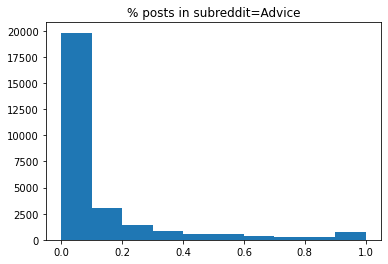

subreddit=Advice
value counts = 
0.0    19818
0.1     3073
0.2     1414
0.3      846
0.4      574
0.5      524
0.6      336
0.7      262
0.8      240
0.9      781
dtype: int64
value cutoff = 0.121; percentiles =
0    20827
1     7041
dtype: int64


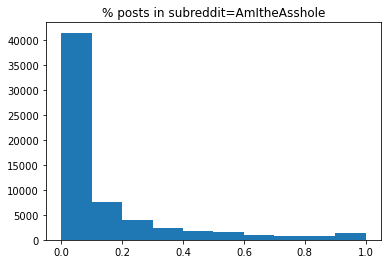

subreddit=AmItheAsshole
value counts = 
0.0    41490
0.1     7612
0.2     4026
0.3     2416
0.4     1782
0.5     1487
0.6      991
0.7      805
0.8      735
0.9     1285
dtype: int64
value cutoff = 0.162; percentiles =
0    46933
1    15696
dtype: int64


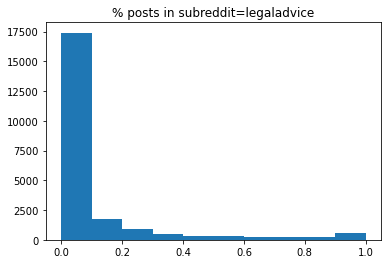

subreddit=legaladvice
value counts = 
0.0    17406
0.1     1781
0.2      918
0.3      502
0.4      334
0.5      333
0.6      232
0.7      219
0.8      250
0.9      537
dtype: int64
value cutoff = 0.081; percentiles =
0    16863
1     5649
dtype: int64


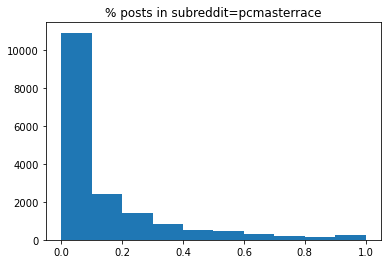

subreddit=pcmasterrace
value counts = 
0.0    10939
0.1     2413
0.2     1402
0.3      814
0.4      542
0.5      446
0.6      303
0.7      216
0.8      145
0.9      242
dtype: int64
value cutoff = 0.184; percentiles =
0    13089
1     4373
dtype: int64


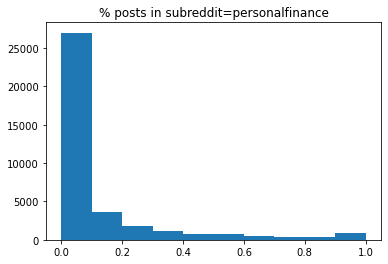

subreddit=personalfinance
value counts = 
0.0    26991
0.1     3634
0.2     1810
0.3     1141
0.4      774
0.5      743
0.6      533
0.7      411
0.8      405
0.9      824
dtype: int64
value cutoff = 0.112; percentiles =
0    27898
1     9368
dtype: int64


In [147]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
bins = 10
percentile_cutoff = 75
for subreddit_i, data_i in author_subreddit_neighbor_counts.groupby('subreddit'):
    plt.hist(data_i.loc[:, 'subreddit_pct'].values, bins=bins)
    plt.title(f'% posts in subreddit={subreddit_i}')
    plt.show()
    # also show counts
    print(f'subreddit={subreddit_i}')
    subreddit_pct_counts = np.histogram(data_i.loc[:, 'subreddit_pct'].values, bins=bins)
    subreddit_pct_counts = pd.Series(subreddit_pct_counts[0], index=subreddit_pct_counts[1][:-1])
    print(f'value counts = \n{subreddit_pct_counts}')
    # compute percentiles
    subreddit_cutoff_pct = np.percentile(data_i.loc[:, 'subreddit_pct'].values, percentile_cutoff)
    subreddit_cutoff_pct_val_counts = pd.Series(np.digitize(data_i.loc[:, 'subreddit_pct'].values, [subreddit_cutoff_pct])).value_counts()
    print(f'value cutoff = {"{:.3f}".format(subreddit_cutoff_pct)}; percentiles =\n{subreddit_cutoff_pct_val_counts}')

OK! We don't see a huge change in the distributions overall, except for maybe a few hundred authors in each subreddit.

## Expand location
We have previously identified an author's location based on whether they disclose their location in prior comments ("I live in ___").

Let's expand this by looking at location-specific subreddits.

In [5]:
author_subreddits = author_data.loc[:, 'subreddit'].unique()
print(len(author_subreddits))

86676


In [7]:
'nyc' in author_subreddits

True

In [9]:
## get top subreddits for location? will save time
subreddit_counts = author_data.loc[:, 'subreddit'].value_counts()
display(subreddit_counts.head(10))

AskReddit              1095276
AmItheAsshole           686828
pcmasterrace            263390
Advice                  210694
politics                209760
personalfinance         204087
relationship_advice     176220
wallstreetbets          154976
legaladvice             139826
unpopularopinion        135142
Name: subreddit, dtype: int64

In [14]:
subreddit_counts[subreddit_counts.index == 'germany']

germany    2344
Name: subreddit, dtype: int64

In [29]:
subreddit_counts[subreddit_counts.index == 'LosAngeles']

LosAngeles    8743
Name: subreddit, dtype: int64

In [26]:
import numpy as np
min_subreddit_count_pct = 95
min_subreddit_count = np.percentile(subreddit_counts, min_subreddit_count_pct)
print(min_subreddit_count)
cutoff_subreddit_counts = subreddit_counts[subreddit_counts >= min_subreddit_count]
print(len(cutoff_subreddit_counts))

466.3000000000029
4334


In [74]:
## naive approach: identify all possible locations in subreddit names by geolocation lol
import geocoder
test_location = 'Michigan'
test_location_estimate = geocoder.osm(test_location)
print(test_location_estimate)

<[OK] Osm - Geocode [Michigan, United States]>


In [76]:
from tqdm import tqdm
# first split camel cases
import re
CAMEL_CASE_MATCHER = re.compile('([a-z])(?=[A-Z])')
def split_subreddit_name(name):
    split_name = name
    # add spaces from the end of word
    for match in reversed(list(CAMEL_CASE_MATCHER.finditer(name))):
        span_start, span_end = match.span()
        split_name = split_name[:span_start+1] + ' ' + split_name[span_end:]
    # also fix underscores
    split_name = split_name.replace('_', ' ')
    return split_name
test_location = 'TestSubName'
print(split_subreddit_name(test_location))

Test Sub Name


In [77]:
clean_subreddit_names = cutoff_subreddit_counts.index.tolist()
clean_subreddit_names = list(map(split_subreddit_name, clean_subreddit_names))
print(clean_subreddit_names[:10])

['Ask Reddit', 'Am Ithe Asshole', 'pcmasterrace', 'Advice', 'politics', 'personalfinance', 'relationship advice', 'wallstreetbets', 'legaladvice', 'unpopularopinion']


In [79]:
# sample reddits with split names
print(list(filter(lambda x: ' ' in x, clean_subreddit_names))[:20])

['Ask Reddit', 'Am Ithe Asshole', 'relationship advice', 'Public Freakout', 'No Stupid Questions', 'Ask Men', 'Reddit Sessions', 'Ask Ouija', 'White People Twitter', 'Roast Me', 'Life Pro Tips', 'Ask Women', 'Too Afraid To Ask', 'True Off My Chest', 'Two XChromosomes', 'Escapefrom Tarkov', 'Idiots In Cars', 'Political Humor', 'Choosing Beggars', 'Destiny The Game']


In [80]:
import geocoder
clean_subreddit_locations = list(map(lambda x: geocoder.osm(x), tqdm(clean_subreddit_names)))

 93%|█████████▎| 4046/4334 [33:46<02:30,  1.92it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Maladaptive+Dreaming&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=mealtimevideos&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 93%|█████████▎| 4048/4334 [33:46<01:28,  3.24it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=tinytower&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status co

 94%|█████████▍| 4072/4334 [33:52<02:11,  2.00it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Wilmington&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Piercing+Advice&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 94%|█████████▍| 4074/4334 [33:53<02:16,  1.90it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=serialpodcast&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Un

Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Konosuba&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 95%|█████████▍| 4099/4334 [34:06<02:08,  1.83it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=cpp&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=March+Against+Nazis&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 95%|█████████▍| 4102/4334 [34:07<01:59,  1.94it/s]Status code Unknown fr

 95%|█████████▌| 4124/4334 [34:18<01:54,  1.83it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=adhd+anxiety&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=guitarcirclejerk&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 95%|█████████▌| 4127/4334 [34:20<01:47,  1.93it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=askcarguys&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Un

 96%|█████████▌| 4150/4334 [34:31<01:35,  1.93it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Dermatology&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=misophonia&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 96%|█████████▌| 4152/4334 [34:32<01:37,  1.86it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=tuckedinkitties&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unkn

Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=NYCbike&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 96%|█████████▋| 4177/4334 [34:45<01:24,  1.85it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Batman+Arkham&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=driving&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 96%|█████████▋| 4179/4334 [34:46<01:24,  1.83it/s]Status code Unknown from 

 97%|█████████▋| 4202/4334 [34:57<01:11,  1.84it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Trump+Criticizes+Trump&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=kindafunny&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 97%|█████████▋| 4205/4334 [34:59<01:06,  1.94it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=laravel&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code U

 98%|█████████▊| 4228/4334 [35:10<00:55,  1.93it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Fire+Emblem+Three+Houses&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=csgomarketforum&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 98%|█████████▊| 4230/4334 [35:11<00:55,  1.87it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=shiba&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status c

Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=STD&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 98%|█████████▊| 4256/4334 [35:24<00:40,  1.93it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Mariners&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Snus&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 98%|█████████▊| 4258/4334 [35:25<00:40,  1.88it/s]Status code Unknown from https://nomi

 99%|█████████▉| 4281/4334 [35:37<00:27,  1.93it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Lineage+OS&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Bushcraft&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 99%|█████████▉| 4283/4334 [35:38<00:27,  1.86it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=homesecurity&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown f

 99%|█████████▉| 4306/4334 [35:43<00:13,  2.06it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=For+All+Mankind+TV&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=phinvest&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 99%|█████████▉| 4309/4334 [35:44<00:12,  2.08it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Detroit+Become+Human&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status

100%|█████████▉| 4332/4334 [35:50<00:00, 10.62it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=mobilerepair&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Reds&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
100%|██████████| 4334/4334 [35:51<00:00,  2.01it/s]


In [109]:
test_name = 'Atlanta'
test_name_location = clean_subreddit_locations[np.where(np.array(clean_subreddit_names)==test_name)[0][0]]
print(test_name_location.geojson)
print(test_name_location.geojson['features'][0]['properties']['accuracy'])

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'accuracy': 0.8008028207926616, 'address': 'Atlanta, Fulton County, Georgia, United States', 'bbox': [-84.551068, 33.647808, -84.28956, 33.886823], 'city': 'Atlanta', 'confidence': 1, 'country': 'United States', 'country_code': 'us', 'county': 'Fulton County', 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons//poi_boundary_administrative.p.20.png', 'importance': 0.8008028207926616, 'lat': 33.7489924, 'lng': -84.3902644, 'ok': True, 'osm_id': 119557, 'osm_type': 'relation', 'place_id': 257814846, 'place_rank': 16, 'quality': 'administrative', 'raw': {'place_id': 257814846, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 119557, 'boundingbox': ['33.647808', '33.886823', '-84.551068', '-84.28956'], 'lat': '33.7489924', 'lon': '-84.3902644', 'display_name': 'Atlanta, Fulton County, Georgia, United States', 'place_rank': 16, 'category': 

In [146]:
import numpy as np
clean_subreddit_location_data = pd.DataFrame(
    [cutoff_subreddit_counts.index.tolist(), clean_subreddit_names], index=['subreddit', 'clean_subreddit']
).transpose()
clean_subreddit_location_data = clean_subreddit_location_data.assign(**{
    'location_data' : list(map(lambda x: x.geojson if x.ok else np.nan, clean_subreddit_locations))
})
clean_subreddit_location_data.dropna(how='any', axis=0, inplace=True)
# clean_subreddit_location_data = clean_subreddit_location_data.assign(**{})
clean_subreddit_location_data = clean_subreddit_location_data.assign(**{
    'accuracy' : clean_subreddit_location_data.loc[:, 'location_data'].apply(lambda x: x['features'][0]['properties']['accuracy'])
})
display(clean_subreddit_location_data.head())
# define cutoff based on min accuracy of test locations
location_accuracy_cutoff = 0.80
high_accuracy_subreddit_location_data = clean_subreddit_location_data[clean_subreddit_location_data.loc[:, 'accuracy']>=location_accuracy_cutoff]
display(high_accuracy_subreddit_location_data.head(20))

,subreddit,clean_subreddit,location_data,accuracy
3,Advice,Advice,"{'type': 'FeatureCollection', 'features': [{'t...",0.111
4,politics,politics,"{'type': 'FeatureCollection', 'features': [{'t...",0.101
10,news,news,"{'type': 'FeatureCollection', 'features': [{'t...",0.300
11,pics,pics,"{'type': 'FeatureCollection', 'features': [{'t...",0.225
12,funny,funny,"{'type': 'FeatureCollection', 'features': [{'t...",0.101


,subreddit,clean_subreddit,location_data,accuracy
147,canada,canada,"{'type': 'FeatureCollection', 'features': [{'t...",0.966126
171,europe,europe,"{'type': 'FeatureCollection', 'features': [{'t...",0.820707
174,de,de,"{'type': 'FeatureCollection', 'features': [{'t...",0.989681
183,australia,australia,"{'type': 'FeatureCollection', 'features': [{'t...",0.952135
243,ireland,ireland,"{'type': 'FeatureCollection', 'features': [{'t...",0.873846
268,nyc,nyc,"{'type': 'FeatureCollection', 'features': [{'t...",0.817577
278,ontario,ontario,"{'type': 'FeatureCollection', 'features': [{'t...",0.835597
280,LosAngeles,Los Angeles,"{'type': 'FeatureCollection', 'features': [{'t...",0.973805
281,chicago,chicago,"{'type': 'FeatureCollection', 'features': [{'t...",0.851530
348,SeattleWA,Seattle WA,"{'type': 'FeatureCollection', 'features': [{'t...",0.882979


What is the distribution of countries?

In [151]:
high_accuracy_subreddit_location_data = high_accuracy_subreddit_location_data.assign(**{
    'country' : high_accuracy_subreddit_location_data.loc[:, 'location_data'].apply(lambda x: x['features'][0]['properties'].get('country_code'))
})
# for all locations that don't have country
country_matches = {
    'europe' : 'eur',
}
high_accuracy_subreddit_location_data = high_accuracy_subreddit_location_data.assign(**{
    'country' : high_accuracy_subreddit_location_data.apply(lambda x: country_matches[x.loc['subreddit']] if x.loc['subreddit'] in country_matches else x.loc['country'], axis=1)
})
## get country regions
country_regions = {
    'us' : 'US'
}
country_regions.update({
    x : 'non_US' for x in high_accuracy_subreddit_location_data.loc[:, 'country'].unique() if x != 'us'
})
high_accuracy_subreddit_location_data = high_accuracy_subreddit_location_data.assign(**{
    'country_region' : high_accuracy_subreddit_location_data.loc[:, 'country'].apply(lambda x: country_regions[x] if x in country_regions else 'UNK')
})
print(high_accuracy_subreddit_location_data.loc[:, 'country'].value_counts().head(20))
print(high_accuracy_subreddit_location_data.loc[:, 'country_region'].value_counts())

us    56
ca     4
au     3
cn     3
de     3
hu     2
nl     2
gb     2
no     2
pl     1
ar     1
in     1
kr     1
fr     1
ch     1
jp     1
pt     1
ro     1
tr     1
dk     1
Name: country, dtype: int64
US        56
non_US    50
Name: country_region, dtype: int64


Obviously very skewed toward US.

What is the location distribution among authors?

In [170]:
# ## join with author data
location_author_data = pd.merge(
    author_data, 
    high_accuracy_subreddit_location_data.loc[:, ['subreddit', 'country', 'country_region']], 
    on='subreddit', how='left',
)
# drop bad authors??
location_author_data.dropna(subset=['author'], inplace=True)
location_author_data = location_author_data[location_author_data.loc[:, 'author'].apply(lambda x: type(x) is str)]
# display(location_author_data.head())
print(location_author_data.loc[:, 'country'].value_counts().head(20))
print(location_author_data.loc[:, 'country_region'].value_counts().head(20))

us     112677
ca      29486
au      18099
de      14321
eur     11181
ie       8247
sg       5023
fr       4700
gb       4166
cn       3829
ro       3760
ph       3751
in       3720
dk       3675
se       3615
it       3229
ar       3215
pt       3094
br       2751
mx       2715
Name: country, dtype: int64
non_US    158276
US        112677
Name: country_region, dtype: int64


This distribution is less bad than I thought!

Let's see the distribution per-author.

In [171]:
from tqdm import tqdm
tqdm.pandas()
author_loc_counts = []
for author_i, data_i in tqdm(location_author_data.groupby('author')):
    author_loc_counts_i = data_i.loc[:, 'country_region'].value_counts().reset_index(name='count').rename(columns={'index' : 'country_region'})
    author_loc_counts_i = author_loc_counts_i.assign(**{'author' : author_i})
    author_loc_counts.append(author_loc_counts_i)
author_loc_counts = pd.concat(author_loc_counts, axis=0)
display(author_loc_counts.head())
# per_author_location_counts = location_author_data.groupby('author').progress_apply(lambda x: x.)
# display(per_author_location_counts.head())

100%|██████████| 188921/188921 [08:16<00:00, 380.48it/s]


,index,country_region,author
0,non_US,1,--Isaac--
0,US,2,--MJL
0,US,1,--NiNjA--
0,non_US,6,--SharkBoy--
0,non_US,8,--_T_T_--


In [202]:
display(author_loc_counts.head())
# # un-melt data => author | US | non-US | all
flat_author_loc_counts = author_loc_counts.pivot(columns='country_region', values='count', index='author').fillna(0., inplace=False).reset_index()
flat_author_loc_counts = flat_author_loc_counts.assign(**{
    'all_locations' : flat_author_loc_counts.loc[:, ['US', 'non_US']].sum(axis=1)
})
display(flat_author_loc_counts.head())

,country_region,count,author
0,non_US,1,--Isaac--
0,US,2,--MJL
0,US,1,--NiNjA--
0,non_US,6,--SharkBoy--
0,non_US,8,--_T_T_--


country_region,author,US,non_US,all_locations
0,--Isaac--,0.0,1.0,1.0
1,--MJL,2.0,0.0,2.0
2,--NiNjA--,1.0,0.0,1.0
3,--SharkBoy--,0.0,6.0,6.0
4,--_T_T_--,0.0,8.0,8.0


In [203]:
min_location_count = 10
print(f'{flat_author_loc_counts[flat_author_loc_counts.loc[:, "all_locations"] >= min_location_count].loc[:, "author"].nunique()} authors who meet country criterion')

7218 authors who meet country criterion


Let's assign locations to these authors, and see how many of these agree/conflict with the previously assigned locations.

In [213]:
def assign_label_by_count(data):
    max_count = data.max()
    if(all(data == max_count)):
        return 'UNK'
    else:
        return data.index[np.where(data == max_count)[0][0]]
country_regions = ['US', 'non_US']
flat_author_loc_counts = flat_author_loc_counts.assign(**{
    'country_region' : flat_author_loc_counts.apply(lambda x: assign_label_by_count(x.loc[country_regions]), axis=1)
})

In [219]:
min_location_count = 10
author_location_subreddit_data = flat_author_loc_counts[flat_author_loc_counts.loc[:, 'all_locations']>=min_location_count].loc[:, ['author', 'country_region']]
display(author_location_subreddit_data.head())

country_region,author,country_region
22,-CoffeeSprocket-,US
25,-DIL-,US
30,-DotDotDot,non_US
33,-Gabria,non_US
34,-Gh0st96-,non_US


In [224]:
author_self_reported_location_data = pd.read_csv('../../data/reddit_data/author_data/author_static_prior_comment_data.gz', sep='\t', compression='gzip', usecols=['author', 'location'])
author_self_reported_location_data = author_self_reported_location_data[author_self_reported_location_data.loc[:, 'location']!='UNK']
# add location region FML
from collections import defaultdict
location_region_lookup = defaultdict(lambda : 'non_US')
location_region_lookup['us'] = 'US'
author_self_reported_location_data = author_self_reported_location_data.assign(**{
    'location_region' : author_self_reported_location_data.loc[:, 'location'].apply(lambda x: location_region_lookup[x])
})
print(f'{author_self_reported_location_data.shape[0]} authors with valid self-reported location')
author_self_reported_location_data.rename(columns={'location_region' : 'self_report_location_region'}, inplace=True)
display(author_self_reported_location_data.head())

14191 authors with valid self-reported location


,author,location,self_report_location_region
7,tboyacending,in,non_US
9,delta390,us,US
40,AgathaAgate,mt,non_US
63,pianoboy1422,us,US
66,HB3234,us,US


In [232]:
author_combined_location_data = pd.merge(author_location_subreddit_data, author_self_reported_location_data.loc[:, ['author', 'self_report_location_region']], on='author', how='inner')
author_combined_location_data = author_combined_location_data[author_combined_location_data.loc[:, 'country_region']!='UNK']
print(f'{author_combined_location_data.shape[0]} authors with both subreddit and self-reported locations')
display(author_combined_location_data.head())

710 authors with both subreddit and self-reported locations


,author,country_region,self_report_location_region
0,-CoffeeSprocket-,US,US
1,-Jim-Lahey,US,US
2,-Johnny-,US,non_US
3,123cats-,US,US
4,13159daysold,non_US,non_US


In [237]:
location_agreement = (author_combined_location_data.loc[:, 'country_region']==author_combined_location_data.loc[:, 'self_report_location_region']).sum()
print(f'{location_agreement / author_combined_location_data.shape[0]*100}% agreement in locations')
## better than random?
from scipy.stats import chi2_contingency
location_count_table = pd.concat([
    author_combined_location_data.loc[:, 'country_region'].value_counts(),
    author_combined_location_data.loc[:, 'self_report_location_region'].value_counts(),
], axis=1)
chi_2, p_val, _, _ = chi2_contingency(location_count_table)
print(f'chi2={chi_2} (p={p_val})')
from sklearn.metrics import cohen_kappa_score
agreement_stat = cohen_kappa_score(author_combined_location_data.loc[:, 'country_region'].values, author_combined_location_data.loc[:, 'self_report_location_region'].values)
print(f'{agreement_stat} agreement')

87.74647887323944% agreement in locations
chi2=0.40927841860967834 (p=0.5223359789283297)
0.7528112369442554 agreement


OK! So the proportions of US and non-US are roughly the same and we have high agreement.

We will therefore use the location subreddit counts to boost our location coverage.

How much of an increase do we get by including the subreddit-location data?

In [240]:
self_report_location_authors = author_self_reported_location_data.loc[:, 'author'].unique()
extra_location_authors = set(author_location_subreddit_data.loc[:, 'author'].unique()) - set(self_report_location_authors)
print(f'{len(self_report_location_authors)} authors with self-reported location')
print(f'{len(extra_location_authors)} authors with only subreddit-reported location')

14191 authors with self-reported location
6506 authors with only subreddit-reported location


Great! We can increase the sample by almost 50%.

## Debug expert identification
Why are we losing so many "experts" from our data?

In [5]:
import pandas as pd
question_data = pd.read_csv('../../data/reddit_data/advice_subreddit_filter_comment_question_data.gz', sep='\t', index_col=False, compression='gzip', usecols=['author', 'created_utc', 'parent_id', 'subreddit'])
from datetime import datetime
question_data = question_data.assign(**{
    'date' : question_data.loc[:, 'created_utc'].apply(lambda x: datetime.fromtimestamp(x))
})
# round to day
question_data = question_data.assign(**{
    'date_day' : question_data.loc[:, 'date'].apply(lambda x: datetime(year=x.year, month=x.month, day=x.day))
})
display(question_data.head())

,author,created_utc,parent_id,subreddit,date,date_day
0,dfeu,1517443289,7uej1t,pcmasterrace,2018-02-01 00:01:29,2018-02-01
1,HuiOdy,1517443295,7ud5i4,Advice,2018-02-01 00:01:35,2018-02-01
2,Combative_Douche,1517443462,7u9xnz,legaladvice,2018-02-01 00:04:22,2018-02-01
3,kthxtyler,1517443792,7uekdv,personalfinance,2018-02-01 00:09:52,2018-02-01
4,webbyducktales,1517443921,7uekqi,Advice,2018-02-01 00:12:01,2018-02-01


In [12]:
import numpy as np
np.random.seed(123)
question_authors = question_data.loc[:, 'author'].unique()
print(len(question_authors))
sample_question_authors = set(np.random.choice(question_authors, int(0.1*len(question_authors)), replace=False))

176687


In [32]:
# load all author data
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import load_all_author_data
author_dir = '../../data/reddit_data/author_data/'
author_data = load_all_author_data(author_dir, usecols=['author', 'subreddit', 'created_utc', 'id'], valid_authors=sample_question_authors)
print(author_data.shape)
## drop bad data
import re
float_matcher = re.compile('\d+\.\d+')
author_data = author_data[author_data.loc[:, 'created_utc'].apply(lambda x: float_matcher.match(str(x)) is not None)]

In [34]:
## add date
author_data = author_data.assign(**{
    'created_utc' : author_data.loc[:, 'created_utc'].astype(float)
})
author_data = author_data.assign(**{
    'date' : author_data.loc[:, 'created_utc'].apply(lambda x: datetime.fromtimestamp(int(x)))
})

In [16]:
## get neighbor subreddits for 'expert' status
reload(data_helpers)
from data_helpers import collect_subreddit_embed_neighbors
subreddits_to_query = question_data.loc[:, 'subreddit'].unique()
subreddit_combined_neighbors = collect_subreddit_embed_neighbors(author_dir, subreddits_to_query)
subreddit_neighbor_lookup = dict(zip(subreddit_combined_neighbors.loc[:, 'subreddit'].values, subreddit_combined_neighbors.loc[:, 'neighbors'].values))

In [46]:
from tqdm import tqdm
authors_to_test = author_data.loc[:, 'author'].unique()
author_expert_data = []
for author_i in tqdm(authors_to_test):
    author_comment_data_i = author_data[author_data.loc[:, 'author']==author_i]
    question_data_i = question_data[question_data.loc[:, 'author']==author_i]
    question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
    for idx_j, data_j in question_data_i.iterrows():
        # expertise
        date_day_j = data_j.loc['date_day']
        date_j = data_j.loc['date']
        subreddit_j = data_j.loc['subreddit']
        author_prior_comment_data_j = author_comment_data_i[author_comment_data_i.loc[:, 'date'].apply(lambda x: x <= date_day_j)]
        if (author_prior_comment_data_j.shape[0] > 0):
            subreddit_neighbors_j = subreddit_neighbor_lookup[subreddit_j]
            relevant_prior_comment_data_j = author_prior_comment_data_j[(author_prior_comment_data_j.loc[:, 'subreddit'] == subreddit_j) | (author_prior_comment_data_j.loc[:, 'subreddit'].isin(subreddit_neighbors_j))]
            expertise_pct_j = relevant_prior_comment_data_j.shape[0] / author_prior_comment_data_j.shape[0]
        else:
            expertise_pct_j = 0.
            print(f'author={author_i} had no prior posts in subreddit={subreddit_j} prior to date {date_day_j}')
            display(author_comment_data_i)
            break
        author_expert_data.append([author_i, date_day_j, subreddit_j, expertise_pct_j])

  0%|          | 0/10682 [00:00<?, ?it/s]

author=Melleboiii had no prior posts in subreddit=AmItheAsshole prior to date 2019-08-07 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Melleboiii,GrandTheftAutoV,1.611349e+09,gk8m4ue,2021-01-22 21:04:58
1,Melleboiii,GrandTheftAutoV,1.611347e+09,gk8eyqx,2021-01-22 20:17:25
2,Melleboiii,buildapc,1.611245e+09,gk2lj9v,2021-01-21 16:00:38
3,Melleboiii,techsupportgore,1.608762e+09,ggu8dx7,2020-12-23 22:18:37
4,Melleboiii,GamePhysics,1.607948e+09,gfsymbn,2020-12-14 12:05:13
...,...,...,...,...,...
95,Melleboiii,AnimalsOnReddit,1.592136e+09,fuskqn5,2020-06-14 11:59:00
96,Melleboiii,WorldofTanks,1.591994e+09,fumwfap,2020-06-12 20:27:16
97,Melleboiii,ShittyLifeProTips,1.591984e+09,fumdaio,2020-06-12 17:49:43
98,Melleboiii,dankmemes,1.591983e+09,fuma4bi,2020-06-12 17:25:29


  0%|          | 1/10682 [00:00<51:13,  3.48it/s]

author=dazedandconfused2222 had no prior posts in subreddit=Advice prior to date 2019-08-14 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,dazedandconfused2222,Advice,1.565814e+09,ewvtiad,2019-08-14 20:13:36


  0%|          | 3/10682 [00:00<29:50,  5.96it/s]

author=RedVision64 had no prior posts in subreddit=AmItheAsshole prior to date 2019-11-18 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,RedVision64,4PanelCringe,1.617384e+09,gt5r9a0,2021-04-02 17:20:29
1,RedVision64,starterpacks,1.617384e+09,gt5ql7d,2021-04-02 17:14:56
2,RedVision64,teenagersgaming,1.617383e+09,gt5q1hd,2021-04-02 17:10:25
3,RedVision64,comedyamputation,1.617382e+09,gt5nrz5,2021-04-02 16:52:00
4,RedVision64,PS3,1.617191e+09,gswkotg,2021-03-31 11:35:28
...,...,...,...,...,...
94,RedVision64,smashbros,1.613948e+09,go9yvuf,2021-02-21 22:45:16
95,RedVision64,JRPG,1.613947e+09,go9ycg3,2021-02-21 22:40:37
96,RedVision64,minecraftsuggestions,1.613947e+09,go9y666,2021-02-21 22:39:10
97,RedVision64,DetailCraft,1.613946e+09,go9vukg,2021-02-21 22:19:33


  0%|          | 4/10682 [00:00<35:55,  4.95it/s]

author=TheGuestResponds had no prior posts in subreddit=legaladvice prior to date 2018-02-21 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,TheGuestResponds,PublicFreakout,1.619451e+09,gvxu3kh,2021-04-26 15:31:46
1,TheGuestResponds,PublicFreakout,1.619451e+09,gvxtu4s,2021-04-26 15:29:56
2,TheGuestResponds,SatoshiStreetBets,1.619362e+09,gvtlgno,2021-04-25 14:43:23
3,TheGuestResponds,DiWHY,1.619289e+09,gvqh0o6,2021-04-24 18:25:32
4,TheGuestResponds,fatlogic,1.619286e+09,gvqb3av,2021-04-24 17:37:31
...,...,...,...,...,...
95,TheGuestResponds,interestingasfuck,1.607703e+09,gfej6aa,2020-12-11 16:15:34
96,TheGuestResponds,insanepeoplefacebook,1.607681e+09,gfdnmpu,2020-12-11 10:06:56
97,TheGuestResponds,iiiiiiitttttttttttt,1.607529e+09,gf6dx79,2020-12-09 15:52:38
98,TheGuestResponds,PublicFreakout,1.607263e+09,getvo2o,2020-12-06 13:57:43


  0%|          | 5/10682 [00:01<41:25,  4.30it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  0%|          | 6/10682 [00:01<41:36,  4.28it/s]

author=NonoVirus had no prior posts in subreddit=AmItheAsshole prior to date 2019-11-20 00:00:00


,author,subreddit,created_utc,id,date
0,NonoVirus,NoPoo,1.613552e+09,gnqwv3g,2021-02-17 08:49:30
1,NonoVirus,longhair,1.612369e+09,glvhzzv,2021-02-03 16:08:43
2,NonoVirus,longhair,1.612337e+09,glu585r,2021-02-03 07:15:27
3,NonoVirus,longhair,1.612336e+09,glu4uxm,2021-02-03 07:10:34
4,NonoVirus,longhair,1.612336e+09,glu4qs8,2021-02-03 07:09:02
...,...,...,...,...,...
95,NonoVirus,Equestrian,1.610527e+09,gj3fyjy,2021-01-13 08:41:51
96,NonoVirus,NoPoo,1.610526e+09,gj3f083,2021-01-13 08:25:57
97,NonoVirus,ZeroWaste,1.610521e+09,gj39bt5,2021-01-13 06:57:44
98,NonoVirus,longhair,1.610519e+09,gj37f4i,2021-01-13 06:30:55


  0%|          | 7/10682 [00:01<43:34,  4.08it/s]

author=You_just_never_know had no prior posts in subreddit=Advice prior to date 2019-08-23 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,You_just_never_know,tesco,1.617312e+09,gt2qkfd,2021-04-01 21:18:57
1,You_just_never_know,tesco,1.617276e+09,gt0q880,2021-04-01 11:23:42
2,You_just_never_know,tesco,1.617183e+09,gswcjws,2021-03-31 09:28:45
3,You_just_never_know,tesco,1.615933e+09,gr68r9r,2021-03-16 22:13:33
4,You_just_never_know,LifeProTips,1.615685e+09,gqutc9j,2021-03-14 01:19:41
...,...,...,...,...,...
95,You_just_never_know,tesco,1.607857e+09,gfofyk8,2020-12-13 10:56:09
96,You_just_never_know,tesco,1.607853e+09,gfo9h3m,2020-12-13 09:55:56
97,You_just_never_know,AskReddit,1.607817e+09,gflzpq0,2020-12-12 23:55:01
98,You_just_never_know,tesco,1.607736e+09,gfh04ga,2020-12-12 01:16:57


  0%|          | 8/10682 [00:01<44:58,  3.96it/s]

author=O_Cinneide had no prior posts in subreddit=personalfinance prior to date 2019-02-13 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,O_Cinneide,ProgressiveActivists,1.608839e+09,ggxauo7,2020-12-24 19:37:39
1,O_Cinneide,ProgressiveActivists,1.608794e+09,ggvoi0s,2020-12-24 07:09:38
2,O_Cinneide,ProgressiveActivists,1.608794e+09,ggvocil,2020-12-24 07:07:18
3,O_Cinneide,justicedemocrats,1.608756e+09,ggty518,2020-12-23 20:45:37
4,O_Cinneide,justicedemocrats,1.608756e+09,ggtwmua,2020-12-23 20:32:01
...,...,...,...,...,...
94,O_Cinneide,CCW,1.550037e+09,egd5ifd,2019-02-13 05:50:38
95,O_Cinneide,CCW,1.550036e+09,egd4xlp,2019-02-13 05:40:10
96,O_Cinneide,CCW,1.550036e+09,egd4ctp,2019-02-13 05:29:58
97,O_Cinneide,CCW,1.550035e+09,egd393f,2019-02-13 05:11:00


  0%|          | 9/10682 [00:02<46:24,  3.83it/s]

author=cheney2009 had no prior posts in subreddit=AmItheAsshole prior to date 2018-11-19 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,cheney2009,ibs,1.614711e+09,gpfzpn1,2021-03-02 18:45:56
1,cheney2009,ewu,1.614702e+09,gpff69e,2021-03-02 16:16:57
2,cheney2009,ewu,1.614702e+09,gpfevdb,2021-03-02 16:14:44
3,cheney2009,ibs,1.613678e+09,gnx9lf4,2021-02-18 19:56:25
4,cheney2009,wokekids,1.613152e+09,gn2x625,2021-02-12 17:44:56
...,...,...,...,...,...
94,cheney2009,AskWomen,1.561217e+09,erskrs5,2019-06-22 15:22:29
95,cheney2009,mildlycreepy,1.558935e+09,eoy71lz,2019-05-27 05:34:00
96,cheney2009,SympatheticMonsters,1.558457e+09,eocdo1f,2019-05-21 16:38:37
97,cheney2009,aww,1.556762e+09,ema2t4c,2019-05-02 01:49:29


  0%|          | 10/10682 [00:02<46:55,  3.79it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  0%|          | 11/10682 [00:02<45:44,  3.89it/s]

author=meloiseb had no prior posts in subreddit=AmItheAsshole prior to date 2019-03-18 00:00:00


,author,subreddit,created_utc,id,date
0,meloiseb,ResinCasting,1.613405e+09,gnjldfd,2021-02-15 15:56:21
1,meloiseb,ResinCasting,1.613405e+09,gnjlc5j,2021-02-15 15:56:03
2,meloiseb,Predictor,1.612212e+09,gln9li1,2021-02-01 20:37:47
3,meloiseb,MadeMeSmile,1.612185e+09,gllf7sl,2021-02-01 13:15:58
4,meloiseb,interestingasfuck,1.611208e+09,gk18o3t,2021-01-21 05:44:54
...,...,...,...,...,...
95,meloiseb,ResinCasting,1.603984e+09,gahwpm8,2020-10-29 15:12:57
96,meloiseb,Wellthatsucks,1.603983e+09,gahtppv,2020-10-29 14:48:23
97,meloiseb,Wellthatsucks,1.603983e+09,gahtb07,2020-10-29 14:45:03
98,meloiseb,ResinCasting,1.603976e+09,gahgokm,2020-10-29 12:50:00


  0%|          | 12/10682 [00:02<46:22,  3.84it/s]

author=SeventhDesperado had no prior posts in subreddit=AmItheAsshole prior to date 2019-12-09 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,SeventhDesperado,HomeDepot,1.618763e+09,guzdlza,2021-04-18 16:25:25
1,SeventhDesperado,CanadianInvestor,1.618513e+09,gumx34g,2021-04-15 18:54:43
2,SeventhDesperado,pokemongo,1.615788e+09,gqzj1nq,2021-03-15 06:02:17
3,SeventhDesperado,stocks,1.615658e+09,gqthqse,2021-03-13 18:01:03
4,SeventhDesperado,unpopularopinion,1.614757e+09,gpigc1u,2021-03-03 07:42:37
...,...,...,...,...,...
94,SeventhDesperado,VaporwaveAesthetics,1.579287e+09,fenlkf2,2020-01-17 18:54:43
95,SeventhDesperado,AskACanadian,1.578855e+09,fe43ehf,2020-01-12 18:56:52
96,SeventhDesperado,OldSchoolCool,1.578718e+09,fdtk7bn,2020-01-11 04:45:46
97,SeventhDesperado,ConvenientCop,1.578684e+09,fdreox3,2020-01-10 19:11:47


  0%|          | 13/10682 [00:03<46:50,  3.80it/s]

author=bubadmt had no prior posts in subreddit=AmItheAsshole prior to date 2019-06-13 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,bubadmt,WhitePeopleTwitter,1.614274e+09,goq6ji3,2021-02-25 17:25:11
1,bubadmt,WhitePeopleTwitter,1.614273e+09,goq3yjc,2021-02-25 17:07:14
2,bubadmt,WhitePeopleTwitter,1.614272e+09,goq1pxm,2021-02-25 16:51:34
3,bubadmt,WhitePeopleTwitter,1.614272e+09,goq1bmh,2021-02-25 16:48:46
4,bubadmt,WhitePeopleTwitter,1.614272e+09,goq11mi,2021-02-25 16:46:49
...,...,...,...,...,...
94,bubadmt,memes,1.610401e+09,gixi4sa,2021-01-11 21:42:12
95,bubadmt,nextfuckinglevel,1.610377e+09,givxmkk,2021-01-11 14:57:06
96,bubadmt,WTF,1.610343e+09,giufu51,2021-01-11 05:25:54
97,bubadmt,Whatcouldgowrong,1.610123e+09,gijyr9v,2021-01-08 16:26:56


  0%|          | 14/10682 [00:03<47:08,  3.77it/s]

author=jr44 had no prior posts in subreddit=personalfinance prior to date 2019-01-16 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,jr44,AskALiberal,1.619532e+09,gw1tbvh,2021-04-27 13:51:51
1,jr44,PoliticalOpinions,1.617410e+09,gt744hc,2021-04-03 00:26:09
2,jr44,AskALiberal,1.615647e+09,gqsw3a3,2021-03-13 14:45:56
3,jr44,AskALiberal,1.615645e+09,gqstpep,2021-03-13 14:21:38
4,jr44,AskALiberal,1.615644e+09,gqssdg9,2021-03-13 14:07:23
...,...,...,...,...,...
95,jr44,AskALiberal,1.592529e+09,fvahs21,2020-06-19 01:01:55
96,jr44,socialjustice101,1.592516e+09,fv9vqbv,2020-06-18 21:38:05
97,jr44,AskALiberal,1.592173e+09,fuubdrs,2020-06-14 22:15:57
98,jr44,PoliticalOpinions,1.592163e+09,futsmzl,2020-06-14 19:24:50


  0%|          | 15/10682 [00:03<47:19,  3.76it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  0%|          | 16/10682 [00:03<45:52,  3.87it/s]

author=itsallrainbows had no prior posts in subreddit=legaladvice prior to date 2018-02-09 00:00:00


,author,subreddit,created_utc,id,date
0,itsallrainbows,greenville,1.612034e+09,glea7n0,2021-01-30 19:10:13
1,itsallrainbows,trashy,1.603237e+09,g9hm3wk,2020-10-20 23:37:12
2,itsallrainbows,AskReddit,1.594919e+09,fy9qzib,2020-07-16 17:08:22
3,itsallrainbows,AskReddit,1.559323e+09,epn6yef,2019-05-31 17:08:59
4,itsallrainbows,trashpandas,1.558828e+09,eosqp5g,2019-05-25 23:40:16
...,...,...,...,...,...
95,itsallrainbows,AskReddit,1.544316e+09,ebe6d4x,2018-12-09 00:44:35
96,itsallrainbows,AskReddit,1.544316e+09,ebe6766,2018-12-09 00:42:27
97,itsallrainbows,legaladvice,1.544308e+09,ebdvg8x,2018-12-08 22:18:50
98,itsallrainbows,AskReddit,1.543623e+09,eatmbgq,2018-12-01 00:03:29


  0%|          | 17/10682 [00:04<46:07,  3.85it/s]

author=navionics had no prior posts in subreddit=AmItheAsshole prior to date 2019-03-31 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,navionics,swtor,1.567845e+09,ezd4ez5,2019-09-07 08:29:40
3,navionics,worldnews,1.565992e+09,ex3vm1m,2019-08-16 21:54:59
4,navionics,worldnews,1.565992e+09,ex3urw7,2019-08-16 21:46:30
5,navionics,AskEurope,1.565992e+09,ex3udwf,2019-08-16 21:42:41
6,navionics,AskEurope,1.565992e+09,ex3uaqr,2019-08-16 21:41:50
...,...,...,...,...,...
95,navionics,unpopularopinion,1.562925e+09,etl75qu,2019-07-12 09:51:13
96,navionics,confusing_perspective,1.562925e+09,etl73zu,2019-07-12 09:50:04
97,navionics,tifu,1.562914e+09,etkyye5,2019-07-12 06:44:08
98,navionics,Bitcoin,1.562912e+09,etkxc9p,2019-07-12 06:15:35


  0%|          | 18/10682 [00:04<46:47,  3.80it/s]

author=Lockerd had no prior posts in subreddit=legaladvice prior to date 2018-11-22 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Lockerd,marvelmemes,1.617808e+09,gtp13yf,2021-04-07 15:01:51
1,Lockerd,startrek,1.617780e+09,gtnwxsx,2021-04-07 07:25:25
2,Lockerd,AskReddit,1.617599e+09,gtf8f96,2021-04-05 05:02:30
3,Lockerd,facepalm,1.617372e+09,gt53tn6,2021-04-02 14:02:48
4,Lockerd,facepalm,1.617372e+09,gt52ssa,2021-04-02 13:53:07
...,...,...,...,...,...
95,Lockerd,RobinHoodPennyStocks,1.594332e+09,fxgvpt0,2020-07-09 21:58:27
96,Lockerd,Connecticut,1.594299e+09,fxf1t52,2020-07-09 12:54:26
97,Lockerd,Warhammer,1.594214e+09,fxb4xig,2020-07-08 13:06:14
98,Lockerd,pennystocks,1.594128e+09,fx7b32a,2020-07-07 13:24:42


  0%|          | 19/10682 [00:04<48:06,  3.69it/s]

author=Retrospectus2 had no prior posts in subreddit=AmItheAsshole prior to date 2019-10-05 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Retrospectus2,cringepics,1.617334e+09,gt3tv4z,2021-04-02 03:22:07
1,Retrospectus2,LeopardsAteMyFace,1.616958e+09,gslwbhl,2021-03-28 19:06:31
2,Retrospectus2,AskReddit,1.616950e+09,gsle7g2,2021-03-28 16:44:24
3,Retrospectus2,Animedubs,1.615780e+09,gqz8nxq,2021-03-15 03:48:12
6,Retrospectus2,Animedubs,1.615609e+09,gqrow3b,2021-03-13 04:23:47
...,...,...,...,...,...
95,Retrospectus2,cringe,1.606990e+09,geh23id,2020-12-03 10:07:09
96,Retrospectus2,Animedubs,1.606908e+09,gecwnhj,2020-12-02 11:15:49
97,Retrospectus2,Animedubs,1.606904e+09,gect9wz,2020-12-02 10:15:29
98,Retrospectus2,Animedubs,1.606904e+09,gect129,2020-12-02 10:10:55


  0%|          | 20/10682 [00:05<48:05,  3.70it/s]

author=Kadett21 had no prior posts in subreddit=Advice prior to date 2019-11-19 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Kadett21,meme,1.619576e+09,gw4kpbn,2021-04-28 02:16:34
1,Kadett21,MNSluts,1.619383e+09,gvuu3lm,2021-04-25 20:39:25
2,Kadett21,Unexpected,1.619319e+09,gvs2k5m,2021-04-25 02:54:43
5,Kadett21,Ahegao_IRL,1.619245e+09,gvnl79v,2021-04-24 06:12:20
15,Kadett21,polls,1.618851e+09,gv3nd55,2021-04-19 16:57:58
...,...,...,...,...,...
94,Kadett21,minnesota,1.609825e+09,gi5j3x7,2021-01-05 05:43:32
95,Kadett21,minnesota,1.609813e+09,gi4wxtb,2021-01-05 02:13:10
97,Kadett21,minnesota,1.609810e+09,gi4r4md,2021-01-05 01:23:56
98,Kadett21,minnesota,1.609810e+09,gi4ql94,2021-01-05 01:19:19


  0%|          | 21/10682 [00:05<48:18,  3.68it/s]

author=westc2 had no prior posts in subreddit=personalfinance prior to date 2018-11-14 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,westc2,facepalm,1.619607e+09,gw5p43n,2021-04-28 10:51:19
1,westc2,facepalm,1.619607e+09,gw5ow78,2021-04-28 10:48:18
2,westc2,TikTokCringe,1.619607e+09,gw5olvp,2021-04-28 10:44:16
3,westc2,TikTokCringe,1.619606e+09,gw5ob8r,2021-04-28 10:40:04
4,westc2,TikTokCringe,1.619606e+09,gw5oa5f,2021-04-28 10:39:38
...,...,...,...,...,...
93,westc2,stlouisblues,1.613353e+09,gnhkxkt,2021-02-15 01:30:19
94,westc2,stlouisblues,1.613352e+09,gnhkmk1,2021-02-15 01:27:24
95,westc2,classicwow,1.613350e+09,gnhgtzq,2021-02-15 00:51:06
96,westc2,classicwow,1.613349e+09,gnhenv3,2021-02-15 00:30:22


  0%|          | 22/10682 [00:05<49:02,  3.62it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  0%|          | 24/10682 [00:06<45:33,  3.90it/s]

author=xotinabelle had no prior posts in subreddit=Advice prior to date 2019-07-12 00:00:00


,author,subreddit,created_utc,id,date
0,xotinabelle,Showerthoughts,1.607136e+09,genumsq,2020-12-05 02:33:36
1,xotinabelle,memes,1.606917e+09,ged7sin,2020-12-02 13:45:00
2,xotinabelle,TheMonkeysPaw,1.606874e+09,geboajj,2020-12-02 01:46:58
3,xotinabelle,TheMonkeysPaw,1.606789e+09,ge7tq9t,2020-12-01 02:10:13
4,xotinabelle,AskReddit,1.606332e+09,gdl0cbd,2020-11-25 19:27:30
...,...,...,...,...,...
95,xotinabelle,AskReddit,1.593219e+09,fw4e0z6,2020-06-27 00:49:37
96,xotinabelle,Advice,1.592869e+09,fvot6q4,2020-06-22 23:29:09
97,xotinabelle,AskReddit,1.592868e+09,fvosxa9,2020-06-22 23:26:41
98,xotinabelle,AskReddit,1.592868e+09,fvoswdn,2020-06-22 23:26:27


  0%|          | 25/10682 [00:06<45:52,  3.87it/s]

author=thiskittensgotclaws had no prior posts in subreddit=personalfinance prior to date 2018-01-20 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,thiskittensgotclaws,horror,1.593285e+09,fw6yy01,2020-06-27 19:16:46
1,thiskittensgotclaws,femalefashionadvice,1.585525e+09,flvil8l,2020-03-29 23:29:58
2,thiskittensgotclaws,GuessTheShow,1.585524e+09,flvheiz,2020-03-29 23:17:39
3,thiskittensgotclaws,GuessTheShow,1.585432e+09,fls07wc,2020-03-28 21:39:46
4,thiskittensgotclaws,femalefashionadvice,1.585339e+09,floio85,2020-03-27 19:57:20
...,...,...,...,...,...
95,thiskittensgotclaws,niceguys,1.530681e+09,e1rh1ld,2018-07-04 05:04:35
96,thiskittensgotclaws,books,1.530372e+09,e1jzmay,2018-06-30 15:12:52
97,thiskittensgotclaws,vegetarian,1.530247e+09,e1hd63y,2018-06-29 04:42:27
98,thiskittensgotclaws,soccer,1.530159e+09,e1f6xrf,2018-06-28 04:06:13


  0%|          | 26/10682 [00:06<47:24,  3.75it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  0%|          | 27/10682 [00:06<47:09,  3.77it/s]

author=Um_username_i_guess had no prior posts in subreddit=Advice prior to date 2019-10-18 00:00:00


,author,subreddit,created_utc,id,date
0,Um_username_i_guess,Paranormal,1.573924e+09,f7o9yp7,2019-11-16 17:03:01
1,Um_username_i_guess,im14andthisisdeep,1.573924e+09,f7o9tlf,2019-11-16 17:01:37
2,Um_username_i_guess,meme,1.573924e+09,f7o9jgk,2019-11-16 16:58:49
3,Um_username_i_guess,Paranormal,1.573923e+09,f7o9cbo,2019-11-16 16:56:55
4,Um_username_i_guess,blursedimages,1.573923e+09,f7o96hl,2019-11-16 16:55:15
...,...,...,...,...,...
85,Um_username_i_guess,blursedimages,1.572904e+09,f6k2uo4,2019-11-04 21:47:26
86,Um_username_i_guess,im14andthisisdeep,1.572904e+09,f6k2qbs,2019-11-04 21:46:33
87,Um_username_i_guess,AskReddit,1.572904e+09,f6k2mml,2019-11-04 21:45:48
88,Um_username_i_guess,memes,1.572904e+09,f6k1r0s,2019-11-04 21:39:21


  0%|          | 28/10682 [00:07<48:12,  3.68it/s]

author=2tacosandahamburger had no prior posts in subreddit=personalfinance prior to date 2019-01-21 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,2tacosandahamburger,AskLosAngeles,1.611105e+09,gjw8c43,2021-01-20 01:07:31
1,2tacosandahamburger,AskLosAngeles,1.611084e+09,gjv0up8,2021-01-19 19:21:00
2,2tacosandahamburger,WhitePeopleTwitter,1.610869e+09,gjk0vtm,2021-01-17 07:33:11
3,2tacosandahamburger,XVcrosstrek,1.610850e+09,gjj7rtg,2021-01-17 02:24:01
4,2tacosandahamburger,gaming,1.610837e+09,gjij0v0,2021-01-16 22:47:13
...,...,...,...,...,...
95,2tacosandahamburger,smallbusiness,1.587080e+09,fnmx6rw,2020-04-16 23:31:46
96,2tacosandahamburger,smallbusiness,1.587078e+09,fnmthfs,2020-04-16 22:57:32
97,2tacosandahamburger,Surface,1.586837e+09,fnch3ee,2020-04-14 03:56:36
98,2tacosandahamburger,LosAngeles,1.586830e+09,fnc74qd,2020-04-14 02:07:29


  0%|          | 29/10682 [00:07<47:57,  3.70it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  0%|          | 30/10682 [00:07<46:00,  3.86it/s]

author=AreDubbaYew had no prior posts in subreddit=personalfinance prior to date 2018-02-22 00:00:00


,author,subreddit,created_utc,id,date
0,AreDubbaYew,LegendsOfRuneterra,1.618763e+09,guze8bp,2021-04-18 16:30:23
1,AreDubbaYew,LegendsOfRuneterra,1.616997e+09,gsnr5g7,2021-03-29 05:52:56
2,AreDubbaYew,LegendsOfRuneterra,1.616996e+09,gsnq52t,2021-03-29 05:39:14
3,AreDubbaYew,LegendsOfRuneterra,1.615942e+09,gr6rgm8,2021-03-17 00:53:27
4,AreDubbaYew,LegendsOfRuneterra,1.615933e+09,gr6897i,2021-03-16 22:09:32
...,...,...,...,...,...
95,AreDubbaYew,LegendsOfRuneterra,1.603946e+09,gaglcu2,2020-10-29 04:31:56
96,AreDubbaYew,LegendsOfRuneterra,1.603931e+09,gafvm1j,2020-10-29 00:15:07
97,AreDubbaYew,LegendsOfRuneterra,1.603918e+09,gaf4j6r,2020-10-28 20:40:43
98,AreDubbaYew,LegendsOfRuneterra,1.603914e+09,gaexp01,2020-10-28 19:46:44


  0%|          | 31/10682 [00:07<46:20,  3.83it/s]

author=SonnyTx had no prior posts in subreddit=legaladvice prior to date 2019-01-02 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,SonnyTx,specialed,1.614141e+09,gojs7m3,2021-02-24 04:36:26
1,SonnyTx,Dallas,1.613438e+09,gnlhj62,2021-02-16 01:15:00
2,SonnyTx,ninasimone,1.612126e+09,glioy1h,2021-01-31 20:54:30
3,SonnyTx,Jeopardy,1.612072e+09,glgbflt,2021-01-31 05:40:48
4,SonnyTx,Jigsawpuzzles,1.611898e+09,gl770pn,2021-01-29 05:26:47
...,...,...,...,...,...
95,SonnyTx,Jeopardy,1.591769e+09,ftk5jl3,2020-06-10 06:09:16
96,SonnyTx,Jeopardy,1.591747e+09,ftj6nvu,2020-06-09 23:59:33
97,SonnyTx,Jeopardy,1.591746e+09,ftj3rj8,2020-06-09 23:32:47
98,SonnyTx,pics,1.591513e+09,ft8wqts,2020-06-07 07:00:08


  0%|          | 32/10682 [00:08<46:33,  3.81it/s]

author=Dat1Kid56 had no prior posts in subreddit=AmItheAsshole prior to date 2019-06-06 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Dat1Kid56,Zippo,1.616000e+09,gr95r9l,2021-03-17 16:47:11
1,Dat1Kid56,u_antonpaar,1.615648e+09,gqsxfmh,2021-03-13 14:59:13
2,Dat1Kid56,fo76,1.599409e+09,g48rgjc,2020-09-06 16:14:06
3,Dat1Kid56,fo76,1.599409e+09,g48qvhv,2020-09-06 16:10:25
4,Dat1Kid56,fo76,1.599407e+09,g48mklf,2020-09-06 15:35:30
...,...,...,...,...,...
95,Dat1Kid56,Sverige,1.589890e+09,fr4jopx,2020-05-19 12:08:40
96,Dat1Kid56,CrappyDesign,1.589809e+09,fr0xyfl,2020-05-18 13:41:39
97,Dat1Kid56,memes,1.589805e+09,fr0rt14,2020-05-18 12:31:53
98,Dat1Kid56,relationship_advice,1.589557e+09,fqpz4ps,2020-05-15 15:30:01


  0%|          | 33/10682 [00:08<47:05,  3.77it/s]

author=DeSterrennacht had no prior posts in subreddit=AmItheAsshole prior to date 2019-12-07 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,DeSterrennacht,badwomensanatomy,1.620015e+09,gwqux15,2021-05-03 04:11:03
1,DeSterrennacht,thebachelor,1.620012e+09,gwqqfy5,2021-05-03 03:22:41
2,DeSterrennacht,thebachelor,1.620012e+09,gwqq0si,2021-05-03 03:18:30
3,DeSterrennacht,thebachelor,1.620012e+09,gwqphzc,2021-05-03 03:13:14
4,DeSterrennacht,thebachelor,1.619759e+09,gwe21tr,2021-04-30 04:56:59
...,...,...,...,...,...
95,DeSterrennacht,NoFeeAC,1.617075e+09,gsrhw7h,2021-03-30 03:22:43
96,DeSterrennacht,NoFeeAC,1.617075e+09,gsrhvux,2021-03-30 03:22:38
97,DeSterrennacht,NoFeeAC,1.617075e+09,gsrhvkv,2021-03-30 03:22:33
98,DeSterrennacht,NoFeeAC,1.617074e+09,gsrgsuw,2021-03-30 03:11:50


  0%|          | 34/10682 [00:08<47:27,  3.74it/s]

author=tetradimen had no prior posts in subreddit=AmItheAsshole prior to date 2019-07-21 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,tetradimen,ShitPostCrusaders,1.564105e+09,euyn0vb,2019-07-26 01:41:12
1,tetradimen,AmItheAsshole,1.564105e+09,euylv96,2019-07-26 01:32:51
2,tetradimen,AmItheAsshole,1.564105e+09,euyllte,2019-07-26 01:30:50
3,tetradimen,AmItheAsshole,1.564105e+09,euyldb9,2019-07-26 01:29:08
4,tetradimen,AmItheAsshole,1.564104e+09,euyl6qg,2019-07-26 01:27:48
...,...,...,...,...,...
95,tetradimen,AmItheAsshole,1.563748e+09,euelsxx,2019-07-21 22:20:10
96,tetradimen,TwoBestFriendsPlay,1.563747e+09,euekyk3,2019-07-21 22:09:35
97,tetradimen,TwoBestFriendsPlay,1.563747e+09,euekoa7,2019-07-21 22:06:02
98,tetradimen,TwoBestFriendsPlay,1.563747e+09,euekcur,2019-07-21 22:02:08


  0%|          | 35/10682 [00:09<47:51,  3.71it/s]

author=well_digger had no prior posts in subreddit=Advice prior to date 2018-03-26 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,well_digger,explainlikeimfive,1.618452e+09,guk5uj8,2021-04-15 02:00:20
1,well_digger,nottheonion,1.614226e+09,goo3lp9,2021-02-25 04:12:58
2,well_digger,RobinHoodPennyStocks,1.614182e+09,gold1a8,2021-02-24 15:52:26
3,well_digger,AdvancedRunning,1.614110e+09,gohz50p,2021-02-23 19:55:36
4,well_digger,news,1.613883e+09,go72i3v,2021-02-21 04:47:42
...,...,...,...,...,...
95,well_digger,AskReddit,1.587167e+09,fnqmb0m,2020-04-17 23:51:23
96,well_digger,magicTCG,1.587141e+09,fnp8y4y,2020-04-17 16:35:08
97,well_digger,pics,1.586966e+09,fnho4l6,2020-04-15 15:51:46
98,well_digger,mildlyinteresting,1.586446e+09,fmwf8zr,2020-04-09 15:18:41


  0%|          | 36/10682 [00:09<48:09,  3.68it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  0%|          | 37/10682 [00:09<46:40,  3.80it/s]

author=_My_Angry_Account_ had no prior posts in subreddit=legaladvice prior to date 2018-02-01 00:00:00


,author,subreddit,created_utc,id,date
0,_My_Angry_Account_,Bossfight,1.605762e+09,gcsudnv,2020-11-19 05:05:46
1,_My_Angry_Account_,atheism,1.605617e+09,gclrlga,2020-11-17 12:36:26
2,_My_Angry_Account_,legaladvice,1.605586e+09,gcksye6,2020-11-17 04:04:52
3,_My_Angry_Account_,legaladvice,1.605585e+09,gckrsp7,2020-11-17 03:53:45
4,_My_Angry_Account_,technology,1.605537e+09,gchxj56,2020-11-16 14:35:19
...,...,...,...,...,...
95,_My_Angry_Account_,Bad_Cop_No_Donut,1.601431e+09,g74oew3,2020-09-30 01:48:45
96,_My_Angry_Account_,worldnews,1.601367e+09,g71hwd8,2020-09-29 08:15:02
97,_My_Angry_Account_,shittyfoodporn,1.601360e+09,g71aj2m,2020-09-29 06:09:46
98,_My_Angry_Account_,WTF,1.601359e+09,g719g2d,2020-09-29 05:52:42


  0%|          | 38/10682 [00:09<47:08,  3.76it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  0%|          | 39/10682 [00:10<42:04,  4.22it/s]

author=Nearest_Exit_ had no prior posts in subreddit=Advice prior to date 2019-12-30 00:00:00


,author,subreddit,created_utc,id,date
0,Nearest_Exit_,starcraft2,1.598403e+09,g2v1tsy,2020-08-26 00:50:53
1,Nearest_Exit_,starcraft2,1.598403e+09,g2v0ym1,2020-08-26 00:43:08
2,Nearest_Exit_,starcraft2,1.598403e+09,g2v0v30,2020-08-26 00:42:13
3,Nearest_Exit_,starcraft2,1.598402e+09,g2v0c4k,2020-08-26 00:37:20
4,Nearest_Exit_,starcraft2,1.598402e+09,g2uzqgo,2020-08-26 00:31:47
...,...,...,...,...,...
87,Nearest_Exit_,AskMen,1.596881e+09,g0rydk2,2020-08-08 09:57:58
89,Nearest_Exit_,AskMen,1.596881e+09,g0ry9bi,2020-08-08 09:55:53
90,Nearest_Exit_,AskMen,1.596880e+09,g0ry7k2,2020-08-08 09:55:00
91,Nearest_Exit_,AskMen,1.596880e+09,g0ry6ub,2020-08-08 09:54:39


  0%|          | 40/10682 [00:10<37:57,  4.67it/s]

author=caleb627 had no prior posts in subreddit=Advice prior to date 2019-10-17 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,caleb627,Chattanooga,1.615400e+09,gqh4g5z,2021-03-10 18:21:38
1,caleb627,whiskey,1.614008e+09,gocjbqu,2021-02-22 15:28:10
2,caleb627,MouseReview,1.613417e+09,gnkaov5,2021-02-15 19:18:26
3,caleb627,ArtOfRolling,1.613230e+09,gn86hff,2021-02-13 15:21:13
4,caleb627,niceguys,1.613155e+09,gn34tc0,2021-02-12 18:39:39
...,...,...,...,...,...
95,caleb627,books,1.580911e+09,fglurn8,2020-02-05 14:03:45
96,caleb627,WeightTraining,1.580846e+09,fgjkuxd,2020-02-04 19:55:29
97,caleb627,whiskey,1.580840e+09,fgj9mea,2020-02-04 18:08:38
98,caleb627,natureismetal,1.580651e+09,fgagjq8,2020-02-02 13:41:46


  0%|          | 41/10682 [00:10<41:06,  4.31it/s]

author=PutASausageInYoButt had no prior posts in subreddit=AmItheAsshole prior to date 2018-11-09 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,PutASausageInYoButt,beholdthemasterrace,1.618704e+09,gux0q5f,2021-04-18 00:06:33
1,PutASausageInYoButt,cringe,1.618703e+09,guwxito,2021-04-17 23:36:20
2,PutASausageInYoButt,AnimalsOnReddit,1.618631e+09,gusxlsq,2021-04-17 03:36:01
3,PutASausageInYoButt,fitbit,1.618373e+09,guga31q,2021-04-14 04:04:48
4,PutASausageInYoButt,DiWHY,1.617166e+09,gsvt6jf,2021-03-31 04:52:37
...,...,...,...,...,...
91,PutASausageInYoButt,blackcats,1.601092e+09,g6m42dn,2020-09-26 03:46:16
92,PutASausageInYoButt,AmateurRoomPorn,1.601088e+09,g6lsplj,2020-09-26 02:47:16
93,PutASausageInYoButt,FoodPorn,1.600838e+09,g6aiegt,2020-09-23 05:16:50
94,PutASausageInYoButt,upcycling,1.600837e+09,g6ah850,2020-09-23 05:00:53


  0%|          | 42/10682 [00:10<43:05,  4.12it/s]

author=Dealhunter73 had no prior posts in subreddit=AmItheAsshole prior to date 2018-11-15 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Dealhunter73,WinStupidPrizes,1.620688e+09,gxnzsqb,2021-05-10 23:03:00
1,Dealhunter73,maybemaybemaybe,1.620088e+09,gwum5qi,2021-05-04 00:32:30
2,Dealhunter73,gunpolitics,1.620005e+09,gwqe0sj,2021-05-03 01:25:22
3,Dealhunter73,insanepeoplefacebook,1.619405e+09,gvvyye0,2021-04-26 02:41:14
4,Dealhunter73,insanepeoplefacebook,1.619405e+09,gvvykub,2021-04-26 02:37:37
...,...,...,...,...,...
95,Dealhunter73,WhitePeopleTwitter,1.601340e+09,g70gkov,2020-09-29 00:42:09
96,Dealhunter73,news,1.601244e+09,g6w4xw6,2020-09-27 21:53:58
97,Dealhunter73,politics,1.601242e+09,g6w1mgm,2020-09-27 21:25:12
98,Dealhunter73,politics,1.601236e+09,g6vo4jh,2020-09-27 19:41:02


  0%|          | 43/10682 [00:10<44:29,  3.99it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  0%|          | 44/10682 [00:11<43:32,  4.07it/s]

author=AnticitizenPrime had no prior posts in subreddit=legaladvice prior to date 2018-03-17 00:00:00


,author,subreddit,created_utc,id,date
0,AnticitizenPrime,Ultralight,1.619481e+09,gvzp6np,2021-04-26 23:43:26
1,AnticitizenPrime,Ultralight,1.619470e+09,gvz1yk9,2021-04-26 20:42:36
2,AnticitizenPrime,Ultralight,1.619469e+09,gvz08ld,2021-04-26 20:29:59
3,AnticitizenPrime,Ultralight,1.619366e+09,gvtuq9g,2021-04-25 16:00:44
4,AnticitizenPrime,skeptic,1.619329e+09,gvsgy77,2021-04-25 05:30:20
...,...,...,...,...,...
95,AnticitizenPrime,Ultralight,1.617936e+09,gtvz8os,2021-04-09 02:44:36
96,AnticitizenPrime,Ultralight,1.617930e+09,gtvmmuo,2021-04-09 00:53:32
97,AnticitizenPrime,SherlockHolmes,1.617924e+09,gtvbflh,2021-04-08 23:17:19
98,AnticitizenPrime,CampingGear,1.617913e+09,gtuoojx,2021-04-08 20:22:49


  0%|          | 45/10682 [00:11<44:29,  3.98it/s]

author=jahvidsanders44 had no prior posts in subreddit=personalfinance prior to date 2019-10-17 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,jahvidsanders44,Michigan,1.617997e+09,gtysviw,2021-04-09 19:37:37
1,jahvidsanders44,Michigan,1.617997e+09,gtysmc9,2021-04-09 19:35:42
2,jahvidsanders44,Michigan,1.617997e+09,gtysju5,2021-04-09 19:35:10
3,jahvidsanders44,Michigan,1.617997e+09,gtyrw4y,2021-04-09 19:30:06
4,jahvidsanders44,Michigan,1.617996e+09,gtyr0ty,2021-04-09 19:23:28
...,...,...,...,...,...
95,jahvidsanders44,detroitlions,1.617735e+09,gtllu15,2021-04-06 18:43:20
96,jahvidsanders44,PLC,1.617711e+09,gtk7owv,2021-04-06 12:16:53
97,jahvidsanders44,PLC,1.617711e+09,gtk6tev,2021-04-06 12:07:39
98,jahvidsanders44,PLC,1.617710e+09,gtk5799,2021-04-06 11:50:01


  0%|          | 46/10682 [00:11<45:06,  3.93it/s]

author=cheapandbrittle had no prior posts in subreddit=personalfinance prior to date 2019-09-15 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,cheapandbrittle,tomatoes,1.619572e+09,gw4cdd7,2021-04-28 01:07:01
1,cheapandbrittle,tomatoes,1.619572e+09,gw4c55x,2021-04-28 01:05:07
2,cheapandbrittle,tomatoes,1.619565e+09,gw3xzb9,2021-04-27 23:06:39
3,cheapandbrittle,LateStageCarnism,1.619564e+09,gw3vtzw,2021-04-27 22:48:56
4,cheapandbrittle,LateStageCarnism,1.619564e+09,gw3vqsz,2021-04-27 22:48:14
...,...,...,...,...,...
95,cheapandbrittle,insaneprolife,1.618630e+09,guswi0d,2021-04-17 03:25:01
96,cheapandbrittle,insaneprolife,1.618630e+09,gusw371,2021-04-17 03:21:02
97,cheapandbrittle,collapse,1.618629e+09,gusv7hu,2021-04-17 03:12:25
98,cheapandbrittle,jimmydore,1.618629e+09,gusus6f,2021-04-17 03:08:18


  0%|          | 47/10682 [00:12<45:51,  3.86it/s]

author=gamerteacher had no prior posts in subreddit=AmItheAsshole prior to date 2019-06-04 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,gamerteacher,kindafunny,1.617374e+09,gt57ahb,2021-04-02 14:34:18
1,gamerteacher,kindafunny,1.617077e+09,gsrmh08,2021-03-30 04:11:15
2,gamerteacher,kindafunny,1.617077e+09,gsrm8y9,2021-03-30 04:08:44
3,gamerteacher,kindafunny,1.617030e+09,gsp024p,2021-03-29 15:05:30
4,gamerteacher,kindafunny,1.616899e+09,gsjixuw,2021-03-28 02:42:14
...,...,...,...,...,...
95,gamerteacher,StarWars,1.610768e+09,gjf1pta,2021-01-16 03:26:12
96,gamerteacher,kindafunny,1.610693e+09,gjbk3bi,2021-01-15 06:49:37
97,gamerteacher,kindafunny,1.610578e+09,gj5ykko,2021-01-13 22:44:25
98,gamerteacher,kindafunny,1.610550e+09,gj48ql1,2021-01-13 15:01:51


  0%|          | 48/10682 [00:12<46:09,  3.84it/s]

author=StethoscopeNunchucks had no prior posts in subreddit=AmItheAsshole prior to date 2019-09-18 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,StethoscopeNunchucks,OldSchoolCool,1.619485e+09,gvzx6xq,2021-04-27 00:51:14
1,StethoscopeNunchucks,Colorization,1.619395e+09,gvvi0l6,2021-04-26 00:03:00
2,StethoscopeNunchucks,notredamefootball,1.619376e+09,gvug2mi,2021-04-25 18:48:03
3,StethoscopeNunchucks,UpvoteBecauseButt,1.619047e+09,gvdswxd,2021-04-21 23:18:29
4,StethoscopeNunchucks,CombatFootage,1.618924e+09,gv74302,2021-04-20 13:07:26
...,...,...,...,...,...
95,StethoscopeNunchucks,emergencymedicine,1.601824e+09,g7oq8ju,2020-10-04 15:12:30
96,StethoscopeNunchucks,youtubetv,1.601638e+09,g7e3j38,2020-10-02 11:25:16
97,StethoscopeNunchucks,CombatFootage,1.601432e+09,g74r8c9,2020-09-30 02:12:51
98,StethoscopeNunchucks,GTARP,1.601404e+09,g738zlh,2020-09-29 18:31:11


  0%|          | 49/10682 [00:12<46:17,  3.83it/s]

author=LLXIR had no prior posts in subreddit=pcmasterrace prior to date 2019-05-01 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,LLXIR,Fedora,1.618760e+09,guz68ej,2021-04-18 15:25:29
1,LLXIR,Fedora,1.618708e+09,gux77xs,2021-04-18 01:06:27
2,LLXIR,Fedora,1.618708e+09,gux7012,2021-04-18 01:04:18
3,LLXIR,Fedora,1.618689e+09,guw4pgu,2021-04-17 19:52:13
4,LLXIR,Fedora,1.618689e+09,guw4jkf,2021-04-17 19:51:18
...,...,...,...,...,...
95,LLXIR,belgium,1.595678e+09,fz6tk9e,2020-07-25 11:55:45
96,LLXIR,Hacking_Tutorials,1.594724e+09,fy0vyxb,2020-07-14 10:46:10
97,LLXIR,Hacking_Tutorials,1.594683e+09,fxzejmk,2020-07-13 23:36:19
98,LLXIR,privacy,1.594638e+09,fxx2d0b,2020-07-13 10:57:17


  0%|          | 50/10682 [00:12<46:25,  3.82it/s]

author=kdburneraccount35 had no prior posts in subreddit=AmItheAsshole prior to date 2019-01-06 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,kdburneraccount35,atrioc,1.619460e+09,gvyebw9,2021-04-26 17:53:45
1,kdburneraccount35,nba,1.619305e+09,gvrcdf2,2021-04-24 22:52:36
2,kdburneraccount35,nfl,1.619129e+09,gvhvrr7,2021-04-22 21:56:08
3,kdburneraccount35,technology,1.617793e+09,gtoa1b5,2021-04-07 10:52:52
4,kdburneraccount35,atrioc,1.617722e+09,gtktzpw,2021-04-06 15:20:50
...,...,...,...,...,...
95,kdburneraccount35,nba,1.602102e+09,g81dyyo,2020-10-07 20:18:27
96,kdburneraccount35,nba,1.602101e+09,g81ca2c,2020-10-07 20:04:32
97,kdburneraccount35,nba,1.602100e+09,g81aj1n,2020-10-07 19:50:17
98,kdburneraccount35,CFB,1.602100e+09,g81aawc,2020-10-07 19:48:25


  0%|          | 51/10682 [00:13<46:32,  3.81it/s]

author=foolshearme had no prior posts in subreddit=AmItheAsshole prior to date 2019-01-12 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,foolshearme,EDH,1.615768e+09,gqynsve,2021-03-15 00:21:07
1,foolshearme,EDH,1.615767e+09,gqynhgj,2021-03-15 00:18:10
2,foolshearme,nolagardening,1.615673e+09,gqu9dfe,2021-03-13 22:07:38
3,foolshearme,nolagardening,1.615607e+09,gqrlqqk,2021-03-13 03:50:24
4,foolshearme,budgetdecks,1.615584e+09,gqqgjyi,2021-03-12 21:26:38
...,...,...,...,...,...
95,foolshearme,magicTCG,1.597317e+09,g1be5d3,2020-08-13 11:07:55
96,foolshearme,magicTCG,1.597316e+09,g1bd2up,2020-08-13 10:52:31
97,foolshearme,AskNOLA,1.597283e+09,g1a69sc,2020-08-13 01:42:41
98,foolshearme,mtg,1.597177e+09,g14yadg,2020-08-11 20:09:43


  0%|          | 52/10682 [00:13<46:47,  3.79it/s]

author=then00bgm had no prior posts in subreddit=Advice prior to date 2019-06-20 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,then00bgm,Advice,1.615694e+09,gqv8rhq,2021-03-14 03:56:47
1,then00bgm,Advice,1.615694e+09,gqv8da9,2021-03-14 03:52:25
2,then00bgm,Advice,1.615694e+09,gqv7y7g,2021-03-14 03:47:56
3,then00bgm,Advice,1.615693e+09,gqv6nxk,2021-03-14 03:34:35
4,then00bgm,Advice,1.615693e+09,gqv69kx,2021-03-14 03:30:38
...,...,...,...,...,...
95,then00bgm,AmItheAsshole,1.613932e+09,go91p94,2021-02-21 18:33:51
96,then00bgm,AmItheAsshole,1.613931e+09,go8y9vy,2021-02-21 18:09:29
97,then00bgm,rpghorrorstories,1.613850e+09,go5eggt,2021-02-20 19:40:21
98,then00bgm,rpghorrorstories,1.613767e+09,go1p3y8,2021-02-19 20:41:00


  0%|          | 53/10682 [00:13<47:01,  3.77it/s]

author=Miss_enoch had no prior posts in subreddit=AmItheAsshole prior to date 2019-10-25 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Miss_enoch,AmItheAsshole,1.580040e+09,ffljs7q,2020-01-26 12:07:15
1,Miss_enoch,AmItheAsshole,1.580019e+09,ffk8em6,2020-01-26 06:04:12
2,Miss_enoch,AmItheAsshole,1.579457e+09,fezg6o8,2020-01-19 18:03:11
3,Miss_enoch,AmItheAsshole,1.578223e+09,fd8s5ak,2020-01-05 11:10:47
4,Miss_enoch,AmItheAsshole,1.577222e+09,fbynqkz,2019-12-24 21:06:43
5,Miss_enoch,AmItheAsshole,1.577219e+09,fbykw07,2019-12-24 20:31:39
6,Miss_enoch,AmItheAsshole,1.577002e+09,fbnr404,2019-12-22 08:06:23
7,Miss_enoch,AmItheAsshole,1.572368e+09,f5punkp,2019-10-29 16:55:49
8,Miss_enoch,AmItheAsshole,1.572367e+09,f5pt7rk,2019-10-29 16:40:39
9,Miss_enoch,AmItheAsshole,1.572179e+09,f5f73c9,2019-10-27 12:22:44


  1%|          | 54/10682 [00:13<47:09,  3.76it/s]

author=TehBlackChicken had no prior posts in subreddit=personalfinance prior to date 2018-12-16 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,TehBlackChicken,sexquestions,1.613000e+09,gmvkq9i,2021-02-10 23:30:45
1,TehBlackChicken,AMA,1.612744e+09,gmj0cct,2021-02-08 00:24:24
2,TehBlackChicken,offmychest,1.612143e+09,gljog68,2021-02-01 01:34:39
3,TehBlackChicken,personalfinance,1.611446e+09,gkgue1x,2021-01-23 23:56:01
4,TehBlackChicken,MakeMeSuffer,1.602812e+09,g8yk5d6,2020-10-16 01:28:25
...,...,...,...,...,...
94,TehBlackChicken,keto,1.572787e+09,f6cm9zo,2019-11-03 13:12:54
95,TehBlackChicken,personalfinance,1.572716e+09,f673yb6,2019-11-02 17:38:40
96,TehBlackChicken,offmychest,1.572706e+09,f65v9ql,2019-11-02 14:38:20
97,TehBlackChicken,dating_advice,1.572643e+09,f61muu7,2019-11-01 21:12:45


  1%|          | 55/10682 [00:14<47:08,  3.76it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|          | 57/10682 [00:14<46:32,  3.80it/s]

author=LimaSierra92 had no prior posts in subreddit=AmItheAsshole prior to date 2019-07-13 00:00:00


,author,subreddit,created_utc,id,date
0,LimaSierra92,DBZDokkanBattle,1.617262e+09,gt08qij,2021-04-01 07:32:23
1,LimaSierra92,DBZDokkanBattle,1.617262e+09,gt07znx,2021-04-01 07:20:23
2,LimaSierra92,DBZDokkanBattle,1.617261e+09,gt078jj,2021-04-01 07:08:23
3,LimaSierra92,BattleNetwork,1.617245e+09,gszlnx7,2021-04-01 02:48:38
4,LimaSierra92,DBZDokkanBattle,1.617181e+09,gswb5z0,2021-03-31 09:04:27
...,...,...,...,...,...
95,LimaSierra92,unpopularopinion,1.609484e+09,ghomycz,2021-01-01 06:57:11
96,LimaSierra92,HadesTheGame,1.609438e+09,ghml2k0,2020-12-31 18:14:20
97,LimaSierra92,MilitaryFinance,1.609382e+09,ghkdvjb,2020-12-31 02:29:32
98,LimaSierra92,pathofexile,1.609369e+09,ghjpzva,2020-12-30 23:01:54


  1%|          | 58/10682 [00:14<47:41,  3.71it/s]

author=sistersick had no prior posts in subreddit=Advice prior to date 2019-04-01 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,sistersick,AskReddit,1.568919e+09,f0taptd,2019-09-19 18:47:01
1,sistersick,AskAstrologers,1.567824e+09,ezbqrbh,2019-09-07 02:42:02
2,sistersick,AskAstrologers,1.567628e+09,ez00edc,2019-09-04 20:12:02
3,sistersick,AskAstrologers,1.567628e+09,ez007r7,2019-09-04 20:10:06
4,sistersick,AstrologyChartShare,1.566882e+09,ey7ghvx,2019-08-27 05:05:54
...,...,...,...,...,...
95,sistersick,RATS,1.562635e+09,etb1xdq,2019-07-09 01:15:31
96,sistersick,AskReddit,1.562635e+09,etb1myg,2019-07-09 01:12:00
97,sistersick,AskReddit,1.562633e+09,etaz5zf,2019-07-09 00:42:00
98,sistersick,adultsurvivors,1.562632e+09,etay208,2019-07-09 00:28:36


  1%|          | 59/10682 [00:15<47:33,  3.72it/s]

author=NoLightOnlyDarkness had no prior posts in subreddit=AmItheAsshole prior to date 2019-07-18 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,NoLightOnlyDarkness,ExplainMyDownvotes,1.620098e+09,gwv4ug6,2021-05-04 03:08:13
1,NoLightOnlyDarkness,anxietymemes,1.620098e+09,gwv4n2x,2021-05-04 03:06:20
2,NoLightOnlyDarkness,ExplainMyDownvotes,1.620067e+09,gwtbdso,2021-05-03 18:39:51
3,NoLightOnlyDarkness,ExplainMyDownvotes,1.620067e+09,gwtacye,2021-05-03 18:32:43
4,NoLightOnlyDarkness,anxietymemes,1.620065e+09,gwt6rh6,2021-05-03 18:07:39
...,...,...,...,...,...
95,NoLightOnlyDarkness,Haircare,1.618764e+09,guzfm9q,2021-04-18 16:41:36
96,NoLightOnlyDarkness,Advice,1.618761e+09,guz98m1,2021-04-18 15:50:07
97,NoLightOnlyDarkness,OCD,1.618759e+09,guz4n8s,2021-04-18 15:12:24
98,NoLightOnlyDarkness,AskWomen,1.618757e+09,guz1oz6,2021-04-18 14:47:27


  1%|          | 60/10682 [00:15<47:17,  3.74it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|          | 61/10682 [00:15<46:43,  3.79it/s]

author=Ebouc had no prior posts in subreddit=Advice prior to date 2018-02-17 00:00:00


,author,subreddit,created_utc,id,date
0,Ebouc,talesfromthejob,1.617565e+09,gtdlgpo,2021-04-04 19:38:07
1,Ebouc,lakeland,1.617145e+09,gsus5jt,2021-03-30 22:58:27
2,Ebouc,lakeland,1.617145e+09,gsurmpt,2021-03-30 22:53:50
3,Ebouc,assholedesign,1.617126e+09,gstoi9w,2021-03-30 17:47:59
4,Ebouc,AskReddit,1.615756e+09,gqxyda2,2021-03-14 20:58:58
...,...,...,...,...,...
95,Ebouc,securityguards,1.587198e+09,fnrqa8i,2020-04-18 08:12:36
96,Ebouc,AskReddit,1.587126e+09,fnoia27,2020-04-17 12:17:27
97,Ebouc,securityguards,1.587125e+09,fnohpyq,2020-04-17 12:09:43
98,Ebouc,Roku,1.586919e+09,fnfztnb,2020-04-15 02:50:47


  1%|          | 62/10682 [00:16<52:15,  3.39it/s]

author=StabMyEyes had no prior posts in subreddit=personalfinance prior to date 2019-02-11 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,StabMyEyes,RedditSessions,1.619785e+09,gwf0f0b,2021-04-30 12:12:24
1,StabMyEyes,Whatcouldgowrong,1.605193e+09,gc1svx2,2020-11-12 14:59:45
2,StabMyEyes,Whatcouldgowrong,1.604076e+09,gam5yao,2020-10-30 16:44:47
3,StabMyEyes,EarthPorn,1.600873e+09,g6bmvzv,2020-09-23 14:56:04
4,StabMyEyes,space,1.591152e+09,fspev7d,2020-06-03 02:42:03
...,...,...,...,...,...
95,StabMyEyes,holdmyfries,1.573517e+09,f79xe83,2019-11-11 23:59:44
96,StabMyEyes,TwoXChromosomes,1.573074e+09,f6qam6o,2019-11-06 20:57:09
97,StabMyEyes,holdmycosmo,1.573046e+09,f6p3khg,2019-11-06 13:19:11
98,StabMyEyes,RoastMe,1.572996e+09,f6noeg6,2019-11-05 23:21:40


  1%|          | 63/10682 [00:16<46:23,  3.81it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|          | 64/10682 [00:16<40:06,  4.41it/s]

author=FanWh0re had no prior posts in subreddit=AmItheAsshole prior to date 2019-06-23 00:00:00


,author,subreddit,created_utc,id,date
0,FanWh0re,camphalfblood,1.619548e+09,gw2vmch,2021-04-27 18:24:08
1,FanWh0re,marvelstudios,1.619401e+09,gvvrcfu,2021-04-26 01:29:14
2,FanWh0re,marvelstudios,1.619400e+09,gvvpvl3,2021-04-26 01:15:37
3,FanWh0re,camphalfblood,1.619364e+09,gvtpgyx,2021-04-25 15:17:29
4,FanWh0re,AskReddit,1.619300e+09,gvr2zj0,2021-04-24 21:30:43
...,...,...,...,...,...
95,FanWh0re,MarvelStudiosSpoilers,1.611274e+09,gk4c74b,2021-01-22 00:00:20
96,FanWh0re,Wavyhair,1.611186e+09,gk04mps,2021-01-20 23:44:43
97,FanWh0re,StardewValley,1.611093e+09,gjvjrdh,2021-01-19 21:42:15
98,FanWh0re,rupaulsdragrace,1.611013e+09,gjrtqwo,2021-01-18 23:41:53


  1%|          | 65/10682 [00:16<40:11,  4.40it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|          | 66/10682 [00:16<41:22,  4.28it/s]

author=Mouler had no prior posts in subreddit=AmItheAsshole prior to date 2019-09-04 00:00:00


,author,subreddit,created_utc,id,date
0,Mouler,AskReddit,1.619563e+09,gw3tj02,2021-04-27 22:30:20
1,Mouler,AskReddit,1.619563e+09,gw3tgnv,2021-04-27 22:29:48
2,Mouler,AskReddit,1.619562e+09,gw3t41f,2021-04-27 22:26:58
3,Mouler,AskReddit,1.619562e+09,gw3rnqd,2021-04-27 22:15:30
4,Mouler,WTF,1.619524e+09,gw1giwv,2021-04-27 11:53:44
...,...,...,...,...,...
95,Mouler,Showerthoughts,1.619358e+09,gvtf0mw,2021-04-25 13:39:58
96,Mouler,AskReddit,1.619358e+09,gvteqtk,2021-04-25 13:37:14
97,Mouler,AskReddit,1.619356e+09,gvtcegb,2021-04-25 13:12:43
98,Mouler,CrappyDesign,1.619356e+09,gvtcczj,2021-04-25 13:12:17


  1%|          | 67/10682 [00:17<43:49,  4.04it/s]

author=scarlit had no prior posts in subreddit=personalfinance prior to date 2019-09-06 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
2,scarlit,freelanceWriters,1.619561e+09,gw3qypx,2021-04-27 22:10:04
3,scarlit,freelanceWriters,1.619559e+09,gw3mqfb,2021-04-27 21:37:53
4,scarlit,freelanceWriters,1.619476e+09,gvzg3ew,2021-04-26 22:29:27
5,scarlit,freelanceWriters,1.619181e+09,gvk5p7m,2021-04-23 12:37:43
6,scarlit,freelanceWriters,1.619181e+09,gvk4ngi,2021-04-23 12:27:13
...,...,...,...,...,...
95,scarlit,freelanceWriters,1.606266e+09,gdi7w5i,2020-11-25 01:07:01
96,scarlit,freelanceWriters,1.606264e+09,gdi3zdf,2020-11-25 00:31:12
97,scarlit,freelanceWriters,1.606264e+09,gdi3tsv,2020-11-25 00:29:50
98,scarlit,freelanceWriters,1.606264e+09,gdi3ge2,2020-11-25 00:26:26


  1%|          | 68/10682 [00:17<44:45,  3.95it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|          | 69/10682 [00:17<44:30,  3.97it/s]

author=alexszabo37 had no prior posts in subreddit=AmItheAsshole prior to date 2019-10-30 00:00:00


,author,subreddit,created_utc,id,date
0,alexszabo37,insaneparents,1.606410e+09,gdoef6o,2020-11-26 16:52:40
1,alexszabo37,insaneparents,1.606407e+09,gdoaghh,2020-11-26 16:17:40
2,alexszabo37,KidsAreFuckingSmart,1.606151e+09,gdci36i,2020-11-23 17:10:04
3,alexszabo37,BrandNewSentence,1.606151e+09,gdchuw0,2020-11-23 17:08:11
4,alexszabo37,AreTheStraightsOK,1.605807e+09,gcuitff,2020-11-19 17:24:35
...,...,...,...,...,...
91,alexszabo37,AmItheAsshole,1.592889e+09,fvppxzu,2020-06-23 05:04:23
92,alexszabo37,AmItheAsshole,1.592887e+09,fvpoacb,2020-06-23 04:44:09
93,alexszabo37,iamatotalpieceofshit,1.592854e+09,fvo0peh,2020-06-22 19:23:45
94,alexszabo37,JustNoSO,1.589303e+09,fqe71fj,2020-05-12 16:59:52


  1%|          | 70/10682 [00:17<46:10,  3.83it/s]

author=manby had no prior posts in subreddit=AmItheAsshole prior to date 2019-01-11 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,manby,booksuggestions,1.619875e+09,gwjdcs5,2021-05-01 13:22:03
1,manby,suggestmeabook,1.618852e+09,gv3p4fi,2021-04-19 17:10:13
2,manby,Tinder,1.617068e+09,gsr61di,2021-03-30 01:31:48
3,manby,booksuggestions,1.617042e+09,gspq1zr,2021-03-29 18:23:15
4,manby,suggestmeabook,1.613663e+09,gnw9hjq,2021-02-18 15:48:02
...,...,...,...,...,...
94,manby,suggestmeabook,1.592051e+09,fup3ull,2020-06-13 12:26:54
95,manby,Tinder,1.592044e+09,fuowalo,2020-06-13 10:24:45
96,manby,ChoosingBeggars,1.591988e+09,fumlll1,2020-06-12 18:57:22
98,manby,europe,1.591563e+09,ftaxbpc,2020-06-07 20:53:53


  1%|          | 71/10682 [00:18<47:54,  3.69it/s]

author=upvoteitlikeitsnew had no prior posts in subreddit=pcmasterrace prior to date 2019-04-27 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,upvoteitlikeitsnew,teenagersnew,1.592611e+09,fve2puu,2020-06-19 23:50:38
1,upvoteitlikeitsnew,teenagersnew,1.589818e+09,fr1dz4m,2020-05-18 16:07:27
2,upvoteitlikeitsnew,teenagers,1.582137e+09,fi4au1v,2020-02-19 18:37:29
3,upvoteitlikeitsnew,teenagers,1.582129e+09,fi3w779,2020-02-19 16:15:46
4,upvoteitlikeitsnew,teenagers,1.582101e+09,fi34nv7,2020-02-19 08:26:10
...,...,...,...,...,...
92,upvoteitlikeitsnew,teenagers,1.580681e+09,fgdbhla,2020-02-02 21:58:41
93,upvoteitlikeitsnew,teenagers,1.580680e+09,fgdaayz,2020-02-02 21:53:42
94,upvoteitlikeitsnew,teenagers,1.580665e+09,fgbq4v6,2020-02-02 17:36:10
95,upvoteitlikeitsnew,teenagers,1.580647e+09,fga63jd,2020-02-02 12:39:41


  1%|          | 72/10682 [00:18<51:28,  3.44it/s]

author=taylferr had no prior posts in subreddit=AmItheAsshole prior to date 2019-07-20 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,taylferr,AmItheAsshole,1.620094e+09,gwuwtfz,2021-05-04 01:58:51
1,taylferr,AmItheAsshole,1.620093e+09,gwuw11o,2021-05-04 01:52:22
2,taylferr,AmItheAsshole,1.620087e+09,gwukc7y,2021-05-04 00:17:51
3,taylferr,AmITheAngel,1.620087e+09,gwuj7eh,2021-05-04 00:08:45
4,taylferr,AmITheAngel,1.620087e+09,gwuilbg,2021-05-04 00:03:51
...,...,...,...,...,...
95,taylferr,AmItheAsshole,1.619896e+09,gwknwuk,2021-05-01 19:05:41
96,taylferr,AmItheAsshole,1.619894e+09,gwkj4rk,2021-05-01 18:30:31
97,taylferr,AmItheAsshole,1.619893e+09,gwki6tr,2021-05-01 18:23:47
98,taylferr,AmItheAsshole,1.619892e+09,gwkevki,2021-05-01 18:00:12


  1%|          | 73/10682 [00:18<47:14,  3.74it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|          | 74/10682 [00:18<40:39,  4.35it/s]

author=ann0yed had no prior posts in subreddit=personalfinance prior to date 2018-02-15 00:00:00


,author,subreddit,created_utc,id,date
0,ann0yed,hiphopheads,1.619441e+09,gvx9b47,2021-04-26 12:44:51
1,ann0yed,frugalmalefashion,1.619132e+09,gvi3eff,2021-04-22 22:55:22
2,ann0yed,nashville,1.618777e+09,gv05gpb,2021-04-18 20:09:18
3,ann0yed,malelivingspace,1.618745e+09,guyisjj,2021-04-18 11:25:21
4,ann0yed,pics,1.618485e+09,gulc6q1,2021-04-15 11:15:20
...,...,...,...,...,...
95,ann0yed,Games,1.596246e+09,fzxy26c,2020-08-01 01:42:01
96,ann0yed,pics,1.594503e+09,fxr7obi,2020-07-11 21:31:47
97,ann0yed,pics,1.594494e+09,fxq4fu2,2020-07-11 18:55:02
98,ann0yed,pics,1.593822e+09,fwuvz2x,2020-07-04 00:24:52


  1%|          | 75/10682 [00:19<36:51,  4.80it/s]

author=mysuperpowerissleep had no prior posts in subreddit=personalfinance prior to date 2018-02-04 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,mysuperpowerissleep,askSingapore,1.619955e+09,gwndk2a,2021-05-02 11:25:27
1,mysuperpowerissleep,smallbusiness,1.619706e+09,gwar9k1,2021-04-29 14:17:07
2,mysuperpowerissleep,NameNerdCirclejerk,1.619569e+09,gw46k1i,2021-04-28 00:18:23
3,mysuperpowerissleep,Parenting,1.619315e+09,gvrvj8c,2021-04-25 01:46:37
4,mysuperpowerissleep,babywearing,1.619187e+09,gvkfwr0,2021-04-23 14:06:05
...,...,...,...,...,...
94,mysuperpowerissleep,JustNoTruth,1.598274e+09,g2oqjqb,2020-08-24 12:56:36
95,mysuperpowerissleep,family,1.598250e+09,g2o0zwg,2020-08-24 06:23:33
96,mysuperpowerissleep,JustNoTruth,1.598236e+09,g2nh4gh,2020-08-24 02:27:48
97,mysuperpowerissleep,JustNoTruth,1.598165e+09,g2k6of7,2020-08-23 06:36:28


  1%|          | 76/10682 [00:19<41:27,  4.26it/s]

author=wrxie had no prior posts in subreddit=AmItheAsshole prior to date 2019-02-13 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,wrxie,ANormalDayInRussia,1.613258e+09,gnbc7qg,2021-02-13 23:16:35
1,wrxie,YouShouldKnow,1.612038e+09,gleji4h,2021-01-30 20:23:06
2,wrxie,CozyPlaces,1.610445e+09,gizhz2e,2021-01-12 09:47:51
3,wrxie,news,1.609721e+09,gi0lq2w,2021-01-04 00:50:15
4,wrxie,gifsthatkeepongiving,1.609305e+09,ghgz4tk,2020-12-30 05:07:04
...,...,...,...,...,...
95,wrxie,niceguys,1.579726e+09,ffa12ob,2020-01-22 20:42:26
96,wrxie,niceguys,1.579686e+09,ff8mhir,2020-01-22 09:37:50
97,wrxie,niceguys,1.579685e+09,ff8lyx2,2020-01-22 09:24:27
98,wrxie,niceguys,1.579685e+09,ff8lurl,2020-01-22 09:21:30


  1%|          | 77/10682 [00:19<44:41,  3.95it/s]

author=zombie91919191919 had no prior posts in subreddit=AmItheAsshole prior to date 2019-05-26 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,zombie91919191919,goodanimemes,1.615642e+09,gqsojyn,2021-03-13 13:23:46
1,zombie91919191919,mildlyinteresting,1.615538e+09,gqo7bip,2021-03-12 08:41:40
2,zombie91919191919,ShouldIbuythisgame,1.615237e+09,gq95s2a,2021-03-08 20:54:47
3,zombie91919191919,AskReddit,1.608586e+09,ggmk0d9,2020-12-21 21:32:36
4,zombie91919191919,anime_irl,1.608197e+09,gg4ks8k,2020-12-17 09:26:04
...,...,...,...,...,...
95,zombie91919191919,afkarena,1.573065e+09,f6pvl8l,2019-11-06 18:33:53
96,zombie91919191919,shittysuperpowers,1.572935e+09,f6laf9a,2019-11-05 06:22:57
97,zombie91919191919,afkarena,1.571564e+09,f4ew4qh,2019-10-20 09:29:18
98,zombie91919191919,afkarena,1.571262e+09,f3z1s3w,2019-10-16 21:38:20


  1%|          | 78/10682 [00:20<46:58,  3.76it/s]

author=eulertheoiler had no prior posts in subreddit=personalfinance prior to date 2018-10-09 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,eulertheoiler,toddlers,1.615917e+09,gr59h0u,2021-03-16 17:44:26
1,eulertheoiler,magicTCG,1.615484e+09,gqledeg,2021-03-11 17:29:57
2,eulertheoiler,lrcast,1.600977e+09,g6gkr16,2020-09-24 19:52:36
3,eulertheoiler,MovieDetails,1.600976e+09,g6gidnc,2020-09-24 19:36:44
4,eulertheoiler,Magicdeckbuilding,1.600801e+09,g68osew,2020-09-22 18:50:42
...,...,...,...,...,...
95,eulertheoiler,custommagic,1.597714e+09,g1xplp0,2020-08-18 01:33:55
96,eulertheoiler,custommagic,1.597714e+09,g1xoib5,2020-08-18 01:23:53
97,eulertheoiler,custommagic,1.597713e+09,g1xn2xv,2020-08-18 01:10:44
98,eulertheoiler,custommagic,1.597688e+09,g1w0s5n,2020-08-17 18:10:56


  1%|          | 79/10682 [00:20<48:40,  3.63it/s]

author=MrBagooo had no prior posts in subreddit=personalfinance prior to date 2019-04-27 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,MrBagooo,worldnews,1.615470e+09,gqkkx9g,2021-03-11 13:42:10
1,MrBagooo,Dyson_Sphere_Program,1.615296e+09,gqbots7,2021-03-09 13:22:48
2,MrBagooo,Dyson_Sphere_Program,1.615292e+09,gqbit60,2021-03-09 12:18:11
3,MrBagooo,Dyson_Sphere_Program,1.614765e+09,gpio78z,2021-03-03 09:46:21
4,MrBagooo,Dyson_Sphere_Program,1.614765e+09,gpinwun,2021-03-03 09:41:42
...,...,...,...,...,...
95,MrBagooo,LegendsOfRuneterra,1.590424e+09,frs4oq5,2020-05-25 16:32:58
96,MrBagooo,LegendsOfRuneterra,1.590424e+09,frs4hvs,2020-05-25 16:31:20
97,MrBagooo,LegendsOfRuneterra,1.590424e+09,frs377w,2020-05-25 16:20:01
98,MrBagooo,LegendsOfRuneterra,1.590422e+09,frrzcid,2020-05-25 15:46:05


  1%|          | 80/10682 [00:20<49:56,  3.54it/s]

author=Aubreyannna had no prior posts in subreddit=AmItheAsshole prior to date 2019-10-04 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Aubreyannna,UNC,1.609304e+09,ghgy28f,2020-12-30 04:55:34
1,Aubreyannna,UNC,1.609105e+09,gh81ut2,2020-12-27 21:36:48
2,Aubreyannna,PlasticSurgery,1.608006e+09,gfw158d,2020-12-15 04:19:47
3,Aubreyannna,tattoo,1.607983e+09,gfuuga2,2020-12-14 22:00:29
4,Aubreyannna,AmItheAsshole,1.607927e+09,gfsdpl2,2020-12-14 06:21:33
...,...,...,...,...,...
95,Aubreyannna,WatchPeopleDieInside,1.590161e+09,frgf7c2,2020-05-22 15:22:49
96,Aubreyannna,WatchPeopleDieInside,1.590160e+09,frge2vp,2020-05-22 15:13:09
97,Aubreyannna,Awww,1.589687e+09,fqvwcf5,2020-05-17 03:37:58
98,Aubreyannna,StarVStheForcesofEvil,1.589687e+09,fqvw4ma,2020-05-17 03:35:37


  1%|          | 81/10682 [00:20<50:37,  3.49it/s]

author=Putridgrim had no prior posts in subreddit=personalfinance prior to date 2018-07-11 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Putridgrim,woodworking,1.619629e+09,gw6wque,2021-04-28 16:54:58
1,Putridgrim,cringepics,1.619626e+09,gw6olol,2021-04-28 15:58:49
2,Putridgrim,HumansBeingBros,1.619585e+09,gw4z1j1,2021-04-28 04:37:27
4,Putridgrim,StLouis,1.619581e+09,gw4tv2b,2021-04-28 03:41:57
5,Putridgrim,mildlyinteresting,1.619559e+09,gw3ks6w,2021-04-27 21:23:16
...,...,...,...,...,...
95,Putridgrim,nothingeverhappens,1.615419e+09,gqia4p8,2021-03-10 23:25:30
96,Putridgrim,nothingeverhappens,1.615391e+09,gqgfhdb,2021-03-10 15:45:09
97,Putridgrim,TopGear,1.615358e+09,gqf5qml,2021-03-10 06:36:41
98,Putridgrim,Idiotswithguns,1.615309e+09,gqck1zd,2021-03-09 17:04:46


  1%|          | 82/10682 [00:21<50:40,  3.49it/s]

author=1iphoneplease had no prior posts in subreddit=AmItheAsshole prior to date 2019-11-11 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,1iphoneplease,AmItheAsshole,1.620856e+09,gxwm80m,2021-05-12 21:43:04
1,1iphoneplease,MurderedByWords,1.620854e+09,gxwhy19,2021-05-12 21:11:45
2,1iphoneplease,AmItheAsshole,1.620854e+09,gxwhp77,2021-05-12 21:10:02
3,1iphoneplease,BPDlovedones,1.620853e+09,gxwfcz8,2021-05-12 20:53:30
4,1iphoneplease,stepparents,1.619988e+09,gwphodq,2021-05-02 20:42:31
...,...,...,...,...,...
95,1iphoneplease,stepparents,1.610076e+09,gii2wcq,2021-01-08 03:14:01
96,1iphoneplease,BPDlovedones,1.610053e+09,gigt32i,2021-01-07 20:55:57
97,1iphoneplease,stepparents,1.609990e+09,gidvahr,2021-01-07 03:24:31
98,1iphoneplease,Mommit,1.609960e+09,gic113f,2021-01-06 19:11:29


  1%|          | 83/10682 [00:21<52:11,  3.38it/s]

author=Maaanwhocares had no prior posts in subreddit=AmItheAsshole prior to date 2019-09-15 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Maaanwhocares,AmItheAsshole,1.585136e+09,flg98ug,2020-03-25 11:28:05
1,Maaanwhocares,AmItheAsshole,1.585135e+09,flg92ik,2020-03-25 11:24:54
2,Maaanwhocares,AmItheAsshole,1.585127e+09,flg1ylx,2020-03-25 09:05:29
3,Maaanwhocares,AmItheAsshole,1.585127e+09,flg1l85,2020-03-25 08:57:54
4,Maaanwhocares,AmItheAsshole,1.585127e+09,flg1grc,2020-03-25 08:55:21
...,...,...,...,...,...
95,Maaanwhocares,AmItheAsshole,1.573627e+09,f7ds06p,2019-11-13 06:41:23
96,Maaanwhocares,AmItheAsshole,1.573231e+09,f6wnq3m,2019-11-08 16:32:57
97,Maaanwhocares,AmItheAsshole,1.573227e+09,f6wi1fw,2019-11-08 15:31:00
98,Maaanwhocares,AmItheAsshole,1.573226e+09,f6wgexj,2019-11-08 15:12:31


  1%|          | 84/10682 [00:21<51:11,  3.45it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|          | 85/10682 [00:22<49:31,  3.57it/s]

author=Waffle_King_w_Syrup had no prior posts in subreddit=AmItheAsshole prior to date 2019-04-19 00:00:00


,author,subreddit,created_utc,id,date
0,Waffle_King_w_Syrup,cscareerquestions,1.609718e+09,gi0fdod,2021-01-03 23:59:15
1,Waffle_King_w_Syrup,careerguidance,1.609717e+09,gi0cxlc,2021-01-03 23:40:03
2,Waffle_King_w_Syrup,careerguidance,1.609717e+09,gi0cfzw,2021-01-03 23:36:10
3,Waffle_King_w_Syrup,cscareerquestions,1.609717e+09,gi0bu1e,2021-01-03 23:31:28
4,Waffle_King_w_Syrup,careerguidance,1.609717e+09,gi0bht1,2021-01-03 23:28:46
...,...,...,...,...,...
92,Waffle_King_w_Syrup,Whatcouldgowrong,1.591075e+09,fsltxno,2020-06-02 05:19:08
93,Waffle_King_w_Syrup,mildlyinfuriating,1.590464e+09,fru3vok,2020-05-26 03:35:13
94,Waffle_King_w_Syrup,AmItheAsshole,1.590359e+09,frpmtzn,2020-05-24 22:28:09
95,Waffle_King_w_Syrup,AmItheAsshole,1.590357e+09,frphwdq,2020-05-24 21:43:02


  1%|          | 86/10682 [00:22<49:26,  3.57it/s]

author=AnnonPls had no prior posts in subreddit=Advice prior to date 2018-07-23 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,AnnonPls,AskReddit,1.579405e+09,few49ut,2020-01-19 03:39:16
1,AnnonPls,AskReddit,1.579405e+09,few3qzh,2020-01-19 03:35:25
2,AnnonPls,AskReddit,1.579082e+09,feg89yg,2020-01-15 09:49:34
3,AnnonPls,AskReddit,1.579047e+09,fef3r6p,2020-01-15 00:17:58
4,AnnonPls,AskReddit,1.579047e+09,fef3lhf,2020-01-15 00:16:12
...,...,...,...,...,...
95,AnnonPls,UnsentLetters,1.566791e+09,ey4ftvm,2019-08-26 03:41:58
96,AnnonPls,CatAdvice,1.566790e+09,ey4f28c,2019-08-26 03:30:18
97,AnnonPls,Fish,1.566652e+09,exyft7d,2019-08-24 13:00:48
98,AnnonPls,Fish,1.566652e+09,exyfgio,2019-08-24 12:58:32


  1%|          | 87/10682 [00:22<49:44,  3.55it/s]

author=Bees-Believe-Me had no prior posts in subreddit=personalfinance prior to date 2018-07-30 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Bees-Believe-Me,AskReddit,1.617311e+09,gt2o1kf,2021-04-01 20:58:56
1,Bees-Believe-Me,MunchSnark,1.616882e+09,gsil00u,2021-03-27 21:58:26
2,Bees-Believe-Me,FGBOwnerAL,1.615510e+09,gqn02cq,2021-03-12 00:53:30
3,Bees-Believe-Me,MunchSnark,1.615498e+09,gqmapcp,2021-03-11 21:24:15
4,Bees-Believe-Me,MunchSnark,1.615486e+09,gqlk4xo,2021-03-11 18:10:54
...,...,...,...,...,...
93,Bees-Believe-Me,Makeup,1.605459e+09,gcej14p,2020-11-15 16:52:24
94,Bees-Believe-Me,illnessfakers,1.605381e+09,gca08d6,2020-11-14 19:08:34
95,Bees-Believe-Me,unpopularopinion,1.605375e+09,gc9np2g,2020-11-14 17:25:20
96,Bees-Believe-Me,fakedisordercringe,1.605297e+09,gc6mb9b,2020-11-13 19:50:41


  1%|          | 88/10682 [00:22<50:31,  3.49it/s]

author=Sheairah had no prior posts in subreddit=personalfinance prior to date 2018-07-27 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Sheairah,netflix,1.619647e+09,gw82om1,2021-04-28 21:49:39
1,Sheairah,news,1.619181e+09,gvk4vud,2021-04-23 12:29:37
2,Sheairah,KidsAreFuckingStupid,1.619106e+09,gvgfjil,2021-04-22 15:47:30
3,Sheairah,politics,1.619103e+09,gvg7f6e,2021-04-22 14:50:11
4,Sheairah,politics,1.619102e+09,gvg5rwy,2021-04-22 14:38:19
...,...,...,...,...,...
95,Sheairah,vegan,1.602596e+09,g8ov0aa,2020-10-13 13:27:11
96,Sheairah,AskReddit,1.602594e+09,g8ot2ah,2020-10-13 13:05:49
97,Sheairah,vegan,1.602553e+09,g8ng2a9,2020-10-13 01:34:11
98,Sheairah,vegan,1.602479e+09,g8kd84r,2020-10-12 05:07:53


  1%|          | 89/10682 [00:23<49:20,  3.58it/s]

author=Lasdary had no prior posts in subreddit=AmItheAsshole prior to date 2019-09-17 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Lasdary,subnautica,1.617996e+09,gtyr8yc,2021-04-09 19:25:14
1,Lasdary,Minecraft,1.617994e+09,gtymyvn,2021-04-09 18:52:32
2,Lasdary,knitting,1.617985e+09,gty29j9,2021-04-09 16:21:01
3,Lasdary,WTF,1.617978e+09,gtxlv73,2021-04-09 14:19:48
4,Lasdary,tumblr,1.617926e+09,gtvfxyo,2021-04-08 23:55:53
...,...,...,...,...,...
95,Lasdary,CPAP,1.615482e+09,gqlato1,2021-03-11 17:04:32
96,Lasdary,cobrakai,1.615472e+09,gqkoml0,2021-03-11 14:15:18
97,Lasdary,Rosario,1.615413e+09,gqhz66r,2021-03-10 21:57:52
98,Lasdary,MadeMeSmile,1.615413e+09,gqhydo1,2021-03-10 21:52:08


  1%|          | 90/10682 [00:23<48:40,  3.63it/s]

author=IchihanKuroson had no prior posts in subreddit=AmItheAsshole prior to date 2019-06-28 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,IchihanKuroson,AmItheAsshole,1.573294e+09,f6ys3ge,2019-11-09 10:09:10
1,IchihanKuroson,AmItheAsshole,1.573294e+09,f6yrw1i,2019-11-09 10:03:16
2,IchihanKuroson,AmItheAsshole,1.571906e+09,f4zgc8u,2019-10-24 08:40:38
3,IchihanKuroson,AmItheAsshole,1.567850e+09,ezdgmf7,2019-09-07 09:49:00
4,IchihanKuroson,AmItheAsshole,1.566223e+09,exer66g,2019-08-19 14:02:24
5,IchihanKuroson,AmItheAsshole,1.566223e+09,exeq7zi,2019-08-19 13:51:25
6,IchihanKuroson,AmItheAsshole,1.565618e+09,ewohjlx,2019-08-12 13:55:56
7,IchihanKuroson,AmItheAsshole,1.563830e+09,euhlrpp,2019-07-22 21:07:53
8,IchihanKuroson,AmItheAsshole,1.561765e+09,esaoomk,2019-06-28 23:30:34


  1%|          | 91/10682 [00:23<47:31,  3.71it/s]

author=kingholly had no prior posts in subreddit=AmItheAsshole prior to date 2019-09-13 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,kingholly,AmItheAsshole,1.616892e+09,gsj2pns,2021-03-28 00:35:52
1,kingholly,ThatsInsane,1.615662e+09,gqtphkr,2021-03-13 19:07:59
2,kingholly,BSTsquishmallow,1.615447e+09,gqjomzs,2021-03-11 07:22:37
3,kingholly,BSTsquishmallow,1.615447e+09,gqjolpf,2021-03-11 07:22:10
4,kingholly,BSTsquishmallow,1.615442e+09,gqjfbwc,2021-03-11 05:46:58
...,...,...,...,...,...
95,kingholly,MovieSuggestions,1.596186e+09,fzufrpc,2020-07-31 09:06:39
96,kingholly,MovieSuggestions,1.596186e+09,fzufq3a,2020-07-31 09:05:52
97,kingholly,MovieSuggestions,1.596164e+09,fztnquh,2020-07-31 03:00:08
98,kingholly,suggestmeabook,1.596164e+09,fztmcon,2020-07-31 02:46:48


  1%|          | 92/10682 [00:23<47:17,  3.73it/s]

author=UNIOHIOCALIBOI had no prior posts in subreddit=AmItheAsshole prior to date 2019-12-14 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,UNIOHIOCALIBOI,RocketLeague,1.619457e+09,gvy6wqr,2021-04-26 17:01:41
1,UNIOHIOCALIBOI,DigitalPainting,1.619380e+09,gvuo7qt,2021-04-25 19:51:41
2,UNIOHIOCALIBOI,todayilearned,1.619356e+09,gvtcf0d,2021-04-25 13:12:53
3,UNIOHIOCALIBOI,RocketLeague,1.619268e+09,gvopcbp,2021-04-24 12:33:15
4,UNIOHIOCALIBOI,nextfuckinglevel,1.619264e+09,gvocfea,2021-04-24 11:25:28
...,...,...,...,...,...
95,UNIOHIOCALIBOI,RocketLeague,1.612963e+09,gmt8xed,2021-02-10 13:08:41
96,UNIOHIOCALIBOI,todayilearned,1.612962e+09,gmt7yc4,2021-02-10 12:58:14
97,UNIOHIOCALIBOI,RocketLeague,1.612960e+09,gmt5ez7,2021-02-10 12:29:30
98,UNIOHIOCALIBOI,unpopularopinion,1.612960e+09,gmt4p8u,2021-02-10 12:20:43


  1%|          | 93/10682 [00:24<48:11,  3.66it/s]

author=BlampCat had no prior posts in subreddit=AmItheAsshole prior to date 2018-11-25 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,BlampCat,konmari,1.619431e+09,gvww01v,2021-04-26 09:57:10
1,BlampCat,konmari,1.619431e+09,gvwvyfm,2021-04-26 09:56:26
2,BlampCat,ireland,1.619389e+09,gvv6l40,2021-04-25 22:20:54
3,BlampCat,ireland,1.619389e+09,gvv5f3b,2021-04-25 22:10:48
4,BlampCat,ireland,1.619388e+09,gvv46ia,2021-04-25 22:00:19
...,...,...,...,...,...
95,BlampCat,CryptoCurrency,1.614370e+09,govmlcr,2021-02-26 20:11:24
96,BlampCat,CryptoCurrency,1.614368e+09,goveut8,2021-02-26 19:34:35
97,BlampCat,AmItheAsshole,1.614186e+09,golm4ol,2021-02-24 16:57:10
98,BlampCat,AmItheAsshole,1.614184e+09,goli97w,2021-02-24 16:29:40


  1%|          | 94/10682 [00:24<48:16,  3.66it/s]

author=wgi-Memoir had no prior posts in subreddit=pcmasterrace prior to date 2018-03-08 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,wgi-Memoir,OculusQuest,1.613514e+09,gnp410p,2021-02-16 22:18:46
1,wgi-Memoir,pcmasterrace,1.613511e+09,gnoweg1,2021-02-16 21:22:00
2,wgi-Memoir,OculusQuest,1.613429e+09,gnkzz8f,2021-02-15 22:41:48
3,wgi-Memoir,MouseReview,1.613349e+09,gnhf5rn,2021-02-15 00:35:05
4,wgi-Memoir,OculusQuest,1.613194e+09,gn56r2w,2021-02-13 05:21:31
...,...,...,...,...,...
95,wgi-Memoir,buildapc,1.590852e+09,fsb9ypm,2020-05-30 15:23:20
96,wgi-Memoir,AskReddit,1.590813e+09,fs9y9ea,2020-05-30 04:28:38
97,wgi-Memoir,buildapcsales,1.590805e+09,fs9mj2w,2020-05-30 02:21:07
98,wgi-Memoir,buildapcsales,1.590791e+09,fs8y2rc,2020-05-29 22:24:52


  1%|          | 95/10682 [00:24<47:43,  3.70it/s]

author=TheCicc had no prior posts in subreddit=Advice prior to date 2018-07-01 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,TheCicc,conspiracyNOPOL,1.621418e+09,gyofbgt,2021-05-19 09:59:13
1,TheCicc,TIHI,1.621070e+09,gy74ty3,2021-05-15 09:20:19
2,TheCicc,conspiracy,1.621031e+09,gy5jlvy,2021-05-14 22:29:37
3,TheCicc,conspiracyNOPOL,1.620160e+09,gwy084p,2021-05-04 20:27:34
4,TheCicc,conspiracyNOPOL,1.620043e+09,gwrtos0,2021-05-03 11:56:57
...,...,...,...,...,...
95,TheCicc,conspiracyNOPOL,1.611403e+09,gkcoze1,2021-01-23 11:52:04
96,TheCicc,conspiracyNOPOL,1.611402e+09,gkclqvy,2021-01-23 11:34:43
97,TheCicc,conspiracyNOPOL,1.611402e+09,gkclf1f,2021-01-23 11:33:02
98,TheCicc,conspiracyNOPOL,1.611370e+09,gka8gxt,2021-01-23 02:49:25


  1%|          | 96/10682 [00:25<48:33,  3.63it/s]

author=Maseater4 had no prior posts in subreddit=Advice prior to date 2019-11-21 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Maseater4,HydroHomies,1.617381e+09,gt5l3f7,2021-04-02 16:30:00
1,Maseater4,nextfuckinglevel,1.617295e+09,gt1q4po,2021-04-01 16:40:24
2,Maseater4,Cringetopia,1.617119e+09,gst7w2n,2021-03-30 15:44:16
3,Maseater4,TooAfraidToAsk,1.616951e+09,gslg9yn,2021-03-28 16:59:40
4,Maseater4,Advice,1.615807e+09,gr02n2h,2021-03-15 11:24:26
...,...,...,...,...,...
94,Maseater4,Advice,1.595843e+09,fze0eoi,2020-07-27 09:37:49
95,Maseater4,Advice,1.595842e+09,fze02w0,2020-07-27 09:32:06
96,Maseater4,TooAfraidToAsk,1.595842e+09,fzdzno5,2020-07-27 09:24:47
97,Maseater4,TooAfraidToAsk,1.595776e+09,fzb20ri,2020-07-26 15:09:20


  1%|          | 97/10682 [00:25<48:28,  3.64it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|          | 99/10682 [00:25<45:49,  3.85it/s]

author=ladyiverson54 had no prior posts in subreddit=personalfinance prior to date 2019-08-22 00:00:00


,author,subreddit,created_utc,id,date
0,ladyiverson54,homeowners,1.617412e+09,gt78x8y,2021-04-03 01:13:27
1,ladyiverson54,cowboys,1.609723e+09,gi0nvse,2021-01-04 01:08:39
2,ladyiverson54,cowboys,1.609704e+09,ghzk3os,2021-01-03 19:58:50
3,ladyiverson54,cowboys,1.609703e+09,ghzhxet,2021-01-03 19:41:59
4,ladyiverson54,cowboys,1.609703e+09,ghzhe1k,2021-01-03 19:37:43
...,...,...,...,...,...
95,ladyiverson54,cowboys,1.601250e+09,g6wgq33,2020-09-27 23:40:46
96,ladyiverson54,cowboys,1.601244e+09,g6w53ex,2020-09-27 21:55:20
97,ladyiverson54,cowboys,1.601243e+09,g6w3m50,2020-09-27 21:42:25
98,ladyiverson54,cowboys,1.601242e+09,g6w2ce1,2020-09-27 21:31:31


  1%|          | 100/10682 [00:26<47:08,  3.74it/s]

author=letsgetreadytoroomba had no prior posts in subreddit=AmItheAsshole prior to date 2019-08-13 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,letsgetreadytoroomba,AskReddit,1.594598e+09,fxvnxsc,2020-07-12 23:53:44
1,letsgetreadytoroomba,BrutalBeatdowns,1.594535e+09,fxt0hk5,2020-07-12 06:15:46
2,letsgetreadytoroomba,sports,1.594435e+09,fxlj7cd,2020-07-11 02:44:15
3,letsgetreadytoroomba,AmItheAsshole,1.594188e+09,fxac766,2020-07-08 06:00:00
4,letsgetreadytoroomba,AmItheAsshole,1.593974e+09,fx0sdpz,2020-07-05 18:36:09
...,...,...,...,...,...
95,letsgetreadytoroomba,ChoosingBeggars,1.584776e+09,fl3bhm6,2020-03-21 07:38:08
96,letsgetreadytoroomba,millionairemakers,1.584770e+09,fl35jtf,2020-03-21 05:46:02
97,letsgetreadytoroomba,UnethicalLifeProTips,1.583992e+09,fka452g,2020-03-12 05:44:04
98,letsgetreadytoroomba,WinStupidPrizes,1.583949e+09,fk83rlg,2020-03-11 17:46:47


  1%|          | 101/10682 [00:26<48:39,  3.62it/s]

author=Premier-Potentate had no prior posts in subreddit=Advice prior to date 2018-07-19 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Premier-Potentate,ADHD,1.613475e+09,gnmx4lf,2021-02-16 11:26:07
1,Premier-Potentate,ADHD,1.613474e+09,gnmwb5c,2021-02-16 11:13:44
3,Premier-Potentate,tipofmytongue,1.599167e+09,g3wj7rh,2020-09-03 21:04:14
4,Premier-Potentate,tipofmytongue,1.599108e+09,g3t6tfm,2020-09-03 04:36:10
5,Premier-Potentate,terriblefandommemes,1.596464e+09,g07iniy,2020-08-03 14:09:14
...,...,...,...,...,...
94,Premier-Potentate,AmItheAsshole,1.552808e+09,eipuvcr,2019-03-17 07:34:32
96,Premier-Potentate,AmItheAsshole,1.552672e+09,eilq2cu,2019-03-15 17:40:47
97,Premier-Potentate,comedyheaven,1.552646e+09,eikuafm,2019-03-15 10:37:51
98,Premier-Potentate,AmItheAsshole,1.552639e+09,eikq73p,2019-03-15 08:42:34


  1%|          | 102/10682 [00:26<49:22,  3.57it/s]

author=childofsuicide had no prior posts in subreddit=AmItheAsshole prior to date 2019-11-10 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,childofsuicide,cursedimages,1.618579e+09,gupxy0i,2021-04-16 13:11:25
1,childofsuicide,cursedimages,1.618548e+09,guouitg,2021-04-16 04:34:19
2,childofsuicide,deadbydaylight,1.615422e+09,gqigpsb,2021-03-11 00:23:03
3,childofsuicide,deadbydaylight,1.612993e+09,gmv6qvp,2021-02-10 21:44:15
4,childofsuicide,deadbydaylight,1.609079e+09,gh6q8dt,2020-12-27 14:20:08
...,...,...,...,...,...
95,childofsuicide,aww,1.597813e+09,g22lf3c,2020-08-19 04:58:06
96,childofsuicide,TrueOffMyChest,1.597469e+09,g1j54mi,2020-08-15 05:30:33
97,childofsuicide,aww,1.597370e+09,g1e9ram,2020-08-14 01:46:29
98,childofsuicide,aww,1.597351e+09,g1d9r2k,2020-08-13 20:40:32


  1%|          | 103/10682 [00:26<48:29,  3.64it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|          | 104/10682 [00:27<48:23,  3.64it/s]

author=leerykitty had no prior posts in subreddit=legaladvice prior to date 2018-05-13 00:00:00


,author,subreddit,created_utc,id,date
0,leerykitty,IdiotsInCars,1.615374e+09,gqfm44j,2021-03-10 10:53:16
1,leerykitty,IdiotsInCars,1.614301e+09,goryumo,2021-02-26 00:58:36
2,leerykitty,cats,1.613266e+09,gnbwp82,2021-02-14 01:25:37
3,leerykitty,IdiotsInCars,1.613182e+09,gn4nu5o,2021-02-13 02:13:19
4,leerykitty,IdiotsInCars,1.612056e+09,glfjqol,2021-01-31 01:25:12
...,...,...,...,...,...
95,leerykitty,AskLE,1.591228e+09,fssyjz1,2020-06-03 23:46:01
96,leerykitty,AskLE,1.591228e+09,fssxz7a,2020-06-03 23:41:02
97,leerykitty,AskLE,1.591227e+09,fsswb1j,2020-06-03 23:26:27
98,leerykitty,AskLE,1.591220e+09,fsshtzb,2020-06-03 21:26:42


  1%|          | 105/10682 [00:27<47:47,  3.69it/s]

author=Gaoler86 had no prior posts in subreddit=AmItheAsshole prior to date 2018-05-28 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Gaoler86,TooAfraidToAsk,1.617367e+09,gt4urn3,2021-04-02 12:28:21
1,Gaoler86,DCComicsLegendsGame,1.617352e+09,gt4fkz7,2021-04-02 08:25:31
2,Gaoler86,MagicArena,1.617208e+09,gsxiak2,2021-03-31 16:31:55
3,Gaoler86,magicTCG,1.617204e+09,gsx7wcu,2021-03-31 15:13:51
4,Gaoler86,daddit,1.617129e+09,gsttr8o,2021-03-30 18:27:32
...,...,...,...,...,...
95,Gaoler86,DCComicsLegendsGame,1.614797e+09,gpka5f7,2021-03-03 18:41:21
96,Gaoler86,MagicArena,1.614793e+09,gpk0q3b,2021-03-03 17:34:07
97,Gaoler86,MagicArena,1.614785e+09,gpjhqpp,2021-03-03 15:17:19
98,Gaoler86,dndmemes,1.614767e+09,gpiq1eb,2021-03-03 10:16:19


  1%|          | 106/10682 [00:27<47:52,  3.68it/s]

author=nclawyer822 had no prior posts in subreddit=legaladvice prior to date 2018-02-15 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,nclawyer822,CollegeBasketball,1.617912e+09,gtumjzc,2021-04-08 20:07:33
1,nclawyer822,CollegeBasketball,1.617673e+09,gtisgbj,2021-04-06 01:32:40
2,nclawyer822,CollegeBasketball,1.617648e+09,gthcmle,2021-04-05 18:33:49
3,nclawyer822,DaveRamsey,1.617645e+09,gth6hrk,2021-04-05 17:47:10
4,nclawyer822,CollegeBasketball,1.617639e+09,gtgszv2,2021-04-05 16:05:54
...,...,...,...,...,...
95,nclawyer822,ncpolitics,1.612194e+09,gllz2m3,2021-02-01 15:39:54
96,nclawyer822,legaladvice,1.612193e+09,gllv4ty,2021-02-01 15:16:49
97,nclawyer822,legaladvice,1.612146e+09,gljthhb,2021-02-01 02:15:24
98,nclawyer822,legaladvice,1.612106e+09,glhh3ku,2021-01-31 15:10:34


  1%|          | 107/10682 [00:28<49:36,  3.55it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|          | 108/10682 [00:28<48:12,  3.66it/s]

author=BrandonJoh had no prior posts in subreddit=personalfinance prior to date 2019-03-13 00:00:00


,author,subreddit,created_utc,id,date
0,BrandonJoh,Finanzen,1.617307e+09,gt2fym5,2021-04-01 19:56:25
1,BrandonJoh,Finanzen,1.617058e+09,gsqncus,2021-03-29 22:45:25
2,BrandonJoh,Finanzen,1.615848e+09,gr2ao24,2021-03-15 22:46:49
3,BrandonJoh,Finanzen,1.615495e+09,gqm3a5m,2021-03-11 20:29:41
4,BrandonJoh,Finanzen,1.612307e+09,glsmpxp,2021-02-02 23:07:07
...,...,...,...,...,...
94,BrandonJoh,lasercutting,1.592824e+09,fvmk9x2,2020-06-22 11:05:11
95,BrandonJoh,Finanzen,1.592631e+09,fvexx2g,2020-06-20 05:32:48
96,BrandonJoh,lasercutting,1.592548e+09,fvbahhe,2020-06-19 06:23:29
97,BrandonJoh,Finanzen,1.592221e+09,fuw4ckv,2020-06-15 11:28:50


  1%|          | 109/10682 [00:28<47:56,  3.68it/s]

author=faithle55 had no prior posts in subreddit=Advice prior to date 2018-11-22 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,faithle55,worldnews,1.619471e+09,gvz42v0,2021-04-26 20:57:54
1,faithle55,worldnews,1.619471e+09,gvz3wrp,2021-04-26 20:56:40
2,faithle55,worldnews,1.619464e+09,gvypqgl,2021-04-26 19:13:55
3,faithle55,worldnews,1.619464e+09,gvypiuu,2021-04-26 19:12:25
4,faithle55,worldnews,1.619464e+09,gvyp896,2021-04-26 19:10:21
...,...,...,...,...,...
95,faithle55,LeopardsAteMyFace,1.619282e+09,gvq3hwk,2021-04-24 16:36:36
96,faithle55,books,1.619282e+09,gvq3ema,2021-04-24 16:35:50
97,faithle55,unitedkingdom,1.619282e+09,gvq2req,2021-04-24 16:31:00
98,faithle55,CrappyDesign,1.619282e+09,gvq240z,2021-04-24 16:25:41


  1%|          | 110/10682 [00:28<48:48,  3.61it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|          | 111/10682 [00:29<46:28,  3.79it/s]

author=DarkScared had no prior posts in subreddit=pcmasterrace prior to date 2019-09-24 00:00:00


,author,subreddit,created_utc,id,date
0,DarkScared,DestinyTheGame,1.614346e+09,gotrb4v,2021-02-26 13:25:03
1,DarkScared,PavlovGame,1.610414e+09,giy72wv,2021-01-12 01:09:09
2,DarkScared,cyberpunkgame,1.608039e+09,gfx3sa7,2020-12-15 13:33:03
3,DarkScared,nhentai,1.606057e+09,gd814ac,2020-11-22 14:52:05
4,DarkScared,nhentai,1.605978e+09,gd2s0hp,2020-11-21 16:56:57
...,...,...,...,...,...
95,DarkScared,DestinyTheGame,1.572519e+09,f5wac9z,2019-10-31 10:47:41
96,DarkScared,DestinyTheGame,1.572519e+09,f5w9xdi,2019-10-31 10:42:01
97,DarkScared,DestinyTheGame,1.572518e+09,f5w9k8i,2019-10-31 10:36:54
98,DarkScared,DestinyTheGame,1.572517e+09,f5w83oa,2019-10-31 10:16:27


  1%|          | 112/10682 [00:29<41:34,  4.24it/s]

author=Chevymetal1974 had no prior posts in subreddit=AmItheAsshole prior to date 2019-06-21 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Chevymetal1974,AmItheAsshole,1.617143e+09,gsuorvl,2021-03-30 22:28:58
1,Chevymetal1974,AmItheAsshole,1.617039e+09,gspi9wv,2021-03-29 17:25:34
2,Chevymetal1974,truechildfree,1.616880e+09,gsif4pm,2021-03-27 21:26:07
3,Chevymetal1974,AnimalsBeingDerps,1.615816e+09,gr0f9kk,2021-03-15 13:45:47
4,Chevymetal1974,AnimalsBeingDerps,1.615813e+09,gr0aqn9,2021-03-15 13:02:05
...,...,...,...,...,...
95,Chevymetal1974,JUSTNOMIL,1.602754e+09,g8vtxzi,2020-10-15 09:32:51
96,Chevymetal1974,JUSTNOMIL,1.602606e+09,g8pdv4n,2020-10-13 16:19:52
97,Chevymetal1974,nextfuckinglevel,1.602027e+09,g7y7tx7,2020-10-06 23:33:16
98,Chevymetal1974,WestHighlandTerriers,1.601429e+09,g74lhlb,2020-09-30 01:22:17


  1%|          | 113/10682 [00:29<50:08,  3.51it/s]

author=groovycakes87 had no prior posts in subreddit=AmItheAsshole prior to date 2019-06-02 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,groovycakes87,MorbidPodcast,1.619609e+09,gw5ruzo,2021-04-28 11:26:51
1,groovycakes87,plantclinic,1.619529e+09,gw1okp9,2021-04-27 13:12:18
2,groovycakes87,plantclinic,1.619528e+09,gw1lta9,2021-04-27 12:47:19
3,groovycakes87,Instagramreality,1.619495e+09,gw0gp1c,2021-04-27 03:47:34
4,groovycakes87,MorbidReality,1.619264e+09,gvoe0h5,2021-04-24 11:33:50
...,...,...,...,...,...
94,groovycakes87,Fibromyalgia,1.609898e+09,gi95v4y,2021-01-06 01:45:22
95,groovycakes87,PublicFreakout,1.609494e+09,ghow24o,2021-01-01 09:35:42
96,groovycakes87,interestingasfuck,1.609493e+09,ghovesa,2021-01-01 09:25:02
97,groovycakes87,Hair,1.609493e+09,ghov1zp,2021-01-01 09:19:38


  1%|          | 114/10682 [00:30<51:13,  3.44it/s]

author=Kardde21 had no prior posts in subreddit=Advice prior to date 2019-05-01 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Kardde21,ThatsInsane,1.617244e+09,gsziktm,2021-04-01 02:19:34
1,Kardde21,itookapicture,1.617219e+09,gsy5ozg,2021-03-31 19:28:51
2,Kardde21,HumansAreMetal,1.617213e+09,gsxsj62,2021-03-31 17:48:28
8,Kardde21,FuckYouKaren,1.614900e+09,gppny1e,2021-03-04 23:26:48
9,Kardde21,TheDepthsBelow,1.614896e+09,gppeipt,2021-03-04 22:11:37
10,Kardde21,TheDepthsBelow,1.614895e+09,gppdm7t,2021-03-04 22:04:54
11,Kardde21,ethereum,1.614816e+09,gplg8f8,2021-03-03 23:57:31
12,Kardde21,ethereum,1.614813e+09,gplaho4,2021-03-03 23:09:18
18,Kardde21,BeAmazed,1.614313e+09,goslb8u,2021-02-26 04:14:16
20,Kardde21,mechanical_gifs,1.614138e+09,gojm55s,2021-02-24 03:38:28


  1%|          | 115/10682 [00:30<51:07,  3.45it/s]

author=makatakz had no prior posts in subreddit=legaladvice prior to date 2018-09-28 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,makatakz,sailing,1.619564e+09,gw3x2ls,2021-04-27 22:59:04
1,makatakz,sailing,1.619564e+09,gw3wv0j,2021-04-27 22:57:19
2,makatakz,HOA,1.619544e+09,gw2nc6x,2021-04-27 17:26:15
3,makatakz,MachinePorn,1.619491e+09,gw0a7xo,2021-04-27 02:44:27
4,makatakz,bjj,1.619466e+09,gvyu5uu,2021-04-26 19:45:40
...,...,...,...,...,...
95,makatakz,MechanicAdvice,1.615482e+09,gqlai3y,2021-03-11 17:02:08
96,makatakz,MechanicAdvice,1.615482e+09,gqla3l1,2021-03-11 16:59:12
97,makatakz,MechanicAdvice,1.615482e+09,gql9fbl,2021-03-11 16:54:21
98,makatakz,MechanicAdvice,1.615482e+09,gql99a8,2021-03-11 16:53:08


  1%|          | 116/10682 [00:30<50:21,  3.50it/s]

author=Shark_Train had no prior posts in subreddit=AmItheAsshole prior to date 2019-05-21 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Shark_Train,nba,1.617312e+09,gt2qtui,2021-04-01 21:21:05
1,Shark_Train,phoenix,1.617236e+09,gsz3shc,2021-04-01 00:09:27
2,Shark_Train,gundeals,1.617134e+09,gsu5nj1,2021-03-30 19:56:58
3,Shark_Train,phoenix,1.615943e+09,gr6sq24,2021-03-17 01:04:33
4,Shark_Train,phoenix,1.615929e+09,gr61m12,2021-03-16 21:17:17
...,...,...,...,...,...
95,Shark_Train,AskOuija,1.603995e+09,gaik9yq,2020-10-29 18:07:02
96,Shark_Train,AskOuija,1.603995e+09,gaik7uu,2020-10-29 18:06:44
97,Shark_Train,AskOuija,1.603995e+09,gaik71q,2020-10-29 18:06:36
98,Shark_Train,AskOuija,1.603995e+09,gaik3b7,2020-10-29 18:05:51


  1%|          | 117/10682 [00:30<50:08,  3.51it/s]

author=Jyndon had no prior posts in subreddit=Advice prior to date 2019-03-11 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Jyndon,PrequelMemes,1.617749e+09,gtmh37o,2021-04-06 22:39:20
1,Jyndon,PrequelMemes,1.617749e+09,gtmgzet,2021-04-06 22:38:24
2,Jyndon,greentext,1.614094e+09,gogw6a1,2021-02-23 15:31:41
3,Jyndon,memes,1.614090e+09,gognna3,2021-02-23 14:24:37
4,Jyndon,AskReddit,1.613446e+09,gnlwbtd,2021-02-16 03:26:55
...,...,...,...,...,...
95,Jyndon,Tinder,1.585176e+09,fli5o6w,2020-03-25 22:36:47
96,Jyndon,Tinder,1.585176e+09,fli5jyz,2020-03-25 22:35:41
97,Jyndon,Tinder,1.585175e+09,fli4sgc,2020-03-25 22:28:29
98,Jyndon,Tinder,1.585175e+09,fli4plr,2020-03-25 22:27:45


  1%|          | 118/10682 [00:31<49:30,  3.56it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|          | 120/10682 [00:31<48:43,  3.61it/s]

author=afrenchexit had no prior posts in subreddit=legaladvice prior to date 2018-04-12 00:00:00


,author,subreddit,created_utc,id,date
0,afrenchexit,HumansBeingBros,1.583027e+09,fj58urz,2020-03-01 01:42:52
1,afrenchexit,blogsnark,1.583022e+09,fj51chz,2020-03-01 00:17:52
2,afrenchexit,realhousewives,1.583020e+09,fj4yrfr,2020-02-29 23:48:43
3,afrenchexit,BravoRealHousewives,1.582877e+09,fizw8wj,2020-02-28 08:09:55
4,afrenchexit,blogsnark,1.582747e+09,fius5vl,2020-02-26 20:01:02
...,...,...,...,...,...
95,afrenchexit,blogsnark,1.564463e+09,evectij,2019-07-30 05:01:03
96,afrenchexit,blogsnark,1.564463e+09,evechnx,2019-07-30 04:55:27
97,afrenchexit,blogsnark,1.564462e+09,evebwtn,2019-07-30 04:45:48
98,afrenchexit,blogsnark,1.564451e+09,evdyjmk,2019-07-30 01:39:30


  1%|          | 121/10682 [00:31<49:58,  3.52it/s]

author=chemisus had no prior posts in subreddit=AmItheAsshole prior to date 2019-02-21 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,chemisus,Wellthatsucks,1.617416e+09,gt7efob,2021-04-03 02:07:28
1,chemisus,nova,1.617316e+09,gt2yff9,2021-04-01 22:23:53
2,chemisus,nova,1.617312e+09,gt2rjz4,2021-04-01 21:26:52
3,chemisus,PublicFreakout,1.617010e+09,gso4gqx,2021-03-29 09:20:11
4,chemisus,worldnews,1.616987e+09,gsnd21r,2021-03-29 03:04:54
...,...,...,...,...,...
95,chemisus,MadeMeSmile,1.597415e+09,g1g0yue,2020-08-14 14:31:39
96,chemisus,nova,1.597400e+09,g1fe57k,2020-08-14 10:15:59
97,chemisus,nova,1.597400e+09,g1fdw7l,2020-08-14 10:11:56
98,chemisus,politics,1.597369e+09,g1e7wxn,2020-08-14 01:29:26


  1%|          | 122/10682 [00:32<50:55,  3.46it/s]

author=JakeLemons had no prior posts in subreddit=pcmasterrace prior to date 2019-07-02 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,JakeLemons,borderlands3,1.619617e+09,gw65abf,2021-04-28 13:37:36
1,JakeLemons,camaro,1.619481e+09,gvzpb5o,2021-04-26 23:44:28
2,JakeLemons,camaro,1.619470e+09,gvz2so3,2021-04-26 20:48:41
3,JakeLemons,tacticalgear,1.619465e+09,gvypwf8,2021-04-26 19:15:04
4,JakeLemons,golf,1.619194e+09,gvkxbec,2021-04-23 16:13:11
...,...,...,...,...,...
94,JakeLemons,AskReddit,1.613753e+09,go0sh5t,2021-02-19 16:38:35
95,JakeLemons,AskReddit,1.613752e+09,go0qjzr,2021-02-19 16:24:38
96,JakeLemons,AskReddit,1.612804e+09,gmllgt9,2021-02-08 17:12:04
98,JakeLemons,GunAccessoriesForSale,1.612197e+09,glm6ek6,2021-02-01 16:25:49


  1%|          | 123/10682 [00:32<50:05,  3.51it/s]

author=WoofNBoof had no prior posts in subreddit=personalfinance prior to date 2019-10-16 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,WoofNBoof,Earthquakes,1.617668e+09,gtiizl5,2021-04-06 00:11:59
1,WoofNBoof,college,1.617399e+09,gt6l9ql,2021-04-02 21:32:59
2,WoofNBoof,tea,1.617358e+09,gt4l913,2021-04-02 10:08:24
3,WoofNBoof,Luthier,1.617357e+09,gt4kiar,2021-04-02 09:55:22
4,WoofNBoof,college,1.617357e+09,gt4jvd0,2021-04-02 09:44:04
...,...,...,...,...,...
95,WoofNBoof,Guitar,1.596440e+09,g06q3nt,2020-08-03 07:27:26
96,WoofNBoof,Guitar,1.596440e+09,g06q2k0,2020-08-03 07:26:56
97,WoofNBoof,Guitar,1.596440e+09,g06q09a,2020-08-03 07:25:53
98,WoofNBoof,Guitar,1.596439e+09,g06pv4w,2020-08-03 07:23:33


  1%|          | 124/10682 [00:32<49:43,  3.54it/s]

author=n1c0_ds had no prior posts in subreddit=personalfinance prior to date 2018-08-01 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,n1c0_ds,berlin,1.617404e+09,gt6tq97,2021-04-02 22:48:32
1,n1c0_ds,berlin,1.617402e+09,gt6qjft,2021-04-02 22:19:17
2,n1c0_ds,berlin,1.617402e+09,gt6q8ds,2021-04-02 22:16:33
3,n1c0_ds,berlin,1.617400e+09,gt6n35r,2021-04-02 21:48:41
4,n1c0_ds,berlin,1.617399e+09,gt6kj03,2021-04-02 21:26:30
...,...,...,...,...,...
95,n1c0_ds,berlin,1.616957e+09,gsltgdb,2021-03-28 18:43:22
96,n1c0_ds,berlin,1.616957e+09,gslt0s1,2021-03-28 18:39:52
97,n1c0_ds,berlin,1.616956e+09,gslrw5s,2021-03-28 18:30:48
98,n1c0_ds,berlin,1.616956e+09,gslqupn,2021-03-28 18:22:25


  1%|          | 125/10682 [00:33<49:59,  3.52it/s]

author=Midnight-sh_code had no prior posts in subreddit=Advice prior to date 2019-09-15 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Midnight-sh_code,tifu,1.612854e+09,gmo9utr,2021-02-09 06:57:05
1,Midnight-sh_code,wallstreetbets,1.611858e+09,gl4j1ll,2021-01-28 18:13:48
2,Midnight-sh_code,tifu,1.607979e+09,gfuknc1,2020-12-14 20:41:59
3,Midnight-sh_code,Eyebleach,1.607978e+09,gfukian,2020-12-14 20:40:52
4,Midnight-sh_code,explainlikeimfive,1.607977e+09,gfugu74,2020-12-14 20:11:46
...,...,...,...,...,...
95,Midnight-sh_code,DontFundMe,1.589669e+09,fqv36z5,2020-05-16 22:42:34
96,Midnight-sh_code,DontFundMe,1.589662e+09,fqunnu5,2020-05-16 20:43:00
97,Midnight-sh_code,unity,1.589633e+09,fqt8upk,2020-05-16 12:49:37
98,Midnight-sh_code,unity,1.589629e+09,fqt4251,2020-05-16 11:41:21


  1%|          | 126/10682 [00:33<49:26,  3.56it/s]

author=Hankee_ had no prior posts in subreddit=Advice prior to date 2019-10-28 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Hankee_,hearthstone,1.617997e+09,gtytexr,2021-04-09 19:41:43
1,Hankee_,customhearthstone,1.617981e+09,gtxt8nj,2021-04-09 15:15:18
2,Hankee_,blackopscoldwar,1.617738e+09,gtlt2d2,2021-04-06 19:36:26
3,Hankee_,apexlegends,1.617571e+09,gtdwsse,2021-04-04 21:16:55
4,Hankee_,apexlegends,1.617566e+09,gtdmzjb,2021-04-04 19:51:15
...,...,...,...,...,...
95,Hankee_,Tinder,1.613777e+09,go26npp,2021-02-19 23:15:29
96,Hankee_,Tinder,1.613776e+09,go25tu6,2021-02-19 23:08:29
97,Hankee_,polls,1.613698e+09,gnygtc0,2021-02-19 01:31:10
98,Hankee_,polls,1.613698e+09,gnyg1o3,2021-02-19 01:24:35


  1%|          | 127/10682 [00:33<49:05,  3.58it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|          | 128/10682 [00:33<47:21,  3.71it/s]

author=nokianich had no prior posts in subreddit=legaladvice prior to date 2018-02-26 00:00:00


,author,subreddit,created_utc,id,date
0,nokianich,BoltEV,1.620097e+09,gwv4hnd,2021-05-04 03:04:58
1,nokianich,MensRights,1.619872e+09,gwj7tq5,2021-05-01 12:19:41
2,nokianich,introverts,1.619842e+09,gwia2yq,2021-05-01 04:10:33
3,nokianich,herpetology,1.619842e+09,gwi97wq,2021-05-01 04:00:46
4,nokianich,herpetology,1.619782e+09,gwew0qd,2021-04-30 11:25:46
...,...,...,...,...,...
95,nokianich,philadelphia,1.591874e+09,ftonwlg,2020-06-11 11:18:42
96,nokianich,Dashcam,1.591702e+09,ftgsgk2,2020-06-09 11:28:09
97,nokianich,pics,1.591623e+09,ftd8x3r,2020-06-08 13:33:51
98,nokianich,grubhubdrivers,1.591450e+09,ft4b0g9,2020-06-06 13:26:25


  1%|          | 129/10682 [00:34<47:41,  3.69it/s]

author=heyfuBABZ had no prior posts in subreddit=Advice prior to date 2019-04-29 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,heyfuBABZ,Wallstreetsilver,1.619576e+09,gw4k27v,2021-04-28 02:11:00
1,heyfuBABZ,PoliticalHumor,1.619573e+09,gw4egkp,2021-04-28 01:24:13
2,heyfuBABZ,JoeRogan,1.619566e+09,gw40dtc,2021-04-27 23:26:41
3,heyfuBABZ,WTF,1.619442e+09,gvxb4zb,2021-04-26 13:02:21
4,heyfuBABZ,AskReddit,1.619354e+09,gvt8cyr,2021-04-25 12:26:29
...,...,...,...,...,...
95,heyfuBABZ,wallstreetbets,1.612019e+09,gldf0ei,2021-01-30 15:02:56
96,heyfuBABZ,wallstreetbets,1.612019e+09,gldexwq,2021-01-30 15:02:17
97,heyfuBABZ,movies,1.611982e+09,glc4ph1,2021-01-30 04:52:51
98,heyfuBABZ,dankmemes,1.611954e+09,glaernd,2021-01-29 20:52:51


  1%|          | 130/10682 [00:34<47:50,  3.68it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|          | 131/10682 [00:34<45:44,  3.84it/s]

author=dugee88 had no prior posts in subreddit=AmItheAsshole prior to date 2019-11-10 00:00:00


,author,subreddit,created_utc,id,date
0,dugee88,prisonarchitect,1.617376e+09,gt5ay5e,2021-04-02 15:05:45
1,dugee88,CoronavirusCanada,1.613955e+09,goace54,2021-02-22 00:42:05
2,dugee88,CoronavirusCanada,1.613612e+09,gnu3w1u,2021-02-18 01:40:38
3,dugee88,distantsocializing,1.606437e+09,gdpvns0,2020-11-27 00:29:08
4,dugee88,conspiracyNOPOL,1.605365e+09,gc96uyg,2020-11-14 14:35:07
...,...,...,...,...,...
95,dugee88,TransphobeLogic,1.592230e+09,fuwh3c7,2020-06-15 14:00:15
96,dugee88,TransphobeLogic,1.592228e+09,fuwf3we,2020-06-15 13:40:16
97,dugee88,TransphobeLogic,1.592227e+09,fuwd8s3,2020-06-15 13:20:48
98,dugee88,TransphobeLogic,1.592225e+09,fuw9va1,2020-06-15 12:42:23


  1%|          | 132/10682 [00:34<46:03,  3.82it/s]

author=Shan-Rui had no prior posts in subreddit=Advice prior to date 2019-09-28 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Shan-Rui,TeenageSuicideWatch,1.604089e+09,gamw0co,2020-10-30 20:22:26
1,Shan-Rui,politics,1.601821e+09,g7ojj5z,2020-10-04 14:09:04
2,Shan-Rui,homestudios,1.600661e+09,g62e4mc,2020-09-21 03:59:01
3,Shan-Rui,TeenageSuicideWatch,1.600660e+09,g62dec7,2020-09-21 03:50:18
4,Shan-Rui,TeenageSuicideWatch,1.600578e+09,g5xjvxv,2020-09-20 05:03:38
...,...,...,...,...,...
95,Shan-Rui,TeenageSuicideWatch,1.587679e+09,fod1eme,2020-04-23 21:51:03
96,Shan-Rui,TeenageSuicideWatch,1.587621e+09,fo9j12l,2020-04-23 05:48:43
97,Shan-Rui,TeenageSuicideWatch,1.587574e+09,fo780su,2020-04-22 16:43:52
98,Shan-Rui,TeenageSuicideWatch,1.587574e+09,fo77xy9,2020-04-22 16:43:14


  1%|          | 133/10682 [00:35<46:16,  3.80it/s]

author=sbmotoracer had no prior posts in subreddit=personalfinance prior to date 2019-09-05 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,sbmotoracer,relationship_advice,1.617411e+09,gt75wfw,2021-04-03 00:43:40
1,sbmotoracer,nottheonion,1.615607e+09,gqrl5v5,2021-03-13 03:44:31
2,sbmotoracer,nottheonion,1.615607e+09,gqrkos6,2021-03-13 03:39:41
3,sbmotoracer,pics,1.610174e+09,gims351,2021-01-09 06:25:27
4,sbmotoracer,EICERB,1.610069e+09,gihpnte,2021-01-08 01:18:51
...,...,...,...,...,...
95,sbmotoracer,socialskills,1.595318e+09,fyqva92,2020-07-21 07:55:44
96,sbmotoracer,AskReddit,1.595318e+09,fyquxp7,2020-07-21 07:49:56
97,sbmotoracer,socialskills,1.595317e+09,fyqubiw,2020-07-21 07:39:39
98,sbmotoracer,mobilerepair,1.594368e+09,fxieob1,2020-07-10 07:57:30


  1%|▏         | 134/10682 [00:35<47:27,  3.70it/s]

author=throwawayhsvhpvinfo3 had no prior posts in subreddit=AmItheAsshole prior to date 2019-07-31 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,throwawayhsvhpvinfo3,HPV,1.617641e+09,gtgy1jj,2021-04-05 16:43:52
1,throwawayhsvhpvinfo3,HPV,1.588051e+09,fote0z0,2020-04-28 05:20:29
2,throwawayhsvhpvinfo3,HPV,1.588049e+09,fotajk7,2020-04-28 04:36:14
3,throwawayhsvhpvinfo3,HPV,1.588048e+09,fotadv5,2020-04-28 04:34:19
4,throwawayhsvhpvinfo3,Swingers,1.587580e+09,fo7kxpp,2020-04-22 18:28:12
...,...,...,...,...,...
95,throwawayhsvhpvinfo3,HPV,1.579486e+09,ff1u1lt,2020-01-20 02:09:40
96,throwawayhsvhpvinfo3,HPV,1.579360e+09,ferzjks,2020-01-18 15:05:20
97,throwawayhsvhpvinfo3,Healthyhooha,1.579269e+09,femts3a,2020-01-17 13:56:16
98,throwawayhsvhpvinfo3,HPV,1.579269e+09,femte2j,2020-01-17 13:51:10


  1%|▏         | 135/10682 [00:35<47:41,  3.69it/s]

author=pancakesmut had no prior posts in subreddit=Advice prior to date 2019-08-12 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,pancakesmut,Depop,1.617836e+09,gtqsdx5,2021-04-07 22:45:26
1,pancakesmut,Depop,1.617688e+09,gtjguc7,2021-04-06 05:39:52
2,pancakesmut,Depop,1.617683e+09,gtjb2ql,2021-04-06 04:27:15
3,pancakesmut,Depop,1.617683e+09,gtjae3s,2021-04-06 04:19:37
4,pancakesmut,Depop,1.617683e+09,gtj9z3y,2021-04-06 04:15:01
...,...,...,...,...,...
94,pancakesmut,Eyebleach,1.610999e+09,gjr0opt,2021-01-18 19:38:06
95,pancakesmut,relationship_advice,1.610998e+09,gjr07j7,2021-01-18 19:34:12
96,pancakesmut,poshmark,1.610996e+09,gjqv6h7,2021-01-18 18:53:20
97,pancakesmut,relationship_advice,1.610996e+09,gjquobi,2021-01-18 18:49:17


  1%|▏         | 136/10682 [00:36<48:40,  3.61it/s]

author=spankmeharderpls had no prior posts in subreddit=AmItheAsshole prior to date 2019-03-17 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,spankmeharderpls,ATBGE,1.559195e+09,epfemvh,2019-05-30 05:43:58
1,spankmeharderpls,tappedout,1.559195e+09,epfek82,2019-05-30 05:43:26
2,spankmeharderpls,ANormalDayInRussia,1.559112e+09,ep9mgbj,2019-05-29 06:48:07
3,spankmeharderpls,tappedout,1.559031e+09,ep3zgq9,2019-05-28 08:13:13
4,spankmeharderpls,tappedout,1.559006e+09,ep2cevg,2019-05-28 01:17:37
...,...,...,...,...,...
94,spankmeharderpls,Tinder,1.556525e+09,em1lsqg,2019-04-29 07:58:33
95,spankmeharderpls,AmItheAsshole,1.556524e+09,em1lnxc,2019-04-29 07:54:53
96,spankmeharderpls,insanepeoplefacebook,1.556524e+09,em1la5n,2019-04-29 07:44:43
97,spankmeharderpls,asoiaf,1.556518e+09,em1gpr2,2019-04-29 06:00:17


  1%|▏         | 137/10682 [00:36<49:35,  3.54it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|▏         | 138/10682 [00:36<48:32,  3.62it/s]

author=robotronica had no prior posts in subreddit=AmItheAsshole prior to date 2019-11-04 00:00:00


,author,subreddit,created_utc,id,date
0,robotronica,moviescirclejerk,1.586429e+09,fmvs3jv,2020-04-09 10:39:27
1,robotronica,moviescirclejerk,1.586022e+09,fmf8mxt,2020-04-04 17:42:13
2,robotronica,moviescirclejerk,1.586022e+09,fmf8j3z,2020-04-04 17:41:12
3,robotronica,rpghorrorstories,1.578843e+09,fe2tvuf,2020-01-12 15:25:51
4,robotronica,tifu,1.576286e+09,fapdn6d,2019-12-14 01:15:36
...,...,...,...,...,...
95,robotronica,AmItheAsshole,1.572918e+09,f6kpv7x,2019-11-05 01:36:25
96,robotronica,AmItheAsshole,1.572917e+09,f6kp3ke,2019-11-05 01:27:12
97,robotronica,AmItheAsshole,1.572916e+09,f6kn9vh,2019-11-05 01:05:02
98,robotronica,AmItheAsshole,1.572909e+09,f6karij,2019-11-04 23:08:55


  1%|▏         | 139/10682 [00:36<48:38,  3.61it/s]

author=lenzo1337 had no prior posts in subreddit=pcmasterrace prior to date 2018-07-15 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,lenzo1337,learnpython,1.618985e+09,gvanlx4,2021-04-21 06:09:44
1,lenzo1337,pcmasterrace,1.617660e+09,gti41sc,2021-04-05 22:05:32
2,lenzo1337,pcgaming,1.617578e+09,gtea54e,2021-04-04 23:16:56
3,lenzo1337,pcgaming,1.617497e+09,gtaub9u,2021-04-04 00:45:21
4,lenzo1337,pcgaming,1.617497e+09,gtau24n,2021-04-04 00:42:42
...,...,...,...,...,...
95,lenzo1337,Amd,1.596517e+09,g0aohw1,2020-08-04 04:52:47
96,lenzo1337,Amd,1.596080e+09,fzp0a0f,2020-07-30 03:39:28
97,lenzo1337,Warthunder,1.595924e+09,fzhrqwa,2020-07-28 08:08:46
98,lenzo1337,thinkpad,1.595916e+09,fzhj8wg,2020-07-28 05:56:01


  1%|▏         | 140/10682 [00:37<48:35,  3.62it/s]

author=MrFiFox had no prior posts in subreddit=personalfinance prior to date 2019-08-05 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,MrFiFox,UKPersonalFinance,1.614337e+09,goterqm,2021-02-26 10:50:06
1,MrFiFox,UKPersonalFinance,1.614334e+09,gotbnzw,2021-02-26 09:59:50
2,MrFiFox,UKPersonalFinance,1.614332e+09,gota3mw,2021-02-26 09:34:47
3,MrFiFox,FIREUK,1.614332e+09,got9qdy,2021-02-26 09:28:57
4,MrFiFox,UKPersonalFinance,1.614254e+09,gop1v43,2021-02-25 11:46:58
...,...,...,...,...,...
95,MrFiFox,FIREUK,1.596613e+09,g0f7geu,2020-08-05 07:36:26
96,MrFiFox,FIREUK,1.596612e+09,g0f6tot,2020-08-05 07:25:49
97,MrFiFox,FIREUK,1.596611e+09,g0f5w48,2020-08-05 07:10:35
98,MrFiFox,UKPersonalFinance,1.596530e+09,g0b3gd2,2020-08-04 08:34:29


  1%|▏         | 141/10682 [00:37<49:41,  3.54it/s]

author=FlyingLemurs76 had no prior posts in subreddit=AmItheAsshole prior to date 2019-05-05 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,FlyingLemurs76,wmnf,1.619213e+09,gvm258b,2021-04-23 21:15:43
1,FlyingLemurs76,wmnf,1.619170e+09,gvjqefd,2021-04-23 09:18:28
2,FlyingLemurs76,wmnf,1.618887e+09,gv5qzhe,2021-04-20 02:43:19
3,FlyingLemurs76,newhampshire,1.617047e+09,gsq0lu3,2021-03-29 19:43:38
4,FlyingLemurs76,MostBeautiful,1.615658e+09,gqtgw2x,2021-03-13 17:53:44
...,...,...,...,...,...
95,FlyingLemurs76,alpinism,1.608906e+09,ggzmpib,2020-12-25 14:27:53
96,FlyingLemurs76,Mountaineering,1.608663e+09,ggpu2t2,2020-12-22 18:55:12
97,FlyingLemurs76,Mountaineering,1.608663e+09,ggpsmnj,2020-12-22 18:43:04
98,FlyingLemurs76,wmnf,1.608578e+09,ggm4d60,2020-12-21 19:21:34


  1%|▏         | 142/10682 [00:37<49:12,  3.57it/s]

author=mjay129 had no prior posts in subreddit=AmItheAsshole prior to date 2019-11-10 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,mjay129,relationships,1.618929e+09,gv7dxee,2021-04-20 14:26:51
1,mjay129,NoStupidQuestions,1.618922e+09,gv7157c,2021-04-20 12:40:06
2,mjay129,NoStupidQuestions,1.614224e+09,gony7vf,2021-02-25 03:25:21
3,mjay129,AmItheAsshole,1.613890e+09,go7d0kc,2021-02-21 06:49:44
4,mjay129,relationships,1.613480e+09,gnn40av,2021-02-16 12:55:39
...,...,...,...,...,...
95,mjay129,AmItheAsshole,1.595444e+09,fywg1ur,2020-07-22 18:59:45
96,mjay129,AmItheAsshole,1.595314e+09,fyqrbm3,2020-07-21 06:52:01
97,mjay129,AmItheAsshole,1.595314e+09,fyqqx53,2020-07-21 06:45:50
98,mjay129,JustNoSO,1.595293e+09,fypwoxd,2020-07-21 01:03:08


  1%|▏         | 143/10682 [00:38<50:09,  3.50it/s]

author=huevosrancherosjr had no prior posts in subreddit=AmItheAsshole prior to date 2019-07-30 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,huevosrancherosjr,BMW,1.618674e+09,guv55r5,2021-04-17 15:45:23
1,huevosrancherosjr,BMW,1.617690e+09,gtjjgin,2021-04-06 06:17:12
2,huevosrancherosjr,FashionRepsBST,1.617549e+09,gtcqclh,2021-04-04 15:10:57
3,huevosrancherosjr,FashionRepsBST,1.617341e+09,gt43kz8,2021-04-02 05:17:10
4,huevosrancherosjr,FashionRepsBST,1.617340e+09,gt42mpl,2021-04-02 05:04:52
...,...,...,...,...,...
95,huevosrancherosjr,Repsneakers,1.575823e+09,fa6d4yc,2019-12-08 16:44:24
96,huevosrancherosjr,Repsneakers,1.575791e+09,fa35vo9,2019-12-08 07:37:40
97,huevosrancherosjr,Repsneakers,1.575773e+09,fa1ptp7,2019-12-08 02:41:26
98,huevosrancherosjr,Repsneakers,1.575010e+09,f9232zm,2019-11-29 06:54:41


  1%|▏         | 144/10682 [00:38<49:27,  3.55it/s]

author=Nedisdead had no prior posts in subreddit=AmItheAsshole prior to date 2019-11-20 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Nedisdead,deadbydaylight,1.619097e+09,gvfuqwp,2021-04-22 13:10:50
1,Nedisdead,deadbydaylight,1.618526e+09,gunqq8i,2021-04-15 22:35:07
2,Nedisdead,deadbydaylight,1.617627e+09,gtg5b0c,2021-04-05 12:48:41
3,Nedisdead,AzureLane,1.615879e+09,gr3l3mw,2021-03-16 07:09:03
4,Nedisdead,AzureLane,1.614055e+09,gofd3f8,2021-02-23 04:38:42
...,...,...,...,...,...
95,Nedisdead,AmITheAngel,1.605231e+09,gc3y3jp,2020-11-13 01:33:02
96,Nedisdead,AmITheAngel,1.605230e+09,gc3wqus,2020-11-13 01:20:07
97,Nedisdead,90DayFiance,1.605229e+09,gc3u539,2020-11-13 00:54:45
98,Nedisdead,90DayFiance,1.605180e+09,gc19v1x,2020-11-12 11:13:32


  1%|▏         | 145/10682 [00:38<48:42,  3.61it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|▏         | 147/10682 [00:39<47:21,  3.71it/s]

author=Socalinatl had no prior posts in subreddit=personalfinance prior to date 2019-01-08 00:00:00


,author,subreddit,created_utc,id,date
0,Socalinatl,Superstonk,1.620094e+09,gwuxk4t,2021-05-04 02:05:07
1,Socalinatl,SelfAwarewolves,1.620082e+09,gwu9k1e,2021-05-03 22:52:13
2,Socalinatl,dankmemes,1.620007e+09,gwqi5hc,2021-05-03 02:03:16
3,Socalinatl,baseball,1.619988e+09,gwpgjwf,2021-05-02 20:33:11
4,Socalinatl,baseball,1.619977e+09,gworcc7,2021-05-02 17:35:16
...,...,...,...,...,...
95,Socalinatl,LeopardsAteMyFace,1.618699e+09,guwqg2g,2021-04-17 22:32:42
96,Socalinatl,Superstonk,1.618623e+09,gusl2ly,2021-04-17 01:36:36
97,Socalinatl,news,1.618592e+09,guqs25d,2021-04-16 16:54:12
98,Socalinatl,Superstonk,1.618592e+09,guqr4mi,2021-04-16 16:47:36


  1%|▏         | 148/10682 [00:39<48:36,  3.61it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|▏         | 150/10682 [00:39<44:53,  3.91it/s]

author=Raiderbodog had no prior posts in subreddit=legaladvice prior to date 2018-08-14 00:00:00


,author,subreddit,created_utc,id,date
0,Raiderbodog,AskReddit,1.611467e+09,gkhyk7s,2021-01-24 05:36:38
1,Raiderbodog,Damnthatsinteresting,1.610932e+09,gjo7938,2021-01-18 01:10:16
2,Raiderbodog,iamatotalpieceofshit,1.609884e+09,gi8bvpf,2021-01-05 22:06:54
3,Raiderbodog,DnD,1.609198e+09,ghc5whi,2020-12-28 23:33:43
4,Raiderbodog,baseball,1.607909e+09,gfrkxbb,2020-12-14 01:28:38
...,...,...,...,...,...
95,Raiderbodog,findareddit,1.547825e+09,eecyl57,2019-01-18 15:15:49
96,Raiderbodog,NoStupidQuestions,1.547093e+09,edorbau,2019-01-10 03:59:32
97,Raiderbodog,NoStupidQuestions,1.547093e+09,edor6i8,2019-01-10 03:57:44
98,Raiderbodog,trashy,1.547053e+09,edn7p6e,2019-01-09 16:48:50


  1%|▏         | 151/10682 [00:40<46:04,  3.81it/s]

author=beekeepe had no prior posts in subreddit=AmItheAsshole prior to date 2019-06-19 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,beekeepe,jerma985,1.614183e+09,golem6u,2021-02-24 16:03:54
4,beekeepe,acturnips,1.586960e+09,fnhdqql,2020-04-15 14:20:44
5,beekeepe,acturnips,1.586960e+09,fnhdhps,2020-04-15 14:18:25
6,beekeepe,ACTrade,1.586807e+09,fnazyhc,2020-04-13 19:40:16
7,beekeepe,acturnips,1.586319e+09,fmrcjie,2020-04-08 04:16:09
...,...,...,...,...,...
95,beekeepe,WhyWereTheyFilming,1.565137e+09,ew5hp5c,2019-08-07 00:08:55
96,beekeepe,WhyWereTheyFilming,1.565136e+09,ew5hmdt,2019-08-07 00:08:02
97,beekeepe,WhyWereTheyFilming,1.565136e+09,ew5hk5m,2019-08-07 00:07:20
98,beekeepe,northernlion,1.565038e+09,ew24qus,2019-08-05 20:50:22


  1%|▏         | 152/10682 [00:40<47:03,  3.73it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|▏         | 153/10682 [00:40<45:10,  3.88it/s]

author=FragilousSpectunkery had no prior posts in subreddit=AmItheAsshole prior to date 2019-06-07 00:00:00


,author,subreddit,created_utc,id,date
0,FragilousSpectunkery,TalesFromTheCustomer,1.615986e+09,gr8dxzc,2021-03-17 13:04:23
1,FragilousSpectunkery,BostonBruins,1.615986e+09,gr8d11x,2021-03-17 12:55:19
2,FragilousSpectunkery,Portland,1.615985e+09,gr8ciwk,2021-03-17 12:50:12
3,FragilousSpectunkery,TrueOffMyChest,1.615957e+09,gr7fygq,2021-03-17 04:50:26
4,FragilousSpectunkery,news,1.615899e+09,gr48pbi,2021-03-16 12:58:15
...,...,...,...,...,...
88,FragilousSpectunkery,TrueOffMyChest,1.613101e+09,gn0re3d,2021-02-12 03:42:16
89,FragilousSpectunkery,AskReddit,1.613083e+09,gmzs6ph,2021-02-11 22:40:36
90,FragilousSpectunkery,politics,1.613072e+09,gmz1wzd,2021-02-11 19:29:50
91,FragilousSpectunkery,conspiracy,1.613014e+09,gmwdnqs,2021-02-11 03:33:20


  1%|▏         | 154/10682 [00:40<45:47,  3.83it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|▏         | 155/10682 [00:41<44:45,  3.92it/s]

author=StupidManSuit21 had no prior posts in subreddit=legaladvice prior to date 2018-01-18 00:00:00


,author,subreddit,created_utc,id,date
0,StupidManSuit21,stimuluscheck,1.615578e+09,gqq2g4p,2021-03-12 19:35:57
1,StupidManSuit21,CoronavirusWA,1.615429e+09,gqitpbr,2021-03-11 02:16:40
2,StupidManSuit21,medical_advice,1.614400e+09,goxzm3j,2021-02-27 04:31:12
3,StupidManSuit21,sports,1.602379e+09,g8ep3tr,2020-10-11 01:21:25
4,StupidManSuit21,Whatcouldgowrong,1.602212e+09,g86j692,2020-10-09 03:01:35
...,...,...,...,...,...
94,StupidManSuit21,relationship_advice,1.580335e+09,ffxyw3s,2020-01-29 21:59:05
95,StupidManSuit21,legaladvice,1.570205e+09,f2evtfk,2019-10-04 16:02:04
96,StupidManSuit21,legaladvice,1.570205e+09,f2evs67,2019-10-04 16:01:45
97,StupidManSuit21,sex,1.567744e+09,ez8igdx,2019-09-06 04:34:18


  1%|▏         | 156/10682 [00:41<45:31,  3.85it/s]

author=StarManta had no prior posts in subreddit=personalfinance prior to date 2018-02-09 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,StarManta,Unity3D,1.617946e+09,gtwehfe,2021-04-09 05:27:09
1,StarManta,Unity2D,1.617946e+09,gtwecjw,2021-04-09 05:25:25
2,StarManta,Coronavirus,1.617942e+09,gtw9gf2,2021-04-09 04:27:21
3,StarManta,nasa,1.617941e+09,gtw6l40,2021-04-09 03:56:49
4,StarManta,nasa,1.617940e+09,gtw6eoi,2021-04-09 03:54:56
...,...,...,...,...,...
95,StarManta,RPGdesign,1.613831e+09,go4dhsb,2021-02-20 14:22:51
96,StarManta,RPGdesign,1.613831e+09,go4dbp0,2021-02-20 14:21:07
97,StarManta,insaneparents,1.613627e+09,gnuvj9u,2021-02-18 05:49:55
98,StarManta,insaneparents,1.613627e+09,gnuvfzr,2021-02-18 05:48:52


  1%|▏         | 157/10682 [00:41<46:11,  3.80it/s]

author=Zwhite619 had no prior posts in subreddit=AmItheAsshole prior to date 2019-05-13 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Zwhite619,MadeMeSmile,1.619970e+09,gwo8vs3,2021-05-02 15:39:17
1,Zwhite619,PokemonSwordAndShield,1.619742e+09,gwd6lzc,2021-04-30 00:25:26
2,Zwhite619,PS5,1.619281e+09,gvq0nue,2021-04-24 16:15:34
3,Zwhite619,memes,1.617498e+09,gtav77p,2021-04-04 00:54:27
4,Zwhite619,PS5,1.615714e+09,gqvvm3n,2021-03-14 09:21:10
...,...,...,...,...,...
95,Zwhite619,pokemon,1.572994e+09,f6nlakd,2019-11-05 22:47:01
96,Zwhite619,pokemon,1.572980e+09,f6mw1s0,2019-11-05 18:55:20
97,Zwhite619,boomershumor,1.572839e+09,f6h79mz,2019-11-04 03:38:39
98,Zwhite619,PoliticalDiscussion,1.570877e+09,f3eh9p1,2019-10-12 10:41:25


  1%|▏         | 158/10682 [00:42<50:54,  3.45it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  1%|▏         | 159/10682 [00:42<45:04,  3.89it/s]

author=PresdentShinra had no prior posts in subreddit=pcmasterrace prior to date 2018-10-27 00:00:00


,author,subreddit,created_utc,id,date
0,PresdentShinra,assettocorsa,1.615907e+09,gr4nyve,2021-03-16 15:05:33
1,PresdentShinra,assettocorsa,1.615828e+09,gr15qrs,2021-03-15 17:11:21
2,PresdentShinra,assettocorsa,1.615825e+09,gr0yvl8,2021-03-15 16:20:56
3,PresdentShinra,assettocorsa,1.615825e+09,gr0youf,2021-03-15 16:19:34
4,PresdentShinra,assettocorsa,1.615819e+09,gr0ku07,2021-03-15 14:34:21
...,...,...,...,...,...
95,PresdentShinra,assettocorsa,1.602765e+09,g8w5b9n,2020-10-15 12:33:41
96,PresdentShinra,assettocorsa,1.601909e+09,g7skar1,2020-10-05 14:50:24
97,PresdentShinra,assettocorsa,1.601904e+09,g7sab9v,2020-10-05 13:12:41
98,PresdentShinra,assettocorsa,1.601904e+09,g7sa8su,2020-10-05 13:11:56


  1%|▏         | 160/10682 [00:42<40:01,  4.38it/s]

author=Anonymuus04 had no prior posts in subreddit=Advice prior to date 2019-05-18 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Anonymuus04,NewSkaters,1.558168e+09,eo0fcp4,2019-05-18 08:27:42
1,Anonymuus04,Advice,1.558167e+09,eo0esvo,2019-05-18 08:09:12
2,Anonymuus04,Advice,1.558166e+09,eo0eina,2019-05-18 07:58:53
3,Anonymuus04,Anxiety,1.558165e+09,eo0do83,2019-05-18 07:30:42


  2%|▏         | 161/10682 [00:42<41:51,  4.19it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  2%|▏         | 162/10682 [00:42<42:16,  4.15it/s]

author=rockandink had no prior posts in subreddit=AmItheAsshole prior to date 2019-09-14 00:00:00


,author,subreddit,created_utc,id,date
0,rockandink,PowerWheelsMods,1.619052e+09,gve34yx,2021-04-22 00:43:11
1,rockandink,PowerWheelsMods,1.619052e+09,gve2a3s,2021-04-22 00:36:01
2,rockandink,PowerWheelsMods,1.619051e+09,gve0rvf,2021-04-22 00:23:21
3,rockandink,PowerWheelsMods,1.619050e+09,gvdzp5s,2021-04-22 00:14:31
4,rockandink,PowerWheelsMods,1.619050e+09,gvdz9ex,2021-04-22 00:10:54
...,...,...,...,...,...
95,rockandink,worldnews,1.578991e+09,fecz11t,2020-01-14 08:29:18
96,rockandink,comicbookcollecting,1.578989e+09,fecy0e6,2020-01-14 08:07:21
97,rockandink,comicbookcollecting,1.578989e+09,fecxj1v,2020-01-14 07:57:17
98,rockandink,comicbookcollecting,1.578988e+09,fecwwdj,2020-01-14 07:44:38


  2%|▏         | 163/10682 [00:43<43:40,  4.01it/s]

author=quicktoact had no prior posts in subreddit=Advice prior to date 2018-02-11 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,quicktoact,relationship_advice,1.518466e+09,du568bu,2018-02-12 20:02:13
1,quicktoact,relationship_advice,1.518457e+09,du4x43v,2018-02-12 17:38:31
2,quicktoact,relationship_advice,1.518456e+09,du4wbay,2018-02-12 17:25:44
3,quicktoact,confession,1.518455e+09,du4urj3,2018-02-12 17:00:58
4,quicktoact,relationship_advice,1.518455e+09,du4uf83,2018-02-12 16:55:39
5,quicktoact,relationship_advice,1.518454e+09,du4u83e,2018-02-12 16:52:27
6,quicktoact,relationship_advice,1.518452e+09,du4s5ut,2018-02-12 16:19:09
7,quicktoact,confession,1.518443e+09,du4k1ku,2018-02-12 13:43:06
8,quicktoact,lawofattraction,1.518433e+09,du4f0j6,2018-02-12 11:02:39
9,quicktoact,dating_advice,1.518433e+09,du4eq1m,2018-02-12 10:50:15


  2%|▏         | 164/10682 [00:43<45:20,  3.87it/s]

author=Rosahimmel had no prior posts in subreddit=Advice prior to date 2018-03-26 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Rosahimmel,darksouls3,1.594714e+09,fy0mzl4,2020-07-14 08:11:32
1,Rosahimmel,darksouls3,1.594713e+09,fy0lgcz,2020-07-14 07:45:53
2,Rosahimmel,darksouls3,1.594711e+09,fy0k5e9,2020-07-14 07:24:37
3,Rosahimmel,darksouls3,1.594711e+09,fy0k03b,2020-07-14 07:22:14
4,Rosahimmel,darksouls3,1.594711e+09,fy0jnla,2020-07-14 07:16:37
...,...,...,...,...,...
95,Rosahimmel,Advice,1.522048e+09,dwaqd4f,2018-03-26 07:07:48
96,Rosahimmel,Advice,1.522048e+09,dwaq8jh,2018-03-26 07:03:10
97,Rosahimmel,Advice,1.522047e+09,dwapy3f,2018-03-26 06:52:52
98,Rosahimmel,Advice,1.522047e+09,dwapx1r,2018-03-26 06:51:49


  2%|▏         | 165/10682 [00:43<45:47,  3.83it/s]

author=bigpolar70 had no prior posts in subreddit=legaladvice prior to date 2018-02-14 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,bigpolar70,civilengineering,1.619532e+09,gw1v6bq,2021-04-27 14:06:25
1,bigpolar70,sex,1.619489e+09,gw04rp7,2021-04-27 01:55:21
2,bigpolar70,Hypothyroidism,1.619444e+09,gvxec4y,2021-04-26 13:31:02
3,bigpolar70,weightlifting,1.619366e+09,gvttwyc,2021-04-25 15:54:09
4,bigpolar70,television,1.619295e+09,gvqtshe,2021-04-24 20:12:35
...,...,...,...,...,...
95,bigpolar70,projectors,1.615657e+09,gqter9k,2021-03-13 17:35:15
96,bigpolar70,mildlyinteresting,1.615585e+09,gqqh08p,2021-03-12 21:30:15
97,bigpolar70,civilengineering,1.615507e+09,gqmsnsp,2021-03-11 23:48:36
98,bigpolar70,civilengineering,1.615489e+09,gqlrgnh,2021-03-11 19:03:03


  2%|▏         | 166/10682 [00:44<45:59,  3.81it/s]

author=expendable_Henchman had no prior posts in subreddit=legaladvice prior to date 2018-12-29 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,expendable_Henchman,firefly,1.604789e+09,gbibipm,2020-11-07 22:46:57
1,expendable_Henchman,firefly,1.604701e+09,gbe6uvu,2020-11-06 22:20:43
2,expendable_Henchman,WhereAreAllTheGoodMen,1.604280e+09,gaupn4i,2020-11-02 01:23:07
3,expendable_Henchman,USMC,1.604280e+09,gauoy3m,2020-11-02 01:16:33
4,expendable_Henchman,WhereAreAllTheGoodMen,1.604280e+09,gauosnf,2020-11-02 01:15:06
...,...,...,...,...,...
94,expendable_Henchman,TheBoys,1.602531e+09,g8mdhdm,2020-10-12 19:37:46
95,expendable_Henchman,HillaryForPrison,1.602531e+09,g8md7jo,2020-10-12 19:35:23
96,expendable_Henchman,TheBoys,1.602531e+09,g8mch5u,2020-10-12 19:28:59
97,expendable_Henchman,HillaryForPrison,1.602531e+09,g8mc7nz,2020-10-12 19:26:45


  2%|▏         | 167/10682 [00:44<45:56,  3.81it/s]

author=AnAncientMonk had no prior posts in subreddit=AmItheAsshole prior to date 2018-10-01 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,AnAncientMonk,worldofgothic,1.617290e+09,gt1dt41,2021-04-01 15:07:59
1,AnAncientMonk,Qult_Headquarters,1.617290e+09,gt1dort,2021-04-01 15:07:03
2,AnAncientMonk,gamingsuggestions,1.617274e+09,gt0mn9j,2021-04-01 10:43:07
3,AnAncientMonk,gamingsuggestions,1.617272e+09,gt0kk9v,2021-04-01 10:17:01
4,AnAncientMonk,Grimdawn,1.617233e+09,gsyy9cf,2021-03-31 23:20:07
...,...,...,...,...,...
95,AnAncientMonk,youseeingthisshit,1.615218e+09,gq7wag5,2021-03-08 15:31:50
96,AnAncientMonk,PeopleFuckingDying,1.614869e+09,gpnnub4,2021-03-04 14:44:03
97,AnAncientMonk,specializedtools,1.614788e+09,gpjp2mo,2021-03-03 16:11:22
98,AnAncientMonk,Unexpected,1.614777e+09,gpj2zz1,2021-03-03 13:11:31


  2%|▏         | 168/10682 [00:44<46:01,  3.81it/s]

author=kashhoney22 had no prior posts in subreddit=legaladvice prior to date 2018-09-12 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,kashhoney22,BarOwners,1.586312e+09,fmr29i8,2020-04-08 02:16:47
1,kashhoney22,tifu,1.586064e+09,fmh1eqe,2020-04-05 05:15:06
2,kashhoney22,AmItheAsshole,1.586056e+09,fmgrg4k,2020-04-05 03:04:22
3,kashhoney22,see,1.586054e+09,fmgondn,2020-04-05 02:30:31
5,kashhoney22,see,1.586054e+09,fmgobej,2020-04-05 02:26:31
...,...,...,...,...,...
92,kashhoney22,Tinder,1.584269e+09,fkk10df,2020-03-15 10:41:51
93,kashhoney22,FoodPorn,1.584231e+09,fkixs32,2020-03-15 00:12:54
94,kashhoney22,FloridaMan,1.584231e+09,fkixgw3,2020-03-15 00:09:16
95,kashhoney22,oddlysatisfying,1.584231e+09,fkix64v,2020-03-15 00:05:50


  2%|▏         | 169/10682 [00:44<46:14,  3.79it/s]

author=BaylisAscaris had no prior posts in subreddit=AmItheAsshole prior to date 2018-06-19 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,BaylisAscaris,TrollXFunny,1.619532e+09,gw1uazc,2021-04-27 13:59:32
1,BaylisAscaris,facepalm,1.619492e+09,gw0azpd,2021-04-27 02:51:35
2,BaylisAscaris,medical_advice,1.619491e+09,gw0a03v,2021-04-27 02:42:25
3,BaylisAscaris,Allergies,1.619481e+09,gvzp48s,2021-04-26 23:42:52
4,BaylisAscaris,AskWomen,1.619446e+09,gvxi4ja,2021-04-26 14:02:34
...,...,...,...,...,...
94,BaylisAscaris,Allergies,1.615956e+09,gr7eoke,2021-03-17 04:35:44
96,BaylisAscaris,Allergies,1.615871e+09,gr3cly0,2021-03-16 05:02:33
97,BaylisAscaris,Allergies,1.615871e+09,gr3c91b,2021-03-16 04:58:02
98,BaylisAscaris,Allergies,1.615870e+09,gr3bhsr,2021-03-16 04:48:32


  2%|▏         | 170/10682 [00:45<46:36,  3.76it/s]

author=JaraCimrman had no prior posts in subreddit=personalfinance prior to date 2018-08-05 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,JaraCimrman,ENFP,1.619371e+09,gvu3e3r,2021-04-25 17:09:11
1,JaraCimrman,CryptoCurrency,1.619035e+09,gvd234l,2021-04-21 19:55:47
2,JaraCimrman,Monero,1.618948e+09,gv8p65o,2021-04-20 19:54:01
3,JaraCimrman,Friendzone,1.618947e+09,gv8m87f,2021-04-20 19:33:18
4,JaraCimrman,ENFP,1.617635e+09,gtgll11,2021-04-05 15:10:14
...,...,...,...,...,...
95,JaraCimrman,CryptoCurrency,1.613167e+09,gn3vjsk,2021-02-12 22:03:41
96,JaraCimrman,CryptoCurrency,1.613167e+09,gn3v1q4,2021-02-12 21:59:48
97,JaraCimrman,woahdude,1.613024e+09,gmwsulh,2021-02-11 06:09:09
98,JaraCimrman,EuropeFIRE,1.612933e+09,gmsa63c,2021-02-10 05:03:03


  2%|▏         | 171/10682 [00:45<47:07,  3.72it/s]

author=Itch_Pruritus had no prior posts in subreddit=legaladvice prior to date 2019-08-07 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Itch_Pruritus,MakeMyCoffin,1.619426e+09,gvwqy44,2021-04-26 08:35:00
1,Itch_Pruritus,ElonGateToken,1.619285e+09,gvq90kj,2021-04-24 17:20:26
2,Itch_Pruritus,Damnthatsinteresting,1.617088e+09,gsrzbfp,2021-03-30 07:07:38
3,Itch_Pruritus,Cringetopia,1.615547e+09,gqog8dh,2021-03-12 11:11:12
4,Itch_Pruritus,CrazyHuman,1.612994e+09,gmv7mgw,2021-02-10 21:50:32
...,...,...,...,...,...
95,Itch_Pruritus,WhitePeopleTwitter,1.585500e+09,flud7tm,2020-03-29 16:44:35
96,Itch_Pruritus,trashy,1.585440e+09,flsekxj,2020-03-29 00:06:13
97,Itch_Pruritus,trashy,1.585439e+09,flscq3g,2020-03-28 23:47:02
98,Itch_Pruritus,Netherlands,1.585330e+09,flo1tym,2020-03-27 17:27:40


  2%|▏         | 172/10682 [00:45<47:28,  3.69it/s]

author=Birdman_of_Upminster had no prior posts in subreddit=AmItheAsshole prior to date 2019-12-25 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Birdman_of_Upminster,CrappyDesign,1.615798e+09,gqztily,2021-03-15 08:53:19
1,Birdman_of_Upminster,AskUK,1.615628e+09,gqsaizl,2021-03-13 09:41:23
2,Birdman_of_Upminster,CasualUK,1.615628e+09,gqs9o9y,2021-03-13 09:25:45
3,Birdman_of_Upminster,CasualUK,1.615626e+09,gqs8o0r,2021-03-13 09:07:45
4,Birdman_of_Upminster,AskUK,1.615561e+09,gqp26yz,2021-03-12 15:03:19
...,...,...,...,...,...
95,Birdman_of_Upminster,AskUK,1.595997e+09,fzl9mek,2020-07-29 04:34:39
96,Birdman_of_Upminster,CasualUK,1.595861e+09,fzepzph,2020-07-27 14:50:41
97,Birdman_of_Upminster,CasualUK,1.595754e+09,fzab37w,2020-07-26 08:56:59
98,Birdman_of_Upminster,CasualUK,1.595752e+09,fza99st,2020-07-26 08:25:09


  2%|▏         | 173/10682 [00:45<47:10,  3.71it/s]

author=Lamp-shade-face-said had no prior posts in subreddit=Advice prior to date 2018-09-08 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Lamp-shade-face-said,AmItheAsshole,1.556016e+09,elk9lti,2019-04-23 10:41:49
1,Lamp-shade-face-said,MaliciousCompliance,1.555935e+09,elhn1wp,2019-04-22 12:17:49
2,Lamp-shade-face-said,AskReddit,1.555931e+09,elhjfch,2019-04-22 11:01:27
3,Lamp-shade-face-said,AskReddit,1.555931e+09,elhjcvh,2019-04-22 10:59:47
4,Lamp-shade-face-said,asoiaf,1.555929e+09,elhi8gq,2019-04-22 10:31:21
...,...,...,...,...,...
95,Lamp-shade-face-said,WhitePeopleTwitter,1.549923e+09,eg9dysd,2019-02-11 22:13:47
96,Lamp-shade-face-said,WhitePeopleTwitter,1.549889e+09,eg7x5on,2019-02-11 12:36:28
97,Lamp-shade-face-said,videos,1.549542e+09,efxtihy,2019-02-07 12:27:07
98,Lamp-shade-face-said,tifu,1.549355e+09,efs8ntf,2019-02-05 08:19:16


  2%|▏         | 174/10682 [00:46<47:21,  3.70it/s]

author=FormedBoredom had no prior posts in subreddit=AmItheAsshole prior to date 2019-08-07 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,FormedBoredom,CODWarzone,1.617403e+09,gt6riwv,2021-04-02 22:28:22
1,FormedBoredom,halifax,1.617386e+09,gt5vmyp,2021-04-02 17:56:27
2,FormedBoredom,CODWarzone,1.617381e+09,gt5lt18,2021-04-02 16:35:49
3,FormedBoredom,CODWarzone,1.617381e+09,gt5lnio,2021-04-02 16:34:33
4,FormedBoredom,CODWarzone,1.617379e+09,gt5gwud,2021-04-02 15:55:36
...,...,...,...,...,...
95,FormedBoredom,CODWarzone,1.615700e+09,gqvgl24,2021-03-14 05:29:48
96,FormedBoredom,CODWarzone,1.615699e+09,gqvg6pf,2021-03-14 05:24:46
97,FormedBoredom,CODWarzone,1.615699e+09,gqvg5d0,2021-03-14 05:24:17
98,FormedBoredom,CODWarzone,1.615699e+09,gqvg46j,2021-03-14 05:23:52


  2%|▏         | 175/10682 [00:46<47:23,  3.69it/s]

author=Malia_Martins had no prior posts in subreddit=Advice prior to date 2019-08-11 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Malia_Martins,HomeworkHelpWanted,1.617392e+09,gt684z8,2021-04-02 19:40:46
1,Malia_Martins,testimonials,1.617392e+09,gt68063,2021-04-02 19:39:42
2,Malia_Martins,Homework_MarketPlace,1.615947e+09,gr6zek1,2021-03-17 02:03:59
3,Malia_Martins,HomeworkHelpWanted,1.615838e+09,gr1s9ii,2021-03-15 19:57:43
4,Malia_Martins,Homework_MarketPlace,1.614903e+09,gpptvje,2021-03-05 00:17:04
5,Malia_Martins,aww,1.614895e+09,gppdm4a,2021-03-04 22:04:53
6,Malia_Martins,Students_AcademicHelp,1.614893e+09,gpp7l8b,2021-03-04 21:20:40
7,Malia_Martins,testimonials,1.614884e+09,gpomc07,2021-03-04 18:52:51
8,Malia_Martins,testimonials,1.614787e+09,gpjmums,2021-03-03 15:55:11
9,Malia_Martins,paidHomework,1.614375e+09,gow403x,2021-02-26 21:35:02


  2%|▏         | 176/10682 [00:46<48:18,  3.63it/s]

author=SgtKashim had no prior posts in subreddit=legaladvice prior to date 2019-11-26 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,SgtKashim,WGU,1.617412e+09,gt77yx7,2021-04-03 01:04:05
1,SgtKashim,WGU,1.617391e+09,gt64eam,2021-04-02 19:09:58
2,SgtKashim,WGU,1.617390e+09,gt6355s,2021-04-02 18:59:14
3,SgtKashim,ConvenientCop,1.617388e+09,gt5zhae,2021-04-02 18:28:38
4,SgtKashim,WGU,1.617387e+09,gt5witc,2021-04-02 18:03:45
...,...,...,...,...,...
95,SgtKashim,Aquariums,1.605807e+09,gcuixj6,2020-11-19 17:25:28
96,SgtKashim,Aquariums,1.605805e+09,gcuezev,2020-11-19 16:54:28
97,SgtKashim,Aquariums,1.605804e+09,gcudn2n,2020-11-19 16:43:57
98,SgtKashim,Aquariums,1.605762e+09,gcsu9ba,2020-11-19 05:04:22


  2%|▏         | 177/10682 [00:46<47:47,  3.66it/s]

author=ReheatFrozenChicken had no prior posts in subreddit=Advice prior to date 2018-02-09 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,ReheatFrozenChicken,2007scape,1.525642e+09,dyjyvk7,2018-05-06 21:23:21
1,ReheatFrozenChicken,Advice,1.525587e+09,dyiya0q,2018-05-06 06:17:09
2,ReheatFrozenChicken,SadHorseShow,1.525585e+09,dyiwxry,2018-05-06 05:34:17
3,ReheatFrozenChicken,fashionscape,1.525443e+09,dyfsz7l,2018-05-04 14:05:04
4,ReheatFrozenChicken,fashionscape,1.525443e+09,dyfsyap,2018-05-04 14:04:38
...,...,...,...,...,...
95,ReheatFrozenChicken,2007scape,1.520013e+09,dv2x76l,2018-03-02 17:47:28
96,ReheatFrozenChicken,terriblefacebookmemes,1.519941e+09,dv1ec1a,2018-03-01 21:51:12
97,ReheatFrozenChicken,terriblefacebookmemes,1.519935e+09,dv16tpu,2018-03-01 20:02:44
98,ReheatFrozenChicken,terriblefacebookmemes,1.519926e+09,dv0wog9,2018-03-01 17:33:31


  2%|▏         | 178/10682 [00:47<47:23,  3.69it/s]

author=d_does_dallas had no prior posts in subreddit=personalfinance prior to date 2018-02-10 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,d_does_dallas,Veterans,1.617986e+09,gty4k4v,2021-04-09 16:37:40
1,d_does_dallas,HoosierSophisticate,1.617794e+09,gtoc246,2021-04-07 11:19:12
2,d_does_dallas,HoosierSophisticate,1.617762e+09,gtn7g0j,2021-04-07 02:23:48
3,d_does_dallas,Veterans,1.614360e+09,goumzh9,2021-02-26 17:14:38
4,d_does_dallas,engineering,1.614000e+09,goc4vw2,2021-02-22 13:13:42
...,...,...,...,...,...
94,d_does_dallas,StLouisTrees,1.539945e+09,e81yjwo,2018-10-19 10:34:10
95,d_does_dallas,Smartphones,1.539700e+09,e7vdbdf,2018-10-16 14:29:51
96,d_does_dallas,Smartphones,1.539697e+09,e7va2z5,2018-10-16 13:40:25
97,d_does_dallas,Smartphones,1.539696e+09,e7v99uq,2018-10-16 13:27:06


  2%|▏         | 179/10682 [00:47<47:15,  3.70it/s]

author=justhere4thiss had no prior posts in subreddit=AmItheAsshole prior to date 2019-04-12 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,justhere4thiss,television,1.619457e+09,gvy7df4,2021-04-26 17:04:57
1,justhere4thiss,unpopularopinion,1.617535e+09,gtc586r,2021-04-04 11:11:44
2,justhere4thiss,unpopularopinion,1.617535e+09,gtc566f,2021-04-04 11:10:51
3,justhere4thiss,personalfinance,1.615988e+09,gr8gzwr,2021-03-17 13:32:46
4,justhere4thiss,news,1.615966e+09,gr7r69w,2021-03-17 07:29:49
...,...,...,...,...,...
88,justhere4thiss,HauntingOfHillHouse,1.602351e+09,g8cb4pv,2020-10-10 17:24:45
89,justhere4thiss,HauntingOfHillHouse,1.602350e+09,g8casj5,2020-10-10 17:21:38
90,justhere4thiss,HauntingOfHillHouse,1.602346e+09,g8c1ymo,2020-10-10 16:08:20
91,justhere4thiss,HauntingOfHillHouse,1.602318e+09,g8ar8gl,2020-10-10 08:25:17


  2%|▏         | 180/10682 [00:47<48:10,  3.63it/s]

author=wife_of_bmacnz had no prior posts in subreddit=personalfinance prior to date 2018-10-17 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,wife_of_bmacnz,AskReddit,1.606898e+09,gecnymb,2020-12-02 08:39:53
1,wife_of_bmacnz,amazonecho,1.603602e+09,ga0dcoe,2020-10-25 04:56:13
2,wife_of_bmacnz,1500isplenty,1.603263e+09,g9ioqkf,2020-10-21 06:52:20
3,wife_of_bmacnz,MarriedAndBi,1.602528e+09,g8m6e1a,2020-10-12 18:36:15
4,wife_of_bmacnz,MarriedAndBi,1.602518e+09,g8lnsgu,2020-10-12 15:59:55
...,...,...,...,...,...
95,wife_of_bmacnz,millionairemakers,1.576905e+09,fbilghg,2019-12-21 05:04:22
96,wife_of_bmacnz,venturacounty,1.576624e+09,fb8wrfi,2019-12-17 23:01:11
97,wife_of_bmacnz,LifeProTips,1.576183e+09,fale86h,2019-12-12 20:35:01
98,wife_of_bmacnz,NewProductPorn,1.575660e+09,f9uyogb,2019-12-06 19:20:58


  2%|▏         | 181/10682 [00:47<44:04,  3.97it/s]

author=science-n-shit had no prior posts in subreddit=Advice prior to date 2019-04-09 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,science-n-shit,TrueOffMyChest,1.618658e+09,guu1o6y,2021-04-17 11:20:34
1,science-n-shit,insaneparents,1.617843e+09,gtr61uh,2021-04-08 00:42:03
2,science-n-shit,AquaSwap,1.617736e+09,gtlp4sf,2021-04-06 19:07:49
3,science-n-shit,AquaSwap,1.617736e+09,gtlotj3,2021-04-06 19:05:29
4,science-n-shit,gradadmissions,1.617310e+09,gt2nhs4,2021-04-01 20:54:42
...,...,...,...,...,...
95,science-n-shit,cycling,1.591279e+09,fsuzp4o,2020-06-04 13:59:42
96,science-n-shit,aquarium,1.591126e+09,fso09ku,2020-06-02 19:23:33
97,science-n-shit,aquarium,1.591125e+09,fsnz11g,2020-06-02 19:13:43
98,science-n-shit,bettafish,1.591125e+09,fsnyc6i,2020-06-02 19:08:19


  2%|▏         | 182/10682 [00:48<44:55,  3.90it/s]

author=Lil_Blueberries had no prior posts in subreddit=AmItheAsshole prior to date 2019-10-08 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Lil_Blueberries,pics,1.576630e+09,fb95a1n,2019-12-18 00:41:52
1,Lil_Blueberries,pics,1.576629e+09,fb94aqu,2019-12-18 00:29:58
2,Lil_Blueberries,pics,1.576539e+09,fb61b61,2019-12-16 23:28:37
3,Lil_Blueberries,AmItheAsshole,1.576395e+09,fay4od0,2019-12-15 07:26:34
4,Lil_Blueberries,AmItheAsshole,1.576380e+09,fax942v,2019-12-15 03:28:08
...,...,...,...,...,...
95,Lil_Blueberries,pics,1.572425e+09,f5se1x1,2019-10-30 08:46:55
96,Lil_Blueberries,pics,1.572425e+09,f5sdxtn,2019-10-30 08:43:48
97,Lil_Blueberries,JUSTNOMIL,1.572422e+09,f5sc5j7,2019-10-30 07:55:04
98,Lil_Blueberries,AmItheAsshole,1.572391e+09,f5rb49y,2019-10-29 23:21:52


  2%|▏         | 183/10682 [00:48<45:42,  3.83it/s]

author=Ixpqd had no prior posts in subreddit=AmItheAsshole prior to date 2019-03-29 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Ixpqd,AccidentalRacism,1.617315e+09,gt2vwmw,2021-04-01 22:02:28
1,Ixpqd,MildlyVandalised,1.617313e+09,gt2sx1l,2021-04-01 21:37:53
2,Ixpqd,blackmagicfuckery,1.617299e+09,gt1xtdy,2021-04-01 17:37:25
3,Ixpqd,gatekeeping,1.617289e+09,gt1d5zz,2021-04-01 15:03:06
4,Ixpqd,techsupport,1.617288e+09,gt1afrh,2021-04-01 14:42:02
...,...,...,...,...,...
95,Ixpqd,Unexpected,1.614719e+09,gpgjwvn,2021-03-02 21:09:25
96,Ixpqd,softwaregore,1.614377e+09,gow953g,2021-02-26 22:01:06
97,Ixpqd,AskReddit,1.614362e+09,gouv7k2,2021-02-26 17:50:32
98,Ixpqd,technicallythetruth,1.614355e+09,gou9kul,2021-02-26 15:53:42


  2%|▏         | 184/10682 [00:48<45:45,  3.82it/s]

author=bigdaddyhfx had no prior posts in subreddit=AmItheAsshole prior to date 2019-07-10 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,bigdaddyhfx,BorderCollie,1.609370e+09,ghjqcyg,2020-12-30 23:05:07
1,bigdaddyhfx,halifax,1.608461e+09,gggmbmd,2020-12-20 10:47:00
2,bigdaddyhfx,BorderCollie,1.607177e+09,gep69oh,2020-12-05 14:04:08
3,bigdaddyhfx,BorderCollie,1.606997e+09,geh8xfh,2020-12-03 12:07:07
4,bigdaddyhfx,BorderCollie,1.606664e+09,ge1l51b,2020-11-29 15:32:35
...,...,...,...,...,...
95,bigdaddyhfx,BorderCollie,1.589976e+09,fr8dzxc,2020-05-20 12:06:22
96,bigdaddyhfx,AmItheAsshole,1.589894e+09,fr4poy0,2020-05-19 13:18:14
97,bigdaddyhfx,BorderCollie,1.589575e+09,fqr0hza,2020-05-15 20:42:01
98,bigdaddyhfx,AmItheAsshole,1.589544e+09,fqpdnn4,2020-05-15 11:52:32


  2%|▏         | 185/10682 [00:49<46:04,  3.80it/s]

author=licoricegirl had no prior posts in subreddit=personalfinance prior to date 2019-10-29 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,licoricegirl,RandomActsofHappyMail,1.620108e+09,gwvko8t,2021-05-04 06:00:48
1,licoricegirl,RandomActsofHappyMail,1.620104e+09,gwverzx,2021-05-04 04:48:31
2,licoricegirl,declutter,1.620101e+09,gwvaf5p,2021-05-04 04:02:08
3,licoricegirl,RandomActsofHappyMail,1.620098e+09,gwv5m3e,2021-05-04 03:15:21
4,licoricegirl,RandomActsofHappyMail,1.620097e+09,gwv2qer,2021-05-04 02:49:26
...,...,...,...,...,...
95,licoricegirl,cardmaking,1.609975e+09,gicy13e,2021-01-06 23:09:17
96,licoricegirl,cardmaking,1.609974e+09,gicxb60,2021-01-06 23:03:52
97,licoricegirl,cardmaking,1.609628e+09,ghvewqv,2021-01-02 22:52:21
98,licoricegirl,cardmaking,1.609609e+09,ghudonb,2021-01-02 17:33:01


  2%|▏         | 186/10682 [00:49<46:30,  3.76it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  2%|▏         | 187/10682 [00:49<44:53,  3.90it/s]

author=DylanVincent had no prior posts in subreddit=AmItheAsshole prior to date 2019-08-23 00:00:00


,author,subreddit,created_utc,id,date
0,DylanVincent,politics,1.615229e+09,gq8mm80,2021-03-08 18:36:52
1,DylanVincent,ActualPublicFreakouts,1.614889e+09,gpozkhj,2021-03-04 20:24:24
2,DylanVincent,ActualPublicFreakouts,1.614889e+09,gpozg0g,2021-03-04 20:23:32
3,DylanVincent,KidsAreFuckingStupid,1.614889e+09,gpoydyf,2021-03-04 20:15:59
4,DylanVincent,KidsAreFuckingStupid,1.614889e+09,gpoxemt,2021-03-04 20:09:02
...,...,...,...,...,...
95,DylanVincent,shittyaskreddit,1.613939e+09,go9hwlo,2021-02-21 20:29:24
96,DylanVincent,shittyaskreddit,1.613937e+09,go9dk6x,2021-02-21 19:55:47
97,DylanVincent,shittyaskreddit,1.613891e+09,go7efnj,2021-02-21 07:08:29
98,DylanVincent,KamikazeByWords,1.613883e+09,go731zd,2021-02-21 04:53:33


  2%|▏         | 188/10682 [00:49<45:35,  3.84it/s]

author=Jack-Slayer-X had no prior posts in subreddit=Advice prior to date 2019-10-07 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Jack-Slayer-X,StateofDecay2,1.605298e+09,gc6nnwj,2020-11-13 20:01:46
1,Jack-Slayer-X,StateofDecay2,1.605220e+09,gc3ey3p,2020-11-12 22:33:36
2,Jack-Slayer-X,StateOfDecay,1.602107e+09,g81op9q,2020-10-07 21:49:11
3,Jack-Slayer-X,PlayAvengers,1.600164e+09,g5cal8a,2020-09-15 09:56:55
4,Jack-Slayer-X,StateOfDecay,1.597774e+09,g20gl4y,2020-08-18 18:08:17
...,...,...,...,...,...
85,Jack-Slayer-X,StateOfDecay,1.581514e+09,fhe4rc0,2020-02-12 13:21:03
86,Jack-Slayer-X,kakarot,1.581513e+09,fhe4a4q,2020-02-12 13:14:23
87,Jack-Slayer-X,StateOfDecay,1.581513e+09,fhe3x6e,2020-02-12 13:09:15
88,Jack-Slayer-X,kakarot,1.581287e+09,fh5a7bx,2020-02-09 22:18:44


  2%|▏         | 189/10682 [00:50<47:33,  3.68it/s]

author=CrimzonShardz had no prior posts in subreddit=AmItheAsshole prior to date 2019-10-21 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,CrimzonShardz,PublicFreakout,1.621405e+09,gynzqra,2021-05-19 06:11:40
1,CrimzonShardz,PublicFreakout,1.621405e+09,gynzhwx,2021-05-19 06:08:33
2,CrimzonShardz,science,1.621311e+09,gyj4ad5,2021-05-18 04:02:18
3,CrimzonShardz,sadcringe,1.621277e+09,gyh62aq,2021-05-17 18:40:28
4,CrimzonShardz,teenagers,1.620279e+09,gx4aye3,2021-05-06 05:33:07
...,...,...,...,...,...
95,CrimzonShardz,mildlyinteresting,1.601604e+09,g7cukz4,2020-10-02 02:01:31
96,CrimzonShardz,mildlyinteresting,1.601603e+09,g7ctedq,2020-10-02 01:50:35
97,CrimzonShardz,mildlyinteresting,1.601603e+09,g7ct3c6,2020-10-02 01:47:42
98,CrimzonShardz,Mordhau,1.601598e+09,g7cjn9q,2020-10-02 00:24:59


  2%|▏         | 190/10682 [00:50<48:55,  3.57it/s]

author=H0leface had no prior posts in subreddit=personalfinance prior to date 2019-01-23 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,H0leface,conspiracy,1.618802e+09,gv1it5b,2021-04-19 03:21:27
1,H0leface,AskReddit,1.617320e+09,gt35yjw,2021-04-01 23:30:21
2,H0leface,pics,1.617246e+09,gszm8ck,2021-04-01 02:54:05
3,H0leface,aww,1.617242e+09,gszgc0m,2021-04-01 01:59:31
4,H0leface,funny,1.617070e+09,gsra6qh,2021-03-30 02:09:04
...,...,...,...,...,...
95,H0leface,playrust,1.597602e+09,g1raoq3,2020-08-16 18:24:52
96,H0leface,worldofpvp,1.597600e+09,g1r59ud,2020-08-16 17:39:05
97,H0leface,razer,1.597596e+09,g1qyeen,2020-08-16 16:37:45
98,H0leface,AskReddit,1.597595e+09,g1qxeld,2020-08-16 16:28:55


  2%|▏         | 191/10682 [00:50<50:02,  3.49it/s]

author=SignHereCo had no prior posts in subreddit=Advice prior to date 2019-11-22 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,SignHereCo,knives,1.617395e+09,gt6dnoj,2021-04-02 20:27:05
1,SignHereCo,bikewrench,1.617389e+09,gt61jhk,2021-04-02 18:45:44
2,SignHereCo,flashlight,1.617384e+09,gt5r029,2021-04-02 17:18:22
3,SignHereCo,flashlight,1.617377e+09,gt5d9fk,2021-04-02 15:25:10
4,SignHereCo,flashlight,1.617377e+09,gt5cxbu,2021-04-02 15:22:21
...,...,...,...,...,...
95,SignHereCo,knives,1.613602e+09,gnthamm,2021-02-17 22:38:24
96,SignHereCo,knives,1.613601e+09,gntgnd1,2021-02-17 22:33:25
97,SignHereCo,knives,1.613599e+09,gntau4f,2021-02-17 21:50:35
98,SignHereCo,knives,1.613586e+09,gnshbc6,2021-02-17 18:16:15


  2%|▏         | 192/10682 [00:51<51:46,  3.38it/s]

author=skooty--puff-jr had no prior posts in subreddit=personalfinance prior to date 2018-04-07 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,skooty--puff-jr,aww,1.528912e+09,e0m2iyi,2018-06-13 17:41:13
1,skooty--puff-jr,aww,1.528912e+09,e0m2g8j,2018-06-13 17:40:09
2,skooty--puff-jr,financialindependence,1.528422e+09,e0axflg,2018-06-08 01:43:35
3,skooty--puff-jr,financialindependence,1.528386e+09,e09tgiv,2018-06-07 15:31:40
4,skooty--puff-jr,personalfinance,1.528292e+09,e07h0dj,2018-06-06 13:38:51
...,...,...,...,...,...
95,skooty--puff-jr,financialindependence,1.527632e+09,dzseswc,2018-05-29 22:05:41
96,skooty--puff-jr,financialindependence,1.527631e+09,dzse8ea,2018-05-29 21:56:36
97,skooty--puff-jr,personalfinance,1.527612e+09,dzrsqt7,2018-05-29 16:44:19
98,skooty--puff-jr,personalfinance,1.527612e+09,dzrse8w,2018-05-29 16:39:27


  2%|▏         | 193/10682 [00:51<51:18,  3.41it/s]

author=Lo452 had no prior posts in subreddit=legaladvice prior to date 2018-07-23 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Lo452,Letterkenny,1.615984e+09,gr8a0lx,2021-03-17 12:23:35
1,Lo452,ZeroWaste,1.615947e+09,gr70p81,2021-03-17 02:15:31
2,Lo452,ZeroWaste,1.615947e+09,gr6zal6,2021-03-17 02:03:01
3,Lo452,Cooking,1.615946e+09,gr6y0k9,2021-03-17 01:51:42
4,Lo452,Cooking,1.615930e+09,gr625jj,2021-03-16 21:21:26
...,...,...,...,...,...
95,Lo452,AskReddit,1.609117e+09,gh8nze7,2020-12-28 00:48:25
96,Lo452,theleaguefx,1.608867e+09,ggyirhy,2020-12-25 03:26:28
97,Lo452,beyondthebump,1.608739e+09,ggt0wa5,2020-12-23 15:54:41
98,Lo452,legaladvice,1.608733e+09,ggsrhws,2020-12-23 14:23:20


  2%|▏         | 194/10682 [00:51<49:56,  3.50it/s]

author=TiniestOne3921 had no prior posts in subreddit=AmItheAsshole prior to date 2019-08-04 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,TiniestOne3921,AmItheAsshole,1.620077e+09,gwtxt0z,2021-05-03 21:21:58
1,TiniestOne3921,horror,1.620052e+09,gwscbtv,2021-05-03 14:32:57
2,TiniestOne3921,TheLongWalk,1.619749e+09,gwdlmya,2021-04-30 02:22:05
3,TiniestOne3921,suggestmeabook,1.619660e+09,gw8tydq,2021-04-29 01:27:39
4,TiniestOne3921,rareinsults,1.619398e+09,gvvnfyy,2021-04-26 00:52:48
...,...,...,...,...,...
84,TiniestOne3921,dndmemes,1.598887e+09,g3h4okz,2020-08-31 15:14:50
85,TiniestOne3921,AskReddit,1.597381e+09,g1esdsv,2020-08-14 04:48:34
86,TiniestOne3921,beauty,1.597251e+09,g18azrl,2020-08-12 16:49:11
87,TiniestOne3921,Fantasy,1.597186e+09,g15iymp,2020-08-11 22:46:23


  2%|▏         | 195/10682 [00:51<48:58,  3.57it/s]

author=ade-the-tog had no prior posts in subreddit=AmItheAsshole prior to date 2019-04-12 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,ade-the-tog,IdiotsInCars,1.564182e+09,ev2q5ib,2019-07-26 22:55:45
1,ade-the-tog,nba,1.564163e+09,ev1owr4,2019-07-26 17:37:57
2,ade-the-tog,ENLIGHTENEDCENTRISM,1.564162e+09,ev1njo8,2019-07-26 17:25:57
3,ade-the-tog,ENLIGHTENEDCENTRISM,1.564156e+09,ev1d3dh,2019-07-26 15:50:55
4,ade-the-tog,IdiotsInCars,1.564153e+09,ev15iov,2019-07-26 14:50:28
...,...,...,...,...,...
95,ade-the-tog,nothingeverhappens,1.562276e+09,esu0a35,2019-07-04 21:33:15
96,ade-the-tog,nothingeverhappens,1.562271e+09,esto4u4,2019-07-04 20:01:59
97,ade-the-tog,nothingeverhappens,1.562268e+09,estiybj,2019-07-04 19:23:06
98,ade-the-tog,nothingeverhappens,1.562258e+09,esstwuk,2019-07-04 16:27:13


  2%|▏         | 196/10682 [00:52<48:20,  3.62it/s]

author=Chefsupreme had no prior posts in subreddit=AmItheAsshole prior to date 2019-07-16 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Chefsupreme,japanesestreetwear,1.619429e+09,gvwtslx,2021-04-26 09:21:30
1,Chefsupreme,AimeLeonDore,1.619172e+09,gvjsy5u,2021-04-23 09:59:11
2,Chefsupreme,AimeLeonDore,1.619109e+09,gvgm9w8,2021-04-22 16:34:24
3,Chefsupreme,AimeLeonDore,1.619103e+09,gvg75ep,2021-04-22 14:48:16
4,Chefsupreme,AimeLeonDore,1.619101e+09,gvg23hr,2021-04-22 14:11:03
...,...,...,...,...,...
95,Chefsupreme,japanesestreetwear,1.610379e+09,giw1bdu,2021-01-11 15:23:31
96,Chefsupreme,japanesestreetwear,1.610378e+09,givytts,2021-01-11 15:05:45
97,Chefsupreme,malefashion,1.610377e+09,givxnok,2021-01-11 14:57:19
98,Chefsupreme,japanesestreetwear,1.610377e+09,givxml3,2021-01-11 14:57:06


  2%|▏         | 197/10682 [00:52<48:03,  3.64it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  2%|▏         | 198/10682 [00:52<46:21,  3.77it/s]

author=davioro had no prior posts in subreddit=personalfinance prior to date 2019-09-03 00:00:00


,author,subreddit,created_utc,id,date
0,davioro,unpopularopinion,1.617996e+09,gtyq7az,2021-04-09 19:17:11
1,davioro,Jokes,1.617913e+09,gtuoy0s,2021-04-08 20:24:43
2,davioro,pcmasterrace,1.617908e+09,gtucqvb,2021-04-08 18:56:50
3,davioro,legaladvice,1.617901e+09,gttwgps,2021-04-08 17:00:55
4,davioro,CasualConversation,1.617898e+09,gttpq4t,2021-04-08 16:14:03
...,...,...,...,...,...
95,davioro,unpopularopinion,1.615946e+09,gr6yw8v,2021-03-17 01:59:28
96,davioro,PS4,1.615905e+09,gr4k5qu,2021-03-16 14:36:11
97,davioro,mildlyinteresting,1.615902e+09,gr4dkk5,2021-03-16 13:42:48
98,davioro,personalfinance,1.615900e+09,gr4a720,2021-03-16 13:12:34


  2%|▏         | 199/10682 [00:52<46:31,  3.76it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  2%|▏         | 200/10682 [00:53<45:12,  3.86it/s]

author=txneeb had no prior posts in subreddit=AmItheAsshole prior to date 2019-07-26 00:00:00


,author,subreddit,created_utc,id,date
0,txneeb,thebachelor,1.608053e+09,gfxughc,2020-12-15 17:28:23
1,txneeb,BPDlovedones,1.603827e+09,gaazv9e,2020-10-27 19:37:44
2,txneeb,thebachelor,1.603309e+09,g9kmgxf,2020-10-21 19:32:16
3,txneeb,thebachelor,1.603246e+09,g9i1vph,2020-10-21 02:07:37
4,txneeb,thebachelor,1.603246e+09,g9i15sr,2020-10-21 02:00:33
...,...,...,...,...,...
95,txneeb,thebachelor,1.601390e+09,g72avb2,2020-09-29 14:35:03
96,txneeb,thebachelor,1.601378e+09,g71qphr,2020-09-29 11:06:37
97,txneeb,thebachelor,1.601292e+09,g6xwso3,2020-09-28 11:13:59
98,txneeb,AmItheAsshole,1.601214e+09,g6uiid7,2020-09-27 13:37:57


  2%|▏         | 201/10682 [00:53<47:36,  3.67it/s]

author=Molaka_ had no prior posts in subreddit=AmItheAsshole prior to date 2019-09-13 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Molaka_,ElonGateToken,1.619577e+09,gw4m1xi,2021-04-28 02:28:29
1,Molaka_,NFTArtFinance,1.619491e+09,gw09lm4,2021-04-27 02:38:46
2,Molaka_,SafeMoon,1.619485e+09,gvzxtmi,2021-04-27 00:56:33
3,Molaka_,TheLastAirbender,1.619447e+09,gvxkoim,2021-04-26 14:22:31
4,Molaka_,TheLastAirbender,1.619391e+09,gvvavdb,2021-04-25 22:57:19
...,...,...,...,...,...
95,Molaka_,dogecoin,1.618625e+09,gusorkd,2021-04-17 02:10:40
96,Molaka_,dogecoin,1.618624e+09,gusmsnr,2021-04-17 01:52:19
97,Molaka_,pennystocks,1.618599e+09,gur6zal,2021-04-16 18:43:14
98,Molaka_,dogecoin,1.618596e+09,gur1vpd,2021-04-16 18:05:20


  2%|▏         | 202/10682 [00:53<47:13,  3.70it/s]

author=cmkanimations had no prior posts in subreddit=legaladvice prior to date 2018-08-15 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,cmkanimations,AskReddit,1.612310e+09,glss3ck,2021-02-02 23:48:50
1,cmkanimations,unpopularopinion,1.611864e+09,gl4zunz,2021-01-28 20:05:57
2,cmkanimations,Cringetopia,1.611410e+09,gkdbl2g,2021-01-23 13:45:36
3,cmkanimations,NoStupidQuestions,1.611361e+09,gk9haut,2021-01-23 00:11:31
4,cmkanimations,Cringetopia,1.610835e+09,gjied4t,2021-01-16 22:07:47
...,...,...,...,...,...
93,cmkanimations,Cringetopia,1.593831e+09,fwv9hd3,2020-07-04 02:52:48
94,cmkanimations,space,1.593820e+09,fwurxpz,2020-07-03 23:42:52
95,cmkanimations,TheYouShow,1.593799e+09,fwtqyb5,2020-07-03 17:59:25
96,cmkanimations,WeWantPlates,1.593281e+09,fw6qisp,2020-06-27 18:00:46


  2%|▏         | 203/10682 [00:54<46:56,  3.72it/s]

author=philosophunc had no prior posts in subreddit=AmItheAsshole prior to date 2019-09-28 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,philosophunc,AskReddit,1.619507e+09,gw0wj1e,2021-04-27 07:05:02
1,philosophunc,AskReddit,1.619471e+09,gvz4ttu,2021-04-26 21:03:27
2,philosophunc,AskReddit,1.619471e+09,gvz4obm,2021-04-26 21:02:19
3,philosophunc,AskReddit,1.619471e+09,gvz41gt,2021-04-26 20:57:37
4,philosophunc,AskReddit,1.619470e+09,gvz3np5,2021-04-26 20:54:50
...,...,...,...,...,...
95,philosophunc,worldnews,1.619060e+09,gveinea,2021-04-22 02:57:45
96,philosophunc,AskReddit,1.619060e+09,gvei9v6,2021-04-22 02:54:17
97,philosophunc,worldnews,1.619060e+09,gvehuwf,2021-04-22 02:50:30
98,philosophunc,iamatotalpieceofshit,1.619059e+09,gveh9b3,2021-04-22 02:44:59


  2%|▏         | 204/10682 [00:54<46:42,  3.74it/s]

author=jenntertainment had no prior posts in subreddit=AmItheAsshole prior to date 2019-04-21 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,jenntertainment,bestoflegaladvice,1.604071e+09,galv3wg,2020-10-30 15:15:57
1,jenntertainment,bestoflegaladvice,1.604005e+09,gaj7ebd,2020-10-29 20:56:56
3,jenntertainment,bestoflegaladvice,1.603995e+09,gaijtou,2020-10-29 18:03:53
4,jenntertainment,bestoflegaladvice,1.601833e+09,g7p6k9f,2020-10-04 17:32:54
5,jenntertainment,AskReddit,1.594495e+09,fxq9v34,2020-07-11 19:16:10
...,...,...,...,...,...
93,jenntertainment,insaneparents,1.557645e+09,en6zal8,2019-05-12 07:10:55
94,jenntertainment,AskReddit,1.557567e+09,en3q4fd,2019-05-11 09:22:25
95,jenntertainment,relationship_advice,1.557523e+09,en21na2,2019-05-10 21:21:29
96,jenntertainment,relationship_advice,1.557370e+09,emvz9ml,2019-05-09 02:39:31


  2%|▏         | 205/10682 [00:54<46:36,  3.75it/s]

author=TomNetwork had no prior posts in subreddit=pcmasterrace prior to date 2019-09-08 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,TomNetwork,csgomarketforum,1.615918e+09,gr5d2wt,2021-03-16 18:10:58
1,TomNetwork,gadgets,1.615163e+09,gq5p7dl,2021-03-08 00:25:02
2,TomNetwork,buildapcsalesuk,1.611107e+09,gjwd2cb,2021-01-20 01:49:18
3,TomNetwork,IllegalLifeProTips,1.611070e+09,gju5e3r,2021-01-19 15:20:07
4,TomNetwork,overclocking,1.610814e+09,gjh26p6,2021-01-16 16:23:31
...,...,...,...,...,...
95,TomNetwork,Amd,1.603932e+09,gafyip3,2020-10-29 00:41:32
96,TomNetwork,buildapc,1.603532e+09,g9vtxx6,2020-10-24 09:30:59
97,TomNetwork,FortniteCompetitive,1.603410e+09,g9pcfvv,2020-10-22 23:34:07
98,TomNetwork,FortniteCompetitive,1.603410e+09,g9pc9sj,2020-10-22 23:32:32


  2%|▏         | 206/10682 [00:54<46:35,  3.75it/s]

author=njphillips12 had no prior posts in subreddit=legaladvice prior to date 2018-03-19 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,njphillips12,AskReddit,1.612839e+09,gmnmyr2,2021-02-09 02:54:23
1,njphillips12,todayilearned,1.600559e+09,g5vwfvf,2020-09-19 23:46:37
2,njphillips12,AmItheAsshole,1.599617e+09,g4i9jhc,2020-09-09 02:11:08
3,njphillips12,AskReddit,1.598666e+09,g3772v5,2020-08-29 01:48:05
4,njphillips12,AskReddit,1.595767e+09,fzao7mq,2020-07-26 12:35:49
...,...,...,...,...,...
95,njphillips12,AskReddit,1.528054e+09,e01ypc2,2018-06-03 19:28:12
96,njphillips12,AtlantaUnited,1.527987e+09,e00pfxd,2018-06-03 00:47:36
97,njphillips12,AtlantaUnited,1.527987e+09,e00p9wf,2018-06-03 00:44:19
98,njphillips12,MLS,1.527984e+09,e00ndch,2018-06-03 00:06:56


  2%|▏         | 207/10682 [00:55<46:41,  3.74it/s]

author=TheGunpowderTreason had no prior posts in subreddit=Advice prior to date 2018-12-29 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,TheGunpowderTreason,WouldYouRather,1.609332e+09,ghht2o1,2020-12-30 12:42:19
1,TheGunpowderTreason,Capitalism,1.609317e+09,ghhdnit,2020-12-30 08:23:32
2,TheGunpowderTreason,confusing_perspective,1.609315e+09,ghhcflx,2020-12-30 08:03:19
3,TheGunpowderTreason,AmateurRoomPorn,1.608900e+09,ggzg8e3,2020-12-25 12:41:32
4,TheGunpowderTreason,popularopinion,1.608740e+09,ggt25s1,2020-12-23 16:06:06
...,...,...,...,...,...
94,TheGunpowderTreason,BostonSocialClub,1.592221e+09,fuw4f51,2020-06-15 11:29:53
95,TheGunpowderTreason,Scams,1.592192e+09,fuv7qwt,2020-06-15 03:35:58
96,TheGunpowderTreason,theydidthemath,1.592047e+09,fuoz9zq,2020-06-13 11:16:21
97,TheGunpowderTreason,theydidthemath,1.592047e+09,fuoz8hc,2020-06-13 11:15:39


  2%|▏         | 208/10682 [00:55<46:26,  3.76it/s]

author=AFricknChickn had no prior posts in subreddit=personalfinance prior to date 2019-04-04 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,AFricknChickn,computerscience,1.593648e+09,fwn440c,2020-07-01 23:54:43
1,AFricknChickn,computerscience,1.593647e+09,fwn3cnw,2020-07-01 23:47:44
2,AFricknChickn,computerscience,1.593645e+09,fwmy52n,2020-07-01 23:02:10
3,AFricknChickn,computerscience,1.593644e+09,fwmxps6,2020-07-01 22:58:43
4,AFricknChickn,computerscience,1.593640e+09,fwmocso,2020-07-01 21:43:51
...,...,...,...,...,...
95,AFricknChickn,Oreos,1.578696e+09,fds7euj,2020-01-10 22:40:44
96,AFricknChickn,Oreos,1.578678e+09,fdqzt3x,2020-01-10 17:32:54
97,AFricknChickn,CryptoCurrency,1.578468e+09,fdjf3ez,2020-01-08 07:22:03
98,AFricknChickn,RocketLeague,1.578468e+09,fdjepev,2020-01-08 07:14:40


  2%|▏         | 209/10682 [00:55<51:35,  3.38it/s]

author=sun-ray had no prior posts in subreddit=personalfinance prior to date 2019-05-11 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,sun-ray,atheism,1.606521e+09,gdtdnpw,2020-11-27 23:54:22
1,sun-ray,Impeach_Trump,1.581481e+09,fhdaxvm,2020-02-12 04:21:53
2,sun-ray,vancouver,1.581038e+09,fgr4q1x,2020-02-07 01:15:05
3,sun-ray,Fuckthealtright,1.581038e+09,fgr4dqn,2020-02-07 01:11:19
4,sun-ray,TrumpCriticizesTrump,1.580702e+09,fgekc0t,2020-02-03 03:46:44
...,...,...,...,...,...
95,sun-ray,facepalm,1.572254e+09,f5k3fd8,2019-10-28 09:09:28
96,sun-ray,AskReddit,1.572251e+09,f5k16we,2019-10-28 08:29:26
97,sun-ray,Impeach_Trump,1.572251e+09,f5k100s,2019-10-28 08:24:14
98,sun-ray,AskReddit,1.572251e+09,f5k0yg3,2019-10-28 08:23:04


  2%|▏         | 210/10682 [00:56<51:47,  3.37it/s]<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)
  2%|▏         | 211/10682 [00:56<50:04,  3.49it/s]

author=updabumnobebes had no prior posts in subreddit=legaladvice prior to date 2019-12-16 00:00:00


,author,subreddit,created_utc,id,date
0,updabumnobebes,perth,1.615954e+09,gr7baz5,2021-03-17 03:58:29
1,updabumnobebes,perth,1.615944e+09,gr6uxms,2021-03-17 01:24:10
2,updabumnobebes,SexWorkers,1.615898e+09,gr46by8,2021-03-16 12:34:27
3,updabumnobebes,SexWorkers,1.615895e+09,gr41yon,2021-03-16 11:44:09
4,updabumnobebes,SexWorkers,1.615889e+09,gr3uzka,2021-03-16 10:00:44
...,...,...,...,...,...
95,updabumnobebes,perth,1.613692e+09,gny4yqy,2021-02-18 23:50:39
96,updabumnobebes,marilyn_manson,1.613690e+09,gnxzgzx,2021-02-18 23:05:42
97,updabumnobebes,TeenMomOGandTeenMom2,1.613644e+09,gnvehpz,2021-02-18 10:21:10
98,updabumnobebes,TurtleBeach,1.613638e+09,gnv88fy,2021-02-18 08:42:22


  2%|▏         | 212/10682 [00:56<50:26,  3.46it/s]

author=davidb6969 had no prior posts in subreddit=AmItheAsshole prior to date 2019-10-10 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,davidb6969,adidas,1.617938e+09,gtw1zox,2021-04-09 03:10:23
1,davidb6969,PeopleBeingJerks,1.617920e+09,gtv3e3c,2021-04-08 22:11:45
2,davidb6969,adidas,1.617911e+09,gtujund,2021-04-08 19:48:03
3,davidb6969,PeopleBeingJerks,1.617908e+09,gtucic4,2021-04-08 18:55:08
4,davidb6969,Milfs_in_gifs,1.611939e+09,gl98km9,2021-01-29 16:46:19
...,...,...,...,...,...
94,davidb6969,Futurology,1.572450e+09,f5t3c8q,2019-10-30 15:31:54
95,davidb6969,mildlyinteresting,1.572449e+09,f5t2xq9,2019-10-30 15:27:31
96,davidb6969,USMC,1.571951e+09,f52layg,2019-10-24 21:08:20
97,davidb6969,USMC,1.571772e+09,f4rwsni,2019-10-22 19:25:01


  2%|▏         | 213/10682 [00:56<50:53,  3.43it/s]

author=vbcbandr had no prior posts in subreddit=AmItheAsshole prior to date 2019-08-29 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,vbcbandr,Portland,1.615952e+09,gr78bi4,2021-03-17 03:27:46
1,vbcbandr,ColoradoAvalanche,1.615951e+09,gr77kvq,2021-03-17 03:20:25
2,vbcbandr,ColoradoAvalanche,1.615949e+09,gr7477s,2021-03-17 02:47:49
3,vbcbandr,careerguidance,1.615928e+09,gr5xq34,2021-03-16 20:47:26
4,vbcbandr,careerguidance,1.615928e+09,gr5xktp,2021-03-16 20:46:18
...,...,...,...,...,...
95,vbcbandr,OldSchoolCool,1.615434e+09,gqj2ir7,2021-03-11 03:36:29
96,vbcbandr,atheism,1.615433e+09,gqj1ja0,2021-03-11 03:27:33
97,vbcbandr,ColoradoAvalanche,1.615433e+09,gqj1gva,2021-03-11 03:26:56
98,vbcbandr,ColoradoAvalanche,1.615433e+09,gqj0t9d,2021-03-11 03:20:51


  2%|▏         | 214/10682 [00:57<49:53,  3.50it/s]

author=holidayarmadill0 had no prior posts in subreddit=AmItheAsshole prior to date 2019-06-20 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,holidayarmadill0,instant_regret,1.581852e+09,fhs3psy,2020-02-16 11:24:59
1,holidayarmadill0,NPB,1.581828e+09,fhrj1x0,2020-02-16 04:33:32
2,holidayarmadill0,PublicFreakout,1.581827e+09,fhrif3f,2020-02-16 04:25:00
3,holidayarmadill0,PublicFreakout,1.581827e+09,fhri6wj,2020-02-16 04:21:58
4,holidayarmadill0,PublicFreakout,1.581827e+09,fhri18l,2020-02-16 04:19:52
...,...,...,...,...,...
95,holidayarmadill0,MusicInTheMaking,1.579790e+09,ffc2ygl,2020-01-23 14:37:16
96,holidayarmadill0,AskReddit,1.579789e+09,ffc1vgx,2020-01-23 14:23:57
97,holidayarmadill0,Tinder,1.579788e+09,ffc0lyc,2020-01-23 14:07:57
98,holidayarmadill0,SneakerFits,1.579788e+09,ffbzeon,2020-01-23 13:52:15


  2%|▏         | 215/10682 [00:57<50:13,  3.47it/s]

author=grammercali had no prior posts in subreddit=legaladvice prior to date 2018-09-13 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,grammercali,legaladvice,1.619034e+09,gvd0eh2,2021-04-21 19:43:45
1,grammercali,AskMen,1.618961e+09,gv9icz1,2021-04-20 23:27:29
2,grammercali,kings,1.618519e+09,gunbrxw,2021-04-15 20:40:17
3,grammercali,angelsbaseball,1.617976e+09,gtxh5e9,2021-04-09 13:42:35
4,grammercali,kings,1.617742e+09,gtm2hxo,2021-04-06 20:43:59
...,...,...,...,...,...
95,grammercali,politics,1.592625e+09,fvep980,2020-06-20 03:46:06
96,grammercali,AskReddit,1.592020e+09,fuo58w3,2020-06-13 03:39:04
97,grammercali,KiaNiro,1.591730e+09,fti85l3,2020-06-09 19:10:38
98,grammercali,politics,1.591559e+09,ftap9qv,2020-06-07 19:41:29


  2%|▏         | 216/10682 [00:57<50:43,  3.44it/s]

author=boonxeven had no prior posts in subreddit=personalfinance prior to date 2018-08-09 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,boonxeven,texas,1.619618e+09,gw66ob1,2021-04-28 13:48:52
1,boonxeven,texas,1.619613e+09,gw5wy1p,2021-04-28 12:22:20
2,boonxeven,explainlikeimfive,1.619568e+09,gw45ch5,2021-04-28 00:08:12
3,boonxeven,worldnews,1.619531e+09,gw1rq0b,2021-04-27 13:38:52
4,boonxeven,MadeMeSmile,1.619530e+09,gw1pf95,2021-04-27 13:19:40
...,...,...,...,...,...
95,boonxeven,texas,1.615314e+09,gqctvrv,2021-03-09 18:16:39
96,boonxeven,texas,1.615308e+09,gqcg9nh,2021-03-09 16:41:25
97,boonxeven,fossilid,1.615242e+09,gq9i21m,2021-03-08 22:27:18
98,boonxeven,fossilid,1.615242e+09,gq9gfh5,2021-03-08 22:14:25


  2%|▏         | 217/10682 [00:57<49:47,  3.50it/s]

author=sgasgy had no prior posts in subreddit=Advice prior to date 2019-11-09 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,sgasgy,Justridingalong,1.617828e+09,gtqc6n7,2021-04-07 20:39:19
1,sgasgy,Justridingalong,1.617828e+09,gtqbal7,2021-04-07 20:32:46
2,sgasgy,wallstreetbets,1.617827e+09,gtqaaya,2021-04-07 20:25:37
3,sgasgy,spicypillows,1.617750e+09,gtmjsqp,2021-04-06 23:02:11
4,sgasgy,spicypillows,1.617749e+09,gtmhg1y,2021-04-06 22:42:22
...,...,...,...,...,...
95,sgasgy,ebikes,1.610505e+09,gj2jdpz,2021-01-13 02:21:46
96,sgasgy,pcmasterrace,1.610413e+09,giy6f3b,2021-01-12 01:03:29
97,sgasgy,pcmasterrace,1.610248e+09,giq4nva,2021-01-10 03:07:42
98,sgasgy,pcmasterrace,1.610248e+09,giq3y9s,2021-01-10 03:01:00


  2%|▏         | 218/10682 [00:58<49:08,  3.55it/s]

author=Krizztoff had no prior posts in subreddit=AmItheAsshole prior to date 2019-06-04 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Krizztoff,pcmasterrace,1.619614e+09,gw5ykt9,2021-04-28 12:38:29
1,Krizztoff,AthleticBabes,1.619613e+09,gw5xols,2021-04-28 12:29:40
2,Krizztoff,Secretary,1.619612e+09,gw5wj3d,2021-04-28 12:18:14
3,Krizztoff,funny,1.619557e+09,gw3i1ip,2021-04-27 21:02:51
4,Krizztoff,AthleticBabes,1.619556e+09,gw3fwm0,2021-04-27 20:47:30
...,...,...,...,...,...
95,Krizztoff,nextfuckinglevel,1.617942e+09,gtw9jgd,2021-04-09 04:28:17
96,Krizztoff,tennis,1.617942e+09,gtw9fwi,2021-04-09 04:27:12
97,Krizztoff,tennis,1.617942e+09,gtw933x,2021-04-09 04:23:17
98,Krizztoff,UpliftingNews,1.617942e+09,gtw8k52,2021-04-09 04:17:40


  2%|▏         | 219/10682 [00:58<48:43,  3.58it/s]

author=Medievalmoomin had no prior posts in subreddit=AmItheAsshole prior to date 2019-09-05 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,Medievalmoomin,AmItheAsshole,1.619611e+09,gw5v4zt,2021-04-28 12:03:58
1,Medievalmoomin,AmItheAsshole,1.619611e+09,gw5uevt,2021-04-28 11:56:04
2,Medievalmoomin,relationship_advice,1.619608e+09,gw5qmld,2021-04-28 11:11:37
3,Medievalmoomin,AmItheButtface,1.619562e+09,gw3snfx,2021-04-27 22:23:18
4,Medievalmoomin,AmItheAsshole,1.619562e+09,gw3rwj5,2021-04-27 22:17:25
...,...,...,...,...,...
95,Medievalmoomin,AmItheAsshole,1.618456e+09,gukdczy,2021-04-15 03:08:26
96,Medievalmoomin,AmItheAsshole,1.618447e+09,gujvsjy,2021-04-15 00:33:34
97,Medievalmoomin,AskLiteraryStudies,1.618445e+09,gujs5fc,2021-04-15 00:02:24
98,Medievalmoomin,AskLiteraryStudies,1.618445e+09,gujrwyy,2021-04-15 00:00:20


  2%|▏         | 220/10682 [00:58<48:27,  3.60it/s]

author=sexydexy859 had no prior posts in subreddit=AmItheAsshole prior to date 2019-12-30 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,sexydexy859,ankylosingspondylitis,1.618855e+09,gv3v20e,2021-04-19 17:51:36
1,sexydexy859,ChronicPain,1.618540e+09,guogxw7,2021-04-16 02:21:02
2,sexydexy859,AmItheAsshole,1.617751e+09,gtmmecc,2021-04-06 23:23:47
3,sexydexy859,AmItheAsshole,1.617751e+09,gtml83e,2021-04-06 23:14:11
4,sexydexy859,migraine,1.614732e+09,gph9zuu,2021-03-03 00:37:06
...,...,...,...,...,...
95,sexydexy859,AmItheAsshole,1.582522e+09,fim9d63,2020-02-24 05:27:28
96,sexydexy859,UlcerativeColitis,1.582330e+09,fibuh6o,2020-02-22 00:13:35
97,sexydexy859,AmItheAsshole,1.582123e+09,fi3m9s2,2020-02-19 14:31:20
98,sexydexy859,relationship_advice,1.582121e+09,fi3jdpt,2020-02-19 13:56:51


  2%|▏         | 221/10682 [00:59<48:08,  3.62it/s]

author=gator-bite had no prior posts in subreddit=Advice prior to date 2019-08-22 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,gator-bite,motorcycles,1.619538e+09,gw28yza,2021-04-27 15:45:59
1,gator-bite,motorcycles,1.619535e+09,gw226v4,2021-04-27 14:57:34
2,gator-bite,IRS,1.619531e+09,gw1t10b,2021-04-27 13:49:29
3,gator-bite,IRS,1.619531e+09,gw1sxgx,2021-04-27 13:48:42
4,gator-bite,motorcycles,1.619531e+09,gw1spq0,2021-04-27 13:46:53
...,...,...,...,...,...
95,gator-bite,AskReddit,1.617816e+09,gtpk4jk,2021-04-07 17:18:49
96,gator-bite,bettafish,1.617816e+09,gtpjjc0,2021-04-07 17:14:30
97,gator-bite,bettafish,1.617658e+09,gthyxkw,2021-04-05 21:24:27
98,gator-bite,AskReddit,1.617657e+09,gthwxsb,2021-04-05 21:08:44


  2%|▏         | 222/10682 [00:59<47:39,  3.66it/s]

author=bornbrews had no prior posts in subreddit=personalfinance prior to date 2019-09-25 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,bornbrews,bestoflegaladvice,1.601216e+09,g6ulqxs,2020-09-27 14:09:02
1,bornbrews,bestoflegaladvice,1.601214e+09,g6ui3ee,2020-09-27 13:33:52
2,bornbrews,DiWHY,1.601212e+09,g6ug21b,2020-09-27 13:10:02
3,bornbrews,Denver,1.601211e+09,g6ud6i7,2020-09-27 12:48:39
4,bornbrews,fasting,1.600970e+09,g6g4ok2,2020-09-24 17:58:09
...,...,...,...,...,...
95,bornbrews,DenverProtests,1.595790e+09,fzbt3xv,2020-07-26 18:58:18
96,bornbrews,DenverProtests,1.595789e+09,fzbr5v8,2020-07-26 18:41:46
97,bornbrews,DenverProtests,1.595789e+09,fzbr07q,2020-07-26 18:40:27
98,bornbrews,DenverProtests,1.595789e+09,fzbqoaq,2020-07-26 18:37:40


  2%|▏         | 223/10682 [00:59<47:08,  3.70it/s]

author=TeamRedRocket had no prior posts in subreddit=legaladvice prior to date 2018-02-04 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,TeamRedRocket,Militaryfaq,1.617678e+09,gtj2q25,2021-04-06 03:03:19
1,TeamRedRocket,Militaryfaq,1.617678e+09,gtj29dt,2021-04-06 02:59:02
2,TeamRedRocket,Militaryfaq,1.617675e+09,gtixo3i,2021-04-06 02:17:57
3,TeamRedRocket,Militaryfaq,1.617675e+09,gtixjbm,2021-04-06 02:16:46
4,TeamRedRocket,USMCboot,1.617574e+09,gte3avs,2021-04-04 22:14:30
...,...,...,...,...,...
95,TeamRedRocket,newtothenavy,1.615163e+09,gq5ok52,2021-03-08 00:19:08
96,TeamRedRocket,army,1.614889e+09,gpoyqbi,2021-03-04 20:18:26
97,TeamRedRocket,army,1.614865e+09,gpngt0q,2021-03-04 13:44:03
98,TeamRedRocket,newtothenavy,1.614856e+09,gpn3dxf,2021-03-04 11:06:58


  2%|▏         | 224/10682 [00:59<46:57,  3.71it/s]

author=cvr24 had no prior posts in subreddit=pcmasterrace prior to date 2019-01-02 00:00:00


<ipython-input-46-0bcacf3759e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_data_i.drop_duplicates(['date_day', 'subreddit'], inplace=True)


,author,subreddit,created_utc,id,date
0,cvr24,StevenHe,1.618379e+09,guginj7,2021-04-14 05:48:10
1,cvr24,WorldofTanks,1.618378e+09,gugh9rc,2021-04-14 05:29:32
2,cvr24,CarAV,1.618378e+09,gugh59b,2021-04-14 05:27:55
3,cvr24,Landlord,1.618373e+09,guga59p,2021-04-14 04:05:27
4,cvr24,WorldofTanks,1.618000e+09,gtyyeqz,2021-04-09 20:20:28
...,...,...,...,...,...
95,cvr24,WorldofTanks,1.617545e+09,gtcic97,2021-04-04 13:56:03
96,cvr24,ottawa,1.617543e+09,gtcfk1v,2021-04-04 13:25:31
97,cvr24,TenantHelp,1.617542e+09,gtcf53g,2021-04-04 13:20:56
98,cvr24,TenantHelp,1.617523e+09,gtbtta2,2021-04-04 07:59:18


  2%|▏         | 225/10682 [01:00<46:41,  3.73it/s]


KeyboardInterrupt: 

In [43]:
print(date_j)
print(date_day_j)
display(author_comment_data_i.head())
display(author_comment_data_i[author_comment_data_i.loc[:, 'date'].apply(lambda x: x <= date_j)].shape)

2019-12-07 03:18:49
2019-12-07 00:00:00


,author,subreddit,created_utc,id,date
0,tetradimen,ShitPostCrusaders,1.564105e+09,euyn0vb,2019-07-26 01:41:12
1,tetradimen,AmItheAsshole,1.564105e+09,euylv96,2019-07-26 01:32:51
2,tetradimen,AmItheAsshole,1.564105e+09,euyllte,2019-07-26 01:30:50
3,tetradimen,AmItheAsshole,1.564105e+09,euyldb9,2019-07-26 01:29:08
4,tetradimen,AmItheAsshole,1.564104e+09,euyl6qg,2019-07-26 01:27:48


(98, 5)

In [64]:
from data_helpers import load_reddit_api
test_author = '----Ant----'
test_start_date = datetime.strptime('2019-06-13 00:00:00', '%Y-%m-%d %H:%M:%S')
sample_posts_per_author = 100
reddit_auth_data_file = '../../data/auth_data/reddit_auth.csv'
reddit_api, pushshift_reddit_api = load_reddit_api(reddit_auth_data_file)
test_author_sample_comments = pushshift_reddit_api.search_comments(
    author=test_author,
    until=test_start_date,
    limit=sample_posts_per_author,
)
test_author_sample_comments = list(map(lambda x: x.__dict__, test_author_sample_comments))
data_cols = ['author', 'subreddit', 'body', 'created_utc', 'edited', 'id', 'author_flair_text']
test_author_sample_comments = list(map(lambda x: pd.Series({data_col : x[data_col] for data_col in data_cols}), test_author_sample_comments))
test_author_sample_comments = pd.DataFrame(test_author_sample_comments)
# convert date
test_author_sample_comments = test_author_sample_comments.assign(**{
    'date' : test_author_sample_comments.loc[:, 'created_utc'].apply(lambda x: datetime.fromtimestamp(x))
})